Text(0, 0.5, 'Cycle life')

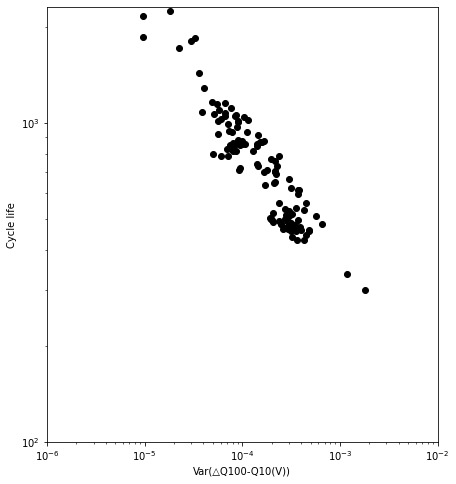

In [1]:
import h5py
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import matplotlib.cm as cm
from scipy.signal import savgol_filter
from scipy import stats

batch1 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch1.pkl', 'rb'))
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

numBat1 = len(batch1.keys())

batch2 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch2.pkl','rb'))
# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]

del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

numBat2 = len(batch2.keys())

batch3 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch3.pkl','rb'))
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c38']
del batch3['b3c39']

numBat3 = len(batch3.keys())
numBat = numBat1 + numBat2 + numBat3
bat_dict = {**batch1, **batch2, **batch3}

X=[]
Y=[]

for i,j in enumerate(bat_dict.keys()):
    if j=='b2c1':
        continue
    if j=='b3c16':
        continue
    if j=='b3c17':
        continue
    if j=='b3c42':
        continue
    if j=='b3c43':
        continue
    Qdlin10,Qdlin100=bat_dict[j]['cycles']['9']['Qdlin'],bat_dict[j]['cycles']['99']['Qdlin']
    diff=diff=Qdlin100-Qdlin10
    var,cycle=np.var(diff),bat_dict[j]['cycle_life'].tolist()
    X.append(var)
    Y.append(cycle[0][0])
    
plt.figure(figsize=(7,8))
plt.scatter(X,Y,color='black')
plt.xscale('log')
plt.yscale('log')
plt.axis([10**(-6),10**(-2),100,2300])
plt.xlabel('Var(△Q100-Q10(V))')
plt.ylabel('Cycle life')

In [2]:
test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))
train_ind = np.arange(1,(numBat1+numBat2-1),2)
secondary_test_ind = np.arange(numBat-numBat3,numBat);

In [3]:
np.random.seed(42)
threshold = 550

In [17]:
imax=150
jmax=150

def i_j_make():
    i_=[]
    j_=[]
    for i in range(2,imax+1): # 
        for j in range(1,jmax+1): # j
            if i<=j:
                continue
            i_.append(i)
            j_.append(j)
    return i_,j_

In [18]:
i_, j_ =i_j_make()

In [19]:
test_data=[]
train_data=[]

test_label=[]
train_label=[]

sec_data=[]
sec_label=[]
for i,j in enumerate(bat_dict.keys()):
    if j=='b2c1':
        continue
    if j=='b3c16':
        continue
    if j=='b3c17':
        continue
    if j=='b3c42':
        continue
    if j=='b3c43':
        continue
    if i in test_ind :
        test_data.append(j)
        cycle_test=bat_dict[j]['cycle_life'].tolist()
        if cycle_test[0][0]>=threshold:
            test_label.append(1)
        else:
            test_label.append(0)
        
    if i in train_ind :
        train_data.append(j)
        cycle_train=bat_dict[j]['cycle_life'].tolist()
        if cycle_train[0][0]>=threshold:
            train_label.append(1)
        else:
            train_label.append(0)
            
            
    if i in secondary_test_ind:
        sec_data.append(j)
        cycle_sec=bat_dict[j]['cycle_life'].tolist()
        if cycle_sec[0][0]>=threshold:
            sec_label.append(1)
        else:
            sec_label.append(0)

In [20]:
test_data=np.array(test_data)
train_data=np.array(train_data)
test_label=np.array(test_label)
train_label=np.array(train_label)
sec_label=np.array(sec_label)
sec_data=np.array(sec_data)


In [21]:
unique, counts = np.unique(train_label, return_counts=True)
print(unique, counts)
unique, counts = np.unique(test_label, return_counts=True)
print(unique, counts)
unique, counts = np.unique(sec_label, return_counts=True)
print(unique, counts)

[0 1] [21 20]
[0 1] [20 22]
[0 1] [ 1 35]


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
def logistic_auc(X,Y,boot_trainX,boot_trainY,boot_testX,boot_testY): #학습은 train data 로 진행 하고 predict는 랜덤 데이터 얻기
    global var,var_test,var_sec

    
    Log_reg = LogisticRegression()
    x=X.reshape(-1,1)
    Log_reg.fit(x,Y)
    train_X=boot_trainX.reshape(-1,1)
    test_X=boot_testX.reshape(-1,1)

    AUC_train=roc_auc_score(boot_trainY, Log_reg.decision_function(train_X))
    AUC_test=roc_auc_score(boot_testY, Log_reg.decision_function(test_X))
    
    coef_info=Log_reg.coef_
    
    pred_train=Log_reg.predict(var.reshape(-1,1))
    at=accuracy_score(Y,pred_train)
    pred_test=Log_reg.predict(var_test.reshape(-1,1))
    apt=accuracy_score(test_label,pred_test)
    pred_sec=Log_reg.predict(var_sec.reshape(-1,1))
    ast=accuracy_score(sec_label,pred_sec)
    
    conf_train=confusion_matrix(Y,pred_train)
    conf_test=confusion_matrix(test_label,pred_test)
    conf_sec=confusion_matrix(sec_label,pred_sec)
    
    return AUC_train, AUC_test,coef_info,conf_train,conf_test,conf_sec, at , apt, ast



In [23]:
#train(i*j) AUC 구하기
mx_train=np.full((jmax+1,imax+1),0.5)
mx_test=np.full((jmax+1,imax+1),0.5)

coef=[]
conf=[]
at_apt_ast=[]
for i,j in zip(i_,j_):
    var_=np.array([])
    var_test_=np.array([])
    var_sec_=np.array([])
    for k in train_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        var_=np.hstack([var_,np.var(diff)])
    for k in test_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        var_test_=np.hstack([var_test_,np.var(diff)])
    for k in sec_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        var_sec_=np.hstack([var_sec_,np.var(diff)])
    print(var_.shape,var_test_.shape,var_sec_.shape)
    
    
    
    #데이터 정규화.
    scaler = StandardScaler() 
    var = scaler.fit_transform(np.log(var_).reshape(-1,1))
    var_test = scaler.transform(np.log(var_test_).reshape(-1,1))
    var_sec = scaler.transform(np.log(var_sec_).reshape(-1,1))   



    boot_select_train=len(var)
    boot_select_test=len(var_test)
    
    boot_sample=20
    
    train_range= range(0,boot_select_train) # 0~40 숫자중 41번 랜덤 선택하도록 한 후 배열에 이 숫자를 적용.
    test_range= range(0,boot_select_test)
    
    AUC_mean_train=[]
    AUC_mean_test=[]
    
    for _ in range(boot_sample):
        np.random.seed(42)
        sample_n=np.random.choice(train_range ,size=boot_select_train)
        sample_test=np.random.choice(test_range ,size=boot_select_test)
        random_trainX=np.array([])
        random_trainY=np.array([])
        random_testX=np.array([])
        random_testY=np.array([])
        for n in sample_n:
            random_trainX=np.hstack([random_trainX,np.array(var[n])])
            random_trainY=np.hstack([random_trainY,np.array([train_label[n]])])
        for n in sample_test:
            random_testX=np.hstack([random_testX,np.array(var_test[n])])
            random_testY=np.hstack([random_testY,np.array([test_label[n]])])
        auc_train,auc_test,coef_,conf_train,conf_test,conf_sec, at , apt, ast=logistic_auc(
            var,train_label,random_trainX,random_trainY,random_testX,random_testY)
        AUC_mean_train.append(auc_train)
        AUC_mean_test.append(auc_test)
    print('i={},j={}   AUC_train= '.format(i,j),np.mean(AUC_mean_train))
    print('i={},j={}   AUC_test= '.format(i,j),np.mean(AUC_mean_test))
    print('\n')
    mx_train[j,i]= np.mean(AUC_mean_train)
    mx_test[j,i]= np.mean(AUC_mean_test)
    if i==5 and j==4 :
        coef.append(coef_)
        conf.append(conf_train)
        conf.append(conf_test)
        conf.append(conf_sec)
        at_apt_ast.append(at)
        at_apt_ast.append(apt)
        at_apt_ast.append(ast)

(41,) (42,) (36,)
i=2,j=1   AUC_train=  0.9371980676328502
i=2,j=1   AUC_test=  0.5879629629629631


(41,) (42,) (36,)
i=3,j=1   AUC_train=  0.9637681159420287
i=3,j=1   AUC_test=  0.8032407407407408


(41,) (42,) (36,)
i=3,j=2   AUC_train=  0.9323671497584544
i=3,j=2   AUC_test=  0.9027777777777779


(41,) (42,) (36,)
i=4,j=1   AUC_train=  0.8429951690821257
i=4,j=1   AUC_test=  0.6574074074074077


(41,) (42,) (36,)
i=4,j=2   AUC_train=  0.8333333333333334
i=4,j=2   AUC_test=  0.826388888888889


(41,) (42,) (36,)
i=4,j=3   AUC_train=  0.9806763285024156
i=4,j=3   AUC_test=  0.7777777777777779


(41,) (42,) (36,)
i=5,j=1   AUC_train=  0.8164251207729467
i=5,j=1   AUC_test=  0.27083333333333326


(41,) (42,) (36,)
i=5,j=2   AUC_train=  0.567632850241546
i=5,j=2   AUC_test=  0.6412037037037038


(41,) (42,) (36,)
i=5,j=3   AUC_train=  0.6884057971014492
i=5,j=3   AUC_test=  0.6319444444444444


(41,) (42,) (36,)
i=5,j=4   AUC_train=  0.9178743961352656
i=5,j=4   AUC_test=  0.7245370370

i=14,j=4   AUC_train=  0.9637681159420287
i=14,j=4   AUC_test=  0.6226851851851851


(41,) (42,) (36,)
i=14,j=5   AUC_train=  0.8526570048309179
i=14,j=5   AUC_test=  0.4351851851851851


(41,) (42,) (36,)
i=14,j=6   AUC_train=  0.8937198067632851
i=14,j=6   AUC_test=  0.6111111111111109


(41,) (42,) (36,)
i=14,j=7   AUC_train=  0.9661835748792271
i=14,j=7   AUC_test=  0.6064814814814813


(41,) (42,) (36,)
i=14,j=8   AUC_train=  0.8671497584541065
i=14,j=8   AUC_test=  0.6111111111111109


(41,) (42,) (36,)
i=14,j=9   AUC_train=  0.8840579710144926
i=14,j=9   AUC_test=  0.6203703703703703


(41,) (42,) (36,)
i=14,j=10   AUC_train=  0.9420289855072463
i=14,j=10   AUC_test=  0.5833333333333336


(41,) (42,) (36,)
i=14,j=11   AUC_train=  0.4613526570048309
i=14,j=11   AUC_test=  0.4166666666666667


(41,) (42,) (36,)
i=14,j=12   AUC_train=  0.7028985507246375
i=14,j=12   AUC_test=  0.4884259259259259


(41,) (42,) (36,)
i=14,j=13   AUC_train=  0.9082125603864736
i=14,j=13   AUC_test=  0

i=19,j=10   AUC_train=  0.7270531400966184
i=19,j=10   AUC_test=  0.5115740740740742


(41,) (42,) (36,)
i=19,j=11   AUC_train=  0.4855072463768117
i=19,j=11   AUC_test=  0.5347222222222221


(41,) (42,) (36,)
i=19,j=12   AUC_train=  0.2971014492753623
i=19,j=12   AUC_test=  0.548611111111111


(41,) (42,) (36,)
i=19,j=13   AUC_train=  0.6159420289855074
i=19,j=13   AUC_test=  0.4814814814814814


(41,) (42,) (36,)
i=19,j=14   AUC_train=  0.6545893719806765
i=19,j=14   AUC_test=  0.659722222222222


(41,) (42,) (36,)
i=19,j=15   AUC_train=  0.9806763285024156
i=19,j=15   AUC_test=  0.9189814814814815


(41,) (42,) (36,)
i=19,j=16   AUC_train=  0.7077294685990339
i=19,j=16   AUC_test=  0.8148148148148147


(41,) (42,) (36,)
i=19,j=17   AUC_train=  0.9009661835748795
i=19,j=17   AUC_test=  0.8101851851851851


(41,) (42,) (36,)
i=19,j=18   AUC_train=  0.9710144927536236
i=19,j=18   AUC_test=  0.875


(41,) (42,) (36,)
i=20,j=1   AUC_train=  0.9637681159420287
i=20,j=1   AUC_test=  0.6620

i=23,j=12   AUC_train=  0.23188405797101455
i=23,j=12   AUC_test=  0.2592592592592593


(41,) (42,) (36,)
i=23,j=13   AUC_train=  0.7681159420289856
i=23,j=13   AUC_test=  0.923611111111111


(41,) (42,) (36,)
i=23,j=14   AUC_train=  0.9082125603864736
i=23,j=14   AUC_test=  0.861111111111111


(41,) (42,) (36,)
i=23,j=15   AUC_train=  0.9371980676328502
i=23,j=15   AUC_test=  0.923611111111111


(41,) (42,) (36,)
i=23,j=16   AUC_train=  0.898550724637681
i=23,j=16   AUC_test=  0.888888888888889


(41,) (42,) (36,)
i=23,j=17   AUC_train=  0.9855072463768118
i=23,j=17   AUC_test=  0.8912037037037036


(41,) (42,) (36,)
i=23,j=18   AUC_train=  0.9202898550724639
i=23,j=18   AUC_test=  0.9120370370370372


(41,) (42,) (36,)
i=23,j=19   AUC_train=  0.9009661835748795
i=23,j=19   AUC_test=  0.8564814814814815


(41,) (42,) (36,)
i=23,j=20   AUC_train=  0.9323671497584544
i=23,j=20   AUC_test=  0.9398148148148145


(41,) (42,) (36,)
i=23,j=21   AUC_train=  0.9855072463768118
i=23,j=21   AUC_

i=26,j=23   AUC_train=  0.9444444444444441
i=26,j=23   AUC_test=  0.6828703703703703


(41,) (42,) (36,)
i=26,j=24   AUC_train=  0.9879227053140097
i=26,j=24   AUC_test=  0.8518518518518517


(41,) (42,) (36,)
i=26,j=25   AUC_train=  0.9806763285024156
i=26,j=25   AUC_test=  0.7268518518518517


(41,) (42,) (36,)
i=27,j=1   AUC_train=  0.9396135265700483
i=27,j=1   AUC_test=  0.6435185185185187


(41,) (42,) (36,)
i=27,j=2   AUC_train=  0.9251207729468597
i=27,j=2   AUC_test=  0.7129629629629631


(41,) (42,) (36,)
i=27,j=3   AUC_train=  0.9178743961352656
i=27,j=3   AUC_test=  0.7337962962962962


(41,) (42,) (36,)
i=27,j=4   AUC_train=  0.8526570048309179
i=27,j=4   AUC_test=  0.7685185185185186


(41,) (42,) (36,)
i=27,j=5   AUC_train=  0.8840579710144928
i=27,j=5   AUC_test=  0.7430555555555556


(41,) (42,) (36,)
i=27,j=6   AUC_train=  0.8913043478260867
i=27,j=6   AUC_test=  0.7129629629629631


(41,) (42,) (36,)
i=27,j=7   AUC_train=  0.6135265700483092
i=27,j=7   AUC_test=  0.6

i=29,j=25   AUC_train=  0.898550724637681
i=29,j=25   AUC_test=  0.7384259259259259


(41,) (42,) (36,)
i=29,j=26   AUC_train=  0.9661835748792271
i=29,j=26   AUC_test=  0.9074074074074074


(41,) (42,) (36,)
i=29,j=27   AUC_train=  0.951690821256039
i=29,j=27   AUC_test=  0.8564814814814813


(41,) (42,) (36,)
i=29,j=28   AUC_train=  0.9637681159420287
i=29,j=28   AUC_test=  0.7708333333333335


(41,) (42,) (36,)
i=30,j=1   AUC_train=  0.898550724637681
i=30,j=1   AUC_test=  0.7592592592592593


(41,) (42,) (36,)
i=30,j=2   AUC_train=  0.9154589371980675
i=30,j=2   AUC_test=  0.7986111111111109


(41,) (42,) (36,)
i=30,j=3   AUC_train=  0.9323671497584544
i=30,j=3   AUC_test=  0.8171296296296295


(41,) (42,) (36,)
i=30,j=4   AUC_train=  0.8429951690821257
i=30,j=4   AUC_test=  0.8796296296296295


(41,) (42,) (36,)
i=30,j=5   AUC_train=  0.9009661835748795
i=30,j=5   AUC_test=  0.8402777777777779


(41,) (42,) (36,)
i=30,j=6   AUC_train=  0.886473429951691
i=30,j=6   AUC_test=  0.828

i=32,j=18   AUC_train=  0.9396135265700483
i=32,j=18   AUC_test=  0.9814814814814815


(41,) (42,) (36,)
i=32,j=19   AUC_train=  0.9516908212560388
i=32,j=19   AUC_test=  0.9328703703703705


(41,) (42,) (36,)
i=32,j=20   AUC_train=  0.9468599033816426
i=32,j=20   AUC_test=  0.9444444444444443


(41,) (42,) (36,)
i=32,j=21   AUC_train=  0.9371980676328502
i=32,j=21   AUC_test=  0.9768518518518517


(41,) (42,) (36,)
i=32,j=22   AUC_train=  0.8743961352657005
i=32,j=22   AUC_test=  0.8703703703703705


(41,) (42,) (36,)
i=32,j=23   AUC_train=  0.9323671497584544
i=32,j=23   AUC_test=  0.7592592592592593


(41,) (42,) (36,)
i=32,j=24   AUC_train=  0.929951690821256
i=32,j=24   AUC_test=  0.8819444444444443


(41,) (42,) (36,)
i=32,j=25   AUC_train=  0.9202898550724639
i=32,j=25   AUC_test=  0.8449074074074072


(41,) (42,) (36,)
i=32,j=26   AUC_train=  0.9710144927536234
i=32,j=26   AUC_test=  0.9189814814814813


(41,) (42,) (36,)
i=32,j=27   AUC_train=  0.9492753623188405
i=32,j=27   A

i=35,j=2   AUC_train=  0.9347826086956521
i=35,j=2   AUC_test=  0.8171296296296295


(41,) (42,) (36,)
i=35,j=3   AUC_train=  0.927536231884058
i=35,j=3   AUC_test=  0.8379629629629631


(41,) (42,) (36,)
i=35,j=4   AUC_train=  0.9082125603864736
i=35,j=4   AUC_test=  0.8587962962962964


(41,) (42,) (36,)
i=35,j=5   AUC_train=  0.927536231884058
i=35,j=5   AUC_test=  0.8148148148148149


(41,) (42,) (36,)
i=35,j=6   AUC_train=  0.9106280193236713
i=35,j=6   AUC_test=  0.8032407407407407


(41,) (42,) (36,)
i=35,j=7   AUC_train=  0.8768115942028987
i=35,j=7   AUC_test=  0.7546296296296297


(41,) (42,) (36,)
i=35,j=8   AUC_train=  0.8864734299516908
i=35,j=8   AUC_test=  0.7685185185185187


(41,) (42,) (36,)
i=35,j=9   AUC_train=  0.9130434782608697
i=35,j=9   AUC_test=  0.798611111111111


(41,) (42,) (36,)
i=35,j=10   AUC_train=  0.8840579710144926
i=35,j=10   AUC_test=  0.7430555555555556


(41,) (42,) (36,)
i=35,j=11   AUC_train=  0.8067632850241544
i=35,j=11   AUC_test=  0.606481

i=37,j=13   AUC_train=  0.8502415458937198
i=37,j=13   AUC_test=  0.8773148148148147


(41,) (42,) (36,)
i=37,j=14   AUC_train=  0.9251207729468597
i=37,j=14   AUC_test=  0.8703703703703705


(41,) (42,) (36,)
i=37,j=15   AUC_train=  0.8961352657004831
i=37,j=15   AUC_test=  0.9189814814814815


(41,) (42,) (36,)
i=37,j=16   AUC_train=  0.8961352657004833
i=37,j=16   AUC_test=  0.8935185185185185


(41,) (42,) (36,)
i=37,j=17   AUC_train=  0.9130434782608697
i=37,j=17   AUC_test=  0.9027777777777779


(41,) (42,) (36,)
i=37,j=18   AUC_train=  0.8719806763285021
i=37,j=18   AUC_test=  0.9444444444444441


(41,) (42,) (36,)
i=37,j=19   AUC_train=  0.9371980676328502
i=37,j=19   AUC_test=  0.8657407407407408


(41,) (42,) (36,)
i=37,j=20   AUC_train=  0.9130434782608697
i=37,j=20   AUC_test=  0.9189814814814815


(41,) (42,) (36,)
i=37,j=21   AUC_train=  0.8695652173913043
i=37,j=21   AUC_test=  0.900462962962963


(41,) (42,) (36,)
i=37,j=22   AUC_train=  0.8840579710144926
i=37,j=22   A

i=39,j=20   AUC_train=  0.9082125603864736
i=39,j=20   AUC_test=  0.9027777777777779


(41,) (42,) (36,)
i=39,j=21   AUC_train=  0.8405797101449275
i=39,j=21   AUC_test=  0.8564814814814815


(41,) (42,) (36,)
i=39,j=22   AUC_train=  0.7198067632850242
i=39,j=22   AUC_test=  0.7800925925925928


(41,) (42,) (36,)
i=39,j=23   AUC_train=  0.8454106280193235
i=39,j=23   AUC_test=  0.6851851851851851


(41,) (42,) (36,)
i=39,j=24   AUC_train=  0.9082125603864734
i=39,j=24   AUC_test=  0.8796296296296295


(41,) (42,) (36,)
i=39,j=25   AUC_train=  0.8743961352657005
i=39,j=25   AUC_test=  0.7569444444444445


(41,) (42,) (36,)
i=39,j=26   AUC_train=  0.9106280193236713
i=39,j=26   AUC_test=  0.8958333333333333


(41,) (42,) (36,)
i=39,j=27   AUC_train=  0.8913043478260867
i=39,j=27   AUC_test=  0.8587962962962964


(41,) (42,) (36,)
i=39,j=28   AUC_train=  0.8961352657004829
i=39,j=28   AUC_test=  0.8472222222222221


(41,) (42,) (36,)
i=39,j=29   AUC_train=  0.855072463768116
i=39,j=29   A

i=41,j=23   AUC_train=  0.927536231884058
i=41,j=23   AUC_test=  0.7569444444444445


(41,) (42,) (36,)
i=41,j=24   AUC_train=  0.857487922705314
i=41,j=24   AUC_test=  0.8425925925925928


(41,) (42,) (36,)
i=41,j=25   AUC_train=  0.9347826086956521
i=41,j=25   AUC_test=  0.8124999999999998


(41,) (42,) (36,)
i=41,j=26   AUC_train=  0.9492753623188406
i=41,j=26   AUC_test=  0.8981481481481483


(41,) (42,) (36,)
i=41,j=27   AUC_train=  0.9033816425120772
i=41,j=27   AUC_test=  0.8587962962962964


(41,) (42,) (36,)
i=41,j=28   AUC_train=  0.9468599033816426
i=41,j=28   AUC_test=  0.8055555555555556


(41,) (42,) (36,)
i=41,j=29   AUC_train=  0.9323671497584544
i=41,j=29   AUC_test=  0.8287037037037038


(41,) (42,) (36,)
i=41,j=30   AUC_train=  0.8961352657004833
i=41,j=30   AUC_test=  0.7430555555555555


(41,) (42,) (36,)
i=41,j=31   AUC_train=  0.961352657004831
i=41,j=31   AUC_test=  0.8032407407407408


(41,) (42,) (36,)
i=41,j=32   AUC_train=  0.9492753623188405
i=41,j=32   AUC

i=43,j=22   AUC_train=  0.8285024154589372
i=43,j=22   AUC_test=  0.8125


(41,) (42,) (36,)
i=43,j=23   AUC_train=  0.7705314009661834
i=43,j=23   AUC_test=  0.7546296296296297


(41,) (42,) (36,)
i=43,j=24   AUC_train=  0.8478260869565218
i=43,j=24   AUC_test=  0.9166666666666667


(41,) (42,) (36,)
i=43,j=25   AUC_train=  0.8550724637681159
i=43,j=25   AUC_test=  0.8287037037037038


(41,) (42,) (36,)
i=43,j=26   AUC_train=  0.9178743961352656
i=43,j=26   AUC_test=  0.9189814814814815


(41,) (42,) (36,)
i=43,j=27   AUC_train=  0.8309178743961352
i=43,j=27   AUC_test=  0.9282407407407408


(41,) (42,) (36,)
i=43,j=28   AUC_train=  0.7946859903381643
i=43,j=28   AUC_test=  0.8194444444444443


(41,) (42,) (36,)
i=43,j=29   AUC_train=  0.789855072463768
i=43,j=29   AUC_test=  0.826388888888889


(41,) (42,) (36,)
i=43,j=30   AUC_train=  0.8260869565217389
i=43,j=30   AUC_test=  0.8032407407407408


(41,) (42,) (36,)
i=43,j=31   AUC_train=  0.8840579710144928
i=43,j=31   AUC_test=  0.7

i=45,j=17   AUC_train=  0.9251207729468597
i=45,j=17   AUC_test=  0.9351851851851855


(41,) (42,) (36,)
i=45,j=18   AUC_train=  0.8333333333333334
i=45,j=18   AUC_test=  0.888888888888889


(41,) (42,) (36,)
i=45,j=19   AUC_train=  0.8671497584541064
i=45,j=19   AUC_test=  0.9212962962962964


(41,) (42,) (36,)
i=45,j=20   AUC_train=  0.9082125603864734
i=45,j=20   AUC_test=  0.9537037037037035


(41,) (42,) (36,)
i=45,j=21   AUC_train=  0.7681159420289856
i=45,j=21   AUC_test=  0.8750000000000002


(41,) (42,) (36,)
i=45,j=22   AUC_train=  0.7608695652173911
i=45,j=22   AUC_test=  0.8587962962962962


(41,) (42,) (36,)
i=45,j=23   AUC_train=  0.8623188405797103
i=45,j=23   AUC_test=  0.8333333333333334


(41,) (42,) (36,)
i=45,j=24   AUC_train=  0.8792270531400966
i=45,j=24   AUC_test=  0.9166666666666667


(41,) (42,) (36,)
i=45,j=25   AUC_train=  0.9130434782608697
i=45,j=25   AUC_test=  0.9143518518518517


(41,) (42,) (36,)
i=45,j=26   AUC_train=  0.927536231884058
i=45,j=26   AU

i=47,j=8   AUC_train=  0.951690821256039
i=47,j=8   AUC_test=  0.8819444444444443


(41,) (42,) (36,)
i=47,j=9   AUC_train=  0.9565217391304346
i=47,j=9   AUC_test=  0.8981481481481483


(41,) (42,) (36,)
i=47,j=10   AUC_train=  0.9009661835748792
i=47,j=10   AUC_test=  0.8958333333333333


(41,) (42,) (36,)
i=47,j=11   AUC_train=  0.8502415458937198
i=47,j=11   AUC_test=  0.7592592592592593


(41,) (42,) (36,)
i=47,j=12   AUC_train=  0.8840579710144926
i=47,j=12   AUC_test=  0.9351851851851851


(41,) (42,) (36,)
i=47,j=13   AUC_train=  0.9661835748792272
i=47,j=13   AUC_test=  0.9675925925925926


(41,) (42,) (36,)
i=47,j=14   AUC_train=  0.9806763285024156
i=47,j=14   AUC_test=  0.9768518518518517


(41,) (42,) (36,)
i=47,j=15   AUC_train=  0.9758454106280192
i=47,j=15   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=47,j=16   AUC_train=  0.9806763285024156
i=47,j=16   AUC_test=  0.9814814814814815


(41,) (42,) (36,)
i=47,j=17   AUC_train=  0.990338164251208
i=47,j=17   AUC_te

i=48,j=44   AUC_train=  0.9227053140096618
i=48,j=44   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=48,j=45   AUC_train=  0.9806763285024156
i=48,j=45   AUC_test=  0.9351851851851855


(41,) (42,) (36,)
i=48,j=46   AUC_train=  0.997584541062802
i=48,j=46   AUC_test=  0.9560185185185185


(41,) (42,) (36,)
i=48,j=47   AUC_train=  0.9154589371980675
i=48,j=47   AUC_test=  0.6574074074074077


(41,) (42,) (36,)
i=49,j=1   AUC_train=  0.9009661835748795
i=49,j=1   AUC_test=  0.8564814814814813


(41,) (42,) (36,)
i=49,j=2   AUC_train=  0.8429951690821257
i=49,j=2   AUC_test=  0.849537037037037


(41,) (42,) (36,)
i=49,j=3   AUC_train=  0.8961352657004831
i=49,j=3   AUC_test=  0.8472222222222221


(41,) (42,) (36,)
i=49,j=4   AUC_train=  0.826086956521739
i=49,j=4   AUC_test=  0.8680555555555557


(41,) (42,) (36,)
i=49,j=5   AUC_train=  0.8357487922705313
i=49,j=5   AUC_test=  0.861111111111111


(41,) (42,) (36,)
i=49,j=6   AUC_train=  0.8792270531400966
i=49,j=6   AUC_test=  0.844

i=50,j=29   AUC_train=  0.9541062801932367
i=50,j=29   AUC_test=  0.9027777777777779


(41,) (42,) (36,)
i=50,j=30   AUC_train=  0.9009661835748795
i=50,j=30   AUC_test=  0.837962962962963


(41,) (42,) (36,)
i=50,j=31   AUC_train=  0.9685990338164251
i=50,j=31   AUC_test=  0.8333333333333336


(41,) (42,) (36,)
i=50,j=32   AUC_train=  0.9251207729468597
i=50,j=32   AUC_test=  0.8564814814814813


(41,) (42,) (36,)
i=50,j=33   AUC_train=  0.9033816425120772
i=50,j=33   AUC_test=  0.7893518518518519


(41,) (42,) (36,)
i=50,j=34   AUC_train=  0.9782608695652175
i=50,j=34   AUC_test=  0.8240740740740741


(41,) (42,) (36,)
i=50,j=35   AUC_train=  0.8792270531400964
i=50,j=35   AUC_test=  0.8518518518518517


(41,) (42,) (36,)
i=50,j=36   AUC_train=  0.9420289855072463
i=50,j=36   AUC_test=  0.8171296296296295


(41,) (42,) (36,)
i=50,j=37   AUC_train=  0.9782608695652175
i=50,j=37   AUC_test=  0.8587962962962964


(41,) (42,) (36,)
i=50,j=38   AUC_train=  0.9178743961352657
i=50,j=38   A

i=52,j=10   AUC_train=  0.855072463768116
i=52,j=10   AUC_test=  0.8958333333333333


(41,) (42,) (36,)
i=52,j=11   AUC_train=  0.7367149758454106
i=52,j=11   AUC_test=  0.7800925925925923


(41,) (42,) (36,)
i=52,j=12   AUC_train=  0.8212560386473429
i=52,j=12   AUC_test=  0.9120370370370372


(41,) (42,) (36,)
i=52,j=13   AUC_train=  0.8671497584541064
i=52,j=13   AUC_test=  0.923611111111111


(41,) (42,) (36,)
i=52,j=14   AUC_train=  0.8719806763285025
i=52,j=14   AUC_test=  0.9421296296296295


(41,) (42,) (36,)
i=52,j=15   AUC_train=  0.8792270531400964
i=52,j=15   AUC_test=  0.9166666666666667


(41,) (42,) (36,)
i=52,j=16   AUC_train=  0.8671497584541064
i=52,j=16   AUC_test=  0.9374999999999998


(41,) (42,) (36,)
i=52,j=17   AUC_train=  0.8961352657004831
i=52,j=17   AUC_test=  0.9212962962962964


(41,) (42,) (36,)
i=52,j=18   AUC_train=  0.855072463768116
i=52,j=18   AUC_test=  0.8981481481481483


(41,) (42,) (36,)
i=52,j=19   AUC_train=  0.8768115942028987
i=52,j=19   AUC

i=53,j=39   AUC_train=  0.785024154589372
i=53,j=39   AUC_test=  0.6712962962962962


(41,) (42,) (36,)
i=53,j=40   AUC_train=  0.8115942028985506
i=53,j=40   AUC_test=  0.7013888888888891


(41,) (42,) (36,)
i=53,j=41   AUC_train=  0.536231884057971
i=53,j=41   AUC_test=  0.6180555555555556


(41,) (42,) (36,)
i=53,j=42   AUC_train=  0.6135265700483091
i=53,j=42   AUC_test=  0.5787037037037038


(41,) (42,) (36,)
i=53,j=43   AUC_train=  0.6714975845410629
i=53,j=43   AUC_test=  0.5324074074074077


(41,) (42,) (36,)
i=53,j=44   AUC_train=  0.6642512077294687
i=53,j=44   AUC_test=  0.5462962962962962


(41,) (42,) (36,)
i=53,j=45   AUC_train=  0.5603864734299517
i=53,j=45   AUC_test=  0.3773148148148148


(41,) (42,) (36,)
i=53,j=46   AUC_train=  0.6304347826086956
i=53,j=46   AUC_test=  0.4444444444444445


(41,) (42,) (36,)
i=53,j=47   AUC_train=  0.6280193236714974
i=53,j=47   AUC_test=  0.7453703703703705


(41,) (42,) (36,)
i=53,j=48   AUC_train=  0.6014492753623187
i=53,j=48   AU

i=55,j=14   AUC_train=  0.9130434782608697
i=55,j=14   AUC_test=  0.9537037037037036


(41,) (42,) (36,)
i=55,j=15   AUC_train=  0.8816425120772948
i=55,j=15   AUC_test=  0.9097222222222221


(41,) (42,) (36,)
i=55,j=16   AUC_train=  0.9227053140096618
i=55,j=16   AUC_test=  0.9490740740740738


(41,) (42,) (36,)
i=55,j=17   AUC_train=  0.927536231884058
i=55,j=17   AUC_test=  0.9537037037037035


(41,) (42,) (36,)
i=55,j=18   AUC_train=  0.8623188405797103
i=55,j=18   AUC_test=  0.9259259259259262


(41,) (42,) (36,)
i=55,j=19   AUC_train=  0.9202898550724639
i=55,j=19   AUC_test=  0.9444444444444443


(41,) (42,) (36,)
i=55,j=20   AUC_train=  0.8913043478260869
i=55,j=20   AUC_test=  0.9722222222222221


(41,) (42,) (36,)
i=55,j=21   AUC_train=  0.888888888888889
i=55,j=21   AUC_test=  0.923611111111111


(41,) (42,) (36,)
i=55,j=22   AUC_train=  0.9154589371980675
i=55,j=22   AUC_test=  0.9212962962962965


(41,) (42,) (36,)
i=55,j=23   AUC_train=  0.9057971014492754
i=55,j=23   AUC

i=56,j=40   AUC_train=  0.9565217391304346
i=56,j=40   AUC_test=  0.9421296296296295


(41,) (42,) (36,)
i=56,j=41   AUC_train=  0.8429951690821257
i=56,j=41   AUC_test=  0.9375


(41,) (42,) (36,)
i=56,j=42   AUC_train=  0.9371980676328502
i=56,j=42   AUC_test=  0.9305555555555557


(41,) (42,) (36,)
i=56,j=43   AUC_train=  0.9444444444444441
i=56,j=43   AUC_test=  0.9375


(41,) (42,) (36,)
i=56,j=44   AUC_train=  0.7173913043478259
i=56,j=44   AUC_test=  0.849537037037037


(41,) (42,) (36,)
i=56,j=45   AUC_train=  0.9130434782608697
i=56,j=45   AUC_test=  0.912037037037037


(41,) (42,) (36,)
i=56,j=46   AUC_train=  0.9396135265700485
i=56,j=46   AUC_test=  0.9282407407407407


(41,) (42,) (36,)
i=56,j=47   AUC_train=  0.857487922705314
i=56,j=47   AUC_test=  0.7870370370370368


(41,) (42,) (36,)
i=56,j=48   AUC_train=  0.8913043478260867
i=56,j=48   AUC_test=  0.8310185185185187


(41,) (42,) (36,)
i=56,j=49   AUC_train=  0.8405797101449275
i=56,j=49   AUC_test=  0.74768518518518

i=58,j=9   AUC_train=  0.9420289855072463
i=58,j=9   AUC_test=  0.8842592592592593


(41,) (42,) (36,)
i=58,j=10   AUC_train=  0.898550724637681
i=58,j=10   AUC_test=  0.875


(41,) (42,) (36,)
i=58,j=11   AUC_train=  0.8260869565217389
i=58,j=11   AUC_test=  0.7731481481481484


(41,) (42,) (36,)
i=58,j=12   AUC_train=  0.888888888888889
i=58,j=12   AUC_test=  0.9097222222222221


(41,) (42,) (36,)
i=58,j=13   AUC_train=  0.9516908212560388
i=58,j=13   AUC_test=  0.9305555555555557


(41,) (42,) (36,)
i=58,j=14   AUC_train=  0.9806763285024156
i=58,j=14   AUC_test=  0.9722222222222221


(41,) (42,) (36,)
i=58,j=15   AUC_train=  0.9565217391304346
i=58,j=15   AUC_test=  0.9467592592592593


(41,) (42,) (36,)
i=58,j=16   AUC_train=  0.9855072463768118
i=58,j=16   AUC_test=  0.9652777777777779


(41,) (42,) (36,)
i=58,j=17   AUC_train=  0.9806763285024156
i=58,j=17   AUC_test=  0.9675925925925923


(41,) (42,) (36,)
i=58,j=18   AUC_train=  0.927536231884058
i=58,j=18   AUC_test=  0.92824

i=59,j=32   AUC_train=  0.9371980676328502
i=59,j=32   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=59,j=33   AUC_train=  0.9033816425120772
i=59,j=33   AUC_test=  0.9398148148148149


(41,) (42,) (36,)
i=59,j=34   AUC_train=  0.9444444444444441
i=59,j=34   AUC_test=  0.9467592592592592


(41,) (42,) (36,)
i=59,j=35   AUC_train=  0.8285024154589372
i=59,j=35   AUC_test=  0.9398148148148149


(41,) (42,) (36,)
i=59,j=36   AUC_train=  0.9420289855072463
i=59,j=36   AUC_test=  0.965277777777778


(41,) (42,) (36,)
i=59,j=37   AUC_train=  0.990338164251208
i=59,j=37   AUC_test=  0.9583333333333333


(41,) (42,) (36,)
i=59,j=38   AUC_train=  0.8913043478260867
i=59,j=38   AUC_test=  0.9675925925925923


(41,) (42,) (36,)
i=59,j=39   AUC_train=  0.9855072463768118
i=59,j=39   AUC_test=  0.9791666666666667


(41,) (42,) (36,)
i=59,j=40   AUC_train=  0.9855072463768118
i=59,j=40   AUC_test=  0.9583333333333333


(41,) (42,) (36,)
i=59,j=41   AUC_train=  0.8285024154589372
i=59,j=41   AU

i=60,j=54   AUC_train=  0.6835748792270528
i=60,j=54   AUC_test=  0.7291666666666665


(41,) (42,) (36,)
i=60,j=55   AUC_train=  0.7681159420289856
i=60,j=55   AUC_test=  0.5300925925925923


(41,) (42,) (36,)
i=60,j=56   AUC_train=  0.8019323671497582
i=60,j=56   AUC_test=  0.6435185185185186


(41,) (42,) (36,)
i=60,j=57   AUC_train=  0.929951690821256
i=60,j=57   AUC_test=  0.9097222222222221


(41,) (42,) (36,)
i=60,j=58   AUC_train=  0.9565217391304346
i=60,j=58   AUC_test=  0.8796296296296295


(41,) (42,) (36,)
i=60,j=59   AUC_train=  0.961352657004831
i=60,j=59   AUC_test=  0.8032407407407408


(41,) (42,) (36,)
i=61,j=1   AUC_train=  0.8671497584541064
i=61,j=1   AUC_test=  0.8587962962962964


(41,) (42,) (36,)
i=61,j=2   AUC_train=  0.9227053140096618
i=61,j=2   AUC_test=  0.8703703703703705


(41,) (42,) (36,)
i=61,j=3   AUC_train=  0.9347826086956521
i=61,j=3   AUC_test=  0.8796296296296295


(41,) (42,) (36,)
i=61,j=4   AUC_train=  0.905797101449275
i=61,j=4   AUC_test=  

i=62,j=15   AUC_train=  0.8864734299516908
i=62,j=15   AUC_test=  0.9444444444444443


(41,) (42,) (36,)
i=62,j=16   AUC_train=  0.9371980676328502
i=62,j=16   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=62,j=17   AUC_train=  0.9468599033816426
i=62,j=17   AUC_test=  0.9675925925925926


(41,) (42,) (36,)
i=62,j=18   AUC_train=  0.855072463768116
i=62,j=18   AUC_test=  0.9351851851851851


(41,) (42,) (36,)
i=62,j=19   AUC_train=  0.9371980676328502
i=62,j=19   AUC_test=  0.9675925925925923


(41,) (42,) (36,)
i=62,j=20   AUC_train=  0.9565217391304346
i=62,j=20   AUC_test=  0.9675925925925923


(41,) (42,) (36,)
i=62,j=21   AUC_train=  0.8864734299516908
i=62,j=21   AUC_test=  0.951388888888889


(41,) (42,) (36,)
i=62,j=22   AUC_train=  0.9347826086956521
i=62,j=22   AUC_test=  0.9490740740740738


(41,) (42,) (36,)
i=62,j=23   AUC_train=  0.9396135265700483
i=62,j=23   AUC_test=  0.9143518518518519


(41,) (42,) (36,)
i=62,j=24   AUC_train=  0.857487922705314
i=62,j=24   AUC

i=63,j=34   AUC_train=  0.9227053140096618
i=63,j=34   AUC_test=  0.9027777777777779


(41,) (42,) (36,)
i=63,j=35   AUC_train=  0.7801932367149758
i=63,j=35   AUC_test=  0.9050925925925923


(41,) (42,) (36,)
i=63,j=36   AUC_train=  0.9420289855072463
i=63,j=36   AUC_test=  0.9328703703703705


(41,) (42,) (36,)
i=63,j=37   AUC_train=  0.9806763285024156
i=63,j=37   AUC_test=  0.9675925925925926


(41,) (42,) (36,)
i=63,j=38   AUC_train=  0.9371980676328502
i=63,j=38   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=63,j=39   AUC_train=  0.961352657004831
i=63,j=39   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=63,j=40   AUC_train=  0.9782608695652175
i=63,j=40   AUC_test=  0.9421296296296295


(41,) (42,) (36,)
i=63,j=41   AUC_train=  0.8719806763285025
i=63,j=41   AUC_test=  0.9305555555555557


(41,) (42,) (36,)
i=63,j=42   AUC_train=  0.9782608695652175
i=63,j=42   AUC_test=  0.9490740740740738


(41,) (42,) (36,)
i=63,j=43   AUC_train=  0.9951690821256038
i=63,j=43   A

i=64,j=52   AUC_train=  0.5120772946859905
i=64,j=52   AUC_test=  0.46759259259259256


(41,) (42,) (36,)
i=64,j=53   AUC_train=  0.6207729468599034
i=64,j=53   AUC_test=  0.6875


(41,) (42,) (36,)
i=64,j=54   AUC_train=  0.4613526570048309
i=64,j=54   AUC_test=  0.6273148148148148


(41,) (42,) (36,)
i=64,j=55   AUC_train=  0.3454106280193237
i=64,j=55   AUC_test=  0.5277777777777779


(41,) (42,) (36,)
i=64,j=56   AUC_train=  0.760869565217391
i=64,j=56   AUC_test=  0.5601851851851852


(41,) (42,) (36,)
i=64,j=57   AUC_train=  0.9227053140096618
i=64,j=57   AUC_test=  0.8356481481481483


(41,) (42,) (36,)
i=64,j=58   AUC_train=  0.7608695652173912
i=64,j=58   AUC_test=  0.7083333333333335


(41,) (42,) (36,)
i=64,j=59   AUC_train=  0.859903381642512
i=64,j=59   AUC_test=  0.7569444444444444


(41,) (42,) (36,)
i=64,j=60   AUC_train=  0.9106280193236713
i=64,j=60   AUC_test=  0.7685185185185187


(41,) (42,) (36,)
i=64,j=61   AUC_train=  0.7125603864734298
i=64,j=61   AUC_test=  0.

i=66,j=5   AUC_train=  0.857487922705314
i=66,j=5   AUC_test=  0.8819444444444444


(41,) (42,) (36,)
i=66,j=6   AUC_train=  0.8647342995169082
i=66,j=6   AUC_test=  0.861111111111111


(41,) (42,) (36,)
i=66,j=7   AUC_train=  0.7584541062801933
i=66,j=7   AUC_test=  0.849537037037037


(41,) (42,) (36,)
i=66,j=8   AUC_train=  0.8429951690821257
i=66,j=8   AUC_test=  0.840277777777778


(41,) (42,) (36,)
i=66,j=9   AUC_train=  0.8502415458937197
i=66,j=9   AUC_test=  0.8425925925925928


(41,) (42,) (36,)
i=66,j=10   AUC_train=  0.8212560386473429
i=66,j=10   AUC_test=  0.8449074074074077


(41,) (42,) (36,)
i=66,j=11   AUC_train=  0.28985507246376796
i=66,j=11   AUC_test=  0.2893518518518519


(41,) (42,) (36,)
i=66,j=12   AUC_train=  0.7512077294685989
i=66,j=12   AUC_test=  0.8634259259259259


(41,) (42,) (36,)
i=66,j=13   AUC_train=  0.855072463768116
i=66,j=13   AUC_test=  0.8819444444444444


(41,) (42,) (36,)
i=66,j=14   AUC_train=  0.9009661835748795
i=66,j=14   AUC_test=  0.9

i=67,j=20   AUC_train=  0.9227053140096618
i=67,j=20   AUC_test=  0.9375


(41,) (42,) (36,)
i=67,j=21   AUC_train=  0.857487922705314
i=67,j=21   AUC_test=  0.9328703703703705


(41,) (42,) (36,)
i=67,j=22   AUC_train=  0.9057971014492754
i=67,j=22   AUC_test=  0.9189814814814815


(41,) (42,) (36,)
i=67,j=23   AUC_train=  0.9106280193236713
i=67,j=23   AUC_test=  0.888888888888889


(41,) (42,) (36,)
i=67,j=24   AUC_train=  0.8067632850241544
i=67,j=24   AUC_test=  0.9097222222222221


(41,) (42,) (36,)
i=67,j=25   AUC_train=  0.9082125603864734
i=67,j=25   AUC_test=  0.9305555555555557


(41,) (42,) (36,)
i=67,j=26   AUC_train=  0.9130434782608697
i=67,j=26   AUC_test=  0.951388888888889


(41,) (42,) (36,)
i=67,j=27   AUC_train=  0.8212560386473429
i=67,j=27   AUC_test=  0.9328703703703705


(41,) (42,) (36,)
i=67,j=28   AUC_train=  0.9082125603864734
i=67,j=28   AUC_test=  0.9259259259259262


(41,) (42,) (36,)
i=67,j=29   AUC_train=  0.9082125603864734
i=67,j=29   AUC_test=  0.90

i=68,j=34   AUC_train=  0.7391304347826089
i=68,j=34   AUC_test=  0.7662037037037038


(41,) (42,) (36,)
i=68,j=35   AUC_train=  0.6521739130434783
i=68,j=35   AUC_test=  0.7662037037037038


(41,) (42,) (36,)
i=68,j=36   AUC_train=  0.7801932367149758
i=68,j=36   AUC_test=  0.798611111111111


(41,) (42,) (36,)
i=68,j=37   AUC_train=  0.8671497584541064
i=68,j=37   AUC_test=  0.826388888888889


(41,) (42,) (36,)
i=68,j=38   AUC_train=  0.7705314009661834
i=68,j=38   AUC_test=  0.8333333333333334


(41,) (42,) (36,)
i=68,j=39   AUC_train=  0.8429951690821257
i=68,j=39   AUC_test=  0.7916666666666665


(41,) (42,) (36,)
i=68,j=40   AUC_train=  0.8719806763285025
i=68,j=40   AUC_test=  0.7916666666666665


(41,) (42,) (36,)
i=68,j=41   AUC_train=  0.7318840579710143
i=68,j=41   AUC_test=  0.7800925925925923


(41,) (42,) (36,)
i=68,j=42   AUC_train=  0.8647342995169082
i=68,j=42   AUC_test=  0.8055555555555556


(41,) (42,) (36,)
i=68,j=43   AUC_train=  0.888888888888889
i=68,j=43   AUC

i=69,j=47   AUC_train=  0.8309178743961352
i=69,j=47   AUC_test=  0.7083333333333334


(41,) (42,) (36,)
i=69,j=48   AUC_train=  0.8067632850241544
i=69,j=48   AUC_test=  0.6620370370370369


(41,) (42,) (36,)
i=69,j=49   AUC_train=  0.7608695652173911
i=69,j=49   AUC_test=  0.6064814814814814


(41,) (42,) (36,)
i=69,j=50   AUC_train=  0.6183574879227052
i=69,j=50   AUC_test=  0.5601851851851852


(41,) (42,) (36,)
i=69,j=51   AUC_train=  0.4734299516908213
i=69,j=51   AUC_test=  0.4143518518518519


(41,) (42,) (36,)
i=69,j=52   AUC_train=  0.647342995169082
i=69,j=52   AUC_test=  0.6689814814814814


(41,) (42,) (36,)
i=69,j=53   AUC_train=  0.6159420289855074
i=69,j=53   AUC_test=  0.7384259259259258


(41,) (42,) (36,)
i=69,j=54   AUC_train=  0.5700483091787442
i=69,j=54   AUC_test=  0.7523148148148148


(41,) (42,) (36,)
i=69,j=55   AUC_train=  0.6980676328502416
i=69,j=55   AUC_test=  0.39583333333333326


(41,) (42,) (36,)
i=69,j=56   AUC_train=  0.792270531400966
i=69,j=56   A

i=70,j=61   AUC_train=  0.8236714975845411
i=70,j=61   AUC_test=  0.7476851851851851


(41,) (42,) (36,)
i=70,j=62   AUC_train=  0.898550724637681
i=70,j=62   AUC_test=  0.650462962962963


(41,) (42,) (36,)
i=70,j=63   AUC_train=  0.888888888888889
i=70,j=63   AUC_test=  0.5625


(41,) (42,) (36,)
i=70,j=64   AUC_train=  0.7077294685990339
i=70,j=64   AUC_test=  0.6504629629629631


(41,) (42,) (36,)
i=70,j=65   AUC_train=  0.7342995169082125
i=70,j=65   AUC_test=  0.6296296296296297


(41,) (42,) (36,)
i=70,j=66   AUC_train=  0.7415458937198066
i=70,j=66   AUC_test=  0.724537037037037


(41,) (42,) (36,)
i=70,j=67   AUC_train=  0.38888888888888895
i=70,j=67   AUC_test=  0.28240740740740744


(41,) (42,) (36,)
i=70,j=68   AUC_train=  0.7632850241545893
i=70,j=68   AUC_test=  0.662037037037037


(41,) (42,) (36,)
i=70,j=69   AUC_train=  0.8695652173913043
i=70,j=69   AUC_test=  0.8981481481481483


(41,) (42,) (36,)
i=71,j=1   AUC_train=  0.8695652173913043
i=71,j=1   AUC_test=  0.8865

i=72,j=2   AUC_train=  0.8719806763285025
i=72,j=2   AUC_test=  0.8657407407407407


(41,) (42,) (36,)
i=72,j=3   AUC_train=  0.9106280193236713
i=72,j=3   AUC_test=  0.8541666666666667


(41,) (42,) (36,)
i=72,j=4   AUC_train=  0.8623188405797102
i=72,j=4   AUC_test=  0.8541666666666666


(41,) (42,) (36,)
i=72,j=5   AUC_train=  0.8719806763285021
i=72,j=5   AUC_test=  0.8796296296296295


(41,) (42,) (36,)
i=72,j=6   AUC_train=  0.8913043478260867
i=72,j=6   AUC_test=  0.8472222222222221


(41,) (42,) (36,)
i=72,j=7   AUC_train=  0.8115942028985506
i=72,j=7   AUC_test=  0.8449074074074072


(41,) (42,) (36,)
i=72,j=8   AUC_train=  0.859903381642512
i=72,j=8   AUC_test=  0.8356481481481483


(41,) (42,) (36,)
i=72,j=9   AUC_train=  0.8743961352657005
i=72,j=9   AUC_test=  0.8425925925925923


(41,) (42,) (36,)
i=72,j=10   AUC_train=  0.8309178743961352
i=72,j=10   AUC_test=  0.8310185185185187


(41,) (42,) (36,)
i=72,j=11   AUC_train=  0.2512077294685991
i=72,j=11   AUC_test=  0.2222

i=73,j=11   AUC_train=  0.21256038647342995
i=73,j=11   AUC_test=  0.15972222222222227


(41,) (42,) (36,)
i=73,j=12   AUC_train=  0.857487922705314
i=73,j=12   AUC_test=  0.9282407407407407


(41,) (42,) (36,)
i=73,j=13   AUC_train=  0.888888888888889
i=73,j=13   AUC_test=  0.9444444444444443


(41,) (42,) (36,)
i=73,j=14   AUC_train=  0.927536231884058
i=73,j=14   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=73,j=15   AUC_train=  0.9033816425120772
i=73,j=15   AUC_test=  0.9560185185185187


(41,) (42,) (36,)
i=73,j=16   AUC_train=  0.9227053140096618
i=73,j=16   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=73,j=17   AUC_train=  0.9420289855072463
i=73,j=17   AUC_test=  0.9652777777777779


(41,) (42,) (36,)
i=73,j=18   AUC_train=  0.8719806763285025
i=73,j=18   AUC_test=  0.9537037037037035


(41,) (42,) (36,)
i=73,j=19   AUC_train=  0.9323671497584541
i=73,j=19   AUC_test=  0.9699074074074077


(41,) (42,) (36,)
i=73,j=20   AUC_train=  0.9468599033816426
i=73,j=20   A

i=74,j=19   AUC_train=  0.9033816425120772
i=74,j=19   AUC_test=  0.9259259259259262


(41,) (42,) (36,)
i=74,j=20   AUC_train=  0.9106280193236713
i=74,j=20   AUC_test=  0.9375


(41,) (42,) (36,)
i=74,j=21   AUC_train=  0.7826086956521738
i=74,j=21   AUC_test=  0.8981481481481483


(41,) (42,) (36,)
i=74,j=22   AUC_train=  0.8743961352657005
i=74,j=22   AUC_test=  0.8981481481481483


(41,) (42,) (36,)
i=74,j=23   AUC_train=  0.9009661835748795
i=74,j=23   AUC_test=  0.8819444444444443


(41,) (42,) (36,)
i=74,j=24   AUC_train=  0.8357487922705313
i=74,j=24   AUC_test=  0.900462962962963


(41,) (42,) (36,)
i=74,j=25   AUC_train=  0.9082125603864736
i=74,j=25   AUC_test=  0.9444444444444441


(41,) (42,) (36,)
i=74,j=26   AUC_train=  0.9178743961352656
i=74,j=26   AUC_test=  0.9722222222222221


(41,) (42,) (36,)
i=74,j=27   AUC_train=  0.8212560386473429
i=74,j=27   AUC_test=  0.9050925925925926


(41,) (42,) (36,)
i=74,j=28   AUC_train=  0.9082125603864736
i=74,j=28   AUC_test=  0.

i=75,j=26   AUC_train=  0.9227053140096618
i=75,j=26   AUC_test=  0.9166666666666667


(41,) (42,) (36,)
i=75,j=27   AUC_train=  0.8792270531400966
i=75,j=27   AUC_test=  0.8842592592592593


(41,) (42,) (36,)
i=75,j=28   AUC_train=  0.9371980676328502
i=75,j=28   AUC_test=  0.8703703703703705


(41,) (42,) (36,)
i=75,j=29   AUC_train=  0.927536231884058
i=75,j=29   AUC_test=  0.875


(41,) (42,) (36,)
i=75,j=30   AUC_train=  0.8840579710144926
i=75,j=30   AUC_test=  0.8171296296296295


(41,) (42,) (36,)
i=75,j=31   AUC_train=  0.9371980676328502
i=75,j=31   AUC_test=  0.8032407407407408


(41,) (42,) (36,)
i=75,j=32   AUC_train=  0.8913043478260867
i=75,j=32   AUC_test=  0.8541666666666666


(41,) (42,) (36,)
i=75,j=33   AUC_train=  0.8840579710144926
i=75,j=33   AUC_test=  0.7916666666666666


(41,) (42,) (36,)
i=75,j=34   AUC_train=  0.8961352657004831
i=75,j=34   AUC_test=  0.8287037037037038


(41,) (42,) (36,)
i=75,j=35   AUC_train=  0.8067632850241544
i=75,j=35   AUC_test=  0.8

i=76,j=32   AUC_train=  0.9371980676328502
i=76,j=32   AUC_test=  0.9583333333333333


(41,) (42,) (36,)
i=76,j=33   AUC_train=  0.9154589371980675
i=76,j=33   AUC_test=  0.9305555555555557


(41,) (42,) (36,)
i=76,j=34   AUC_train=  0.9154589371980675
i=76,j=34   AUC_test=  0.9074074074074077


(41,) (42,) (36,)
i=76,j=35   AUC_train=  0.855072463768116
i=76,j=35   AUC_test=  0.9398148148148145


(41,) (42,) (36,)
i=76,j=36   AUC_train=  0.9516908212560388
i=76,j=36   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=76,j=37   AUC_train=  0.9661835748792272
i=76,j=37   AUC_test=  0.9583333333333333


(41,) (42,) (36,)
i=76,j=38   AUC_train=  0.9227053140096618
i=76,j=38   AUC_test=  0.979166666666667


(41,) (42,) (36,)
i=76,j=39   AUC_train=  0.961352657004831
i=76,j=39   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=76,j=40   AUC_train=  0.9806763285024156
i=76,j=40   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=76,j=41   AUC_train=  0.8743961352657005
i=76,j=41   AUC

i=77,j=37   AUC_train=  0.9565217391304346
i=77,j=37   AUC_test=  0.958333333333333


(41,) (42,) (36,)
i=77,j=38   AUC_train=  0.886473429951691
i=77,j=38   AUC_test=  0.9652777777777779


(41,) (42,) (36,)
i=77,j=39   AUC_train=  0.9516908212560388
i=77,j=39   AUC_test=  0.9560185185185187


(41,) (42,) (36,)
i=77,j=40   AUC_train=  0.961352657004831
i=77,j=40   AUC_test=  0.9675925925925923


(41,) (42,) (36,)
i=77,j=41   AUC_train=  0.8695652173913043
i=77,j=41   AUC_test=  0.9444444444444443


(41,) (42,) (36,)
i=77,j=42   AUC_train=  0.9444444444444441
i=77,j=42   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=77,j=43   AUC_train=  0.9661835748792271
i=77,j=43   AUC_test=  0.9837962962962965


(41,) (42,) (36,)
i=77,j=44   AUC_train=  0.859903381642512
i=77,j=44   AUC_test=  0.9444444444444441


(41,) (42,) (36,)
i=77,j=45   AUC_train=  0.9347826086956521
i=77,j=45   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=77,j=46   AUC_train=  0.9468599033816426
i=77,j=46   AUC_

i=78,j=41   AUC_train=  0.9033816425120772
i=78,j=41   AUC_test=  0.912037037037037


(41,) (42,) (36,)
i=78,j=42   AUC_train=  0.9468599033816426
i=78,j=42   AUC_test=  0.9166666666666667


(41,) (42,) (36,)
i=78,j=43   AUC_train=  0.951690821256039
i=78,j=43   AUC_test=  0.9675925925925923


(41,) (42,) (36,)
i=78,j=44   AUC_train=  0.888888888888889
i=78,j=44   AUC_test=  0.951388888888889


(41,) (42,) (36,)
i=78,j=45   AUC_train=  0.9468599033816425
i=78,j=45   AUC_test=  0.9212962962962964


(41,) (42,) (36,)
i=78,j=46   AUC_train=  0.9420289855072463
i=78,j=46   AUC_test=  0.9375


(41,) (42,) (36,)
i=78,j=47   AUC_train=  0.8647342995169082
i=78,j=47   AUC_test=  0.8796296296296295


(41,) (42,) (36,)
i=78,j=48   AUC_train=  0.9347826086956521
i=78,j=48   AUC_test=  0.8912037037037036


(41,) (42,) (36,)
i=78,j=49   AUC_train=  0.9154589371980677
i=78,j=49   AUC_test=  0.8333333333333334


(41,) (42,) (36,)
i=78,j=50   AUC_train=  0.7028985507246375
i=78,j=50   AUC_test=  0.692

i=79,j=44   AUC_train=  0.8357487922705312
i=79,j=44   AUC_test=  0.9537037037037035


(41,) (42,) (36,)
i=79,j=45   AUC_train=  0.9468599033816426
i=79,j=45   AUC_test=  0.986111111111111


(41,) (42,) (36,)
i=79,j=46   AUC_train=  0.9637681159420287
i=79,j=46   AUC_test=  0.9791666666666667


(41,) (42,) (36,)
i=79,j=47   AUC_train=  0.8526570048309179
i=79,j=47   AUC_test=  0.9050925925925926


(41,) (42,) (36,)
i=79,j=48   AUC_train=  0.9154589371980677
i=79,j=48   AUC_test=  0.9722222222222221


(41,) (42,) (36,)
i=79,j=49   AUC_train=  0.9227053140096618
i=79,j=49   AUC_test=  0.9004629629629628


(41,) (42,) (36,)
i=79,j=50   AUC_train=  0.6594202898550724
i=79,j=50   AUC_test=  0.7337962962962963


(41,) (42,) (36,)
i=79,j=51   AUC_train=  0.6159420289855074
i=79,j=51   AUC_test=  0.6851851851851852


(41,) (42,) (36,)
i=79,j=52   AUC_train=  0.5241545893719806
i=79,j=52   AUC_test=  0.5324074074074077


(41,) (42,) (36,)
i=79,j=53   AUC_train=  0.5942028985507246
i=79,j=53   A

i=80,j=46   AUC_train=  0.9396135265700483
i=80,j=46   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=80,j=47   AUC_train=  0.8067632850241544
i=80,j=47   AUC_test=  0.8842592592592592


(41,) (42,) (36,)
i=80,j=48   AUC_train=  0.8961352657004831
i=80,j=48   AUC_test=  0.9027777777777779


(41,) (42,) (36,)
i=80,j=49   AUC_train=  0.8840579710144928
i=80,j=49   AUC_test=  0.8564814814814815


(41,) (42,) (36,)
i=80,j=50   AUC_train=  0.6135265700483092
i=80,j=50   AUC_test=  0.7199074074074077


(41,) (42,) (36,)
i=80,j=51   AUC_train=  0.5483091787439613
i=80,j=51   AUC_test=  0.638888888888889


(41,) (42,) (36,)
i=80,j=52   AUC_train=  0.5289855072463768
i=80,j=52   AUC_test=  0.5


(41,) (42,) (36,)
i=80,j=53   AUC_train=  0.611111111111111
i=80,j=53   AUC_test=  0.599537037037037


(41,) (42,) (36,)
i=80,j=54   AUC_train=  0.5265700483091786
i=80,j=54   AUC_test=  0.5509259259259258


(41,) (42,) (36,)
i=80,j=55   AUC_train=  0.7149758454106279
i=80,j=55   AUC_test=  0.57638

i=81,j=47   AUC_train=  0.8961352657004831
i=81,j=47   AUC_test=  0.8958333333333333


(41,) (42,) (36,)
i=81,j=48   AUC_train=  0.9637681159420287
i=81,j=48   AUC_test=  0.9375


(41,) (42,) (36,)
i=81,j=49   AUC_train=  0.9492753623188405
i=81,j=49   AUC_test=  0.8680555555555557


(41,) (42,) (36,)
i=81,j=50   AUC_train=  0.785024154589372
i=81,j=50   AUC_test=  0.7222222222222221


(41,) (42,) (36,)
i=81,j=51   AUC_train=  0.7753623188405798
i=81,j=51   AUC_test=  0.650462962962963


(41,) (42,) (36,)
i=81,j=52   AUC_train=  0.6618357487922706
i=81,j=52   AUC_test=  0.5277777777777779


(41,) (42,) (36,)
i=81,j=53   AUC_train=  0.5072463768115941
i=81,j=53   AUC_test=  0.41898148148148157


(41,) (42,) (36,)
i=81,j=54   AUC_train=  0.6618357487922706
i=81,j=54   AUC_test=  0.47685185185185175


(41,) (42,) (36,)
i=81,j=55   AUC_train=  0.8188405797101449
i=81,j=55   AUC_test=  0.5879629629629631


(41,) (42,) (36,)
i=81,j=56   AUC_train=  0.8333333333333334
i=81,j=56   AUC_test=  0

i=82,j=47   AUC_train=  0.8478260869565218
i=82,j=47   AUC_test=  0.9212962962962964


(41,) (42,) (36,)
i=82,j=48   AUC_train=  0.9565217391304346
i=82,j=48   AUC_test=  0.9814814814814813


(41,) (42,) (36,)
i=82,j=49   AUC_train=  0.9565217391304346
i=82,j=49   AUC_test=  0.9398148148148145


(41,) (42,) (36,)
i=82,j=50   AUC_train=  0.7753623188405798
i=82,j=50   AUC_test=  0.7754629629629631


(41,) (42,) (36,)
i=82,j=51   AUC_train=  0.7560386473429952
i=82,j=51   AUC_test=  0.6921296296296298


(41,) (42,) (36,)
i=82,j=52   AUC_train=  0.6473429951690821
i=82,j=52   AUC_test=  0.5532407407407407


(41,) (42,) (36,)
i=82,j=53   AUC_train=  0.45652173913043476
i=82,j=53   AUC_test=  0.4120370370370371


(41,) (42,) (36,)
i=82,j=54   AUC_train=  0.6304347826086956
i=82,j=54   AUC_test=  0.49768518518518523


(41,) (42,) (36,)
i=82,j=55   AUC_train=  0.7995169082125604
i=82,j=55   AUC_test=  0.6134259259259258


(41,) (42,) (36,)
i=82,j=56   AUC_train=  0.8212560386473429
i=82,j=56 

i=83,j=45   AUC_train=  0.9565217391304346
i=83,j=45   AUC_test=  0.9675925925925923


(41,) (42,) (36,)
i=83,j=46   AUC_train=  0.961352657004831
i=83,j=46   AUC_test=  0.9722222222222221


(41,) (42,) (36,)
i=83,j=47   AUC_train=  0.8285024154589372
i=83,j=47   AUC_test=  0.9050925925925923


(41,) (42,) (36,)
i=83,j=48   AUC_train=  0.9323671497584541
i=83,j=48   AUC_test=  0.951388888888889


(41,) (42,) (36,)
i=83,j=49   AUC_train=  0.9227053140096618
i=83,j=49   AUC_test=  0.9282407407407407


(41,) (42,) (36,)
i=83,j=50   AUC_train=  0.6884057971014492
i=83,j=50   AUC_test=  0.7523148148148149


(41,) (42,) (36,)
i=83,j=51   AUC_train=  0.6449275362318843
i=83,j=51   AUC_test=  0.6805555555555556


(41,) (42,) (36,)
i=83,j=52   AUC_train=  0.5772946859903383
i=83,j=52   AUC_test=  0.5671296296296297


(41,) (42,) (36,)
i=83,j=53   AUC_train=  0.5869565217391305
i=83,j=53   AUC_test=  0.6018518518518517


(41,) (42,) (36,)
i=83,j=54   AUC_train=  0.538647342995169
i=83,j=54   AUC

i=84,j=43   AUC_train=  0.9661835748792272
i=84,j=43   AUC_test=  0.9745370370370372


(41,) (42,) (36,)
i=84,j=44   AUC_train=  0.9130434782608697
i=84,j=44   AUC_test=  0.9305555555555557


(41,) (42,) (36,)
i=84,j=45   AUC_train=  0.9565217391304346
i=84,j=45   AUC_test=  0.9398148148148145


(41,) (42,) (36,)
i=84,j=46   AUC_train=  0.961352657004831
i=84,j=46   AUC_test=  0.9421296296296295


(41,) (42,) (36,)
i=84,j=47   AUC_train=  0.8743961352657005
i=84,j=47   AUC_test=  0.875


(41,) (42,) (36,)
i=84,j=48   AUC_train=  0.9468599033816426
i=84,j=48   AUC_test=  0.8773148148148147


(41,) (42,) (36,)
i=84,j=49   AUC_train=  0.9371980676328502
i=84,j=49   AUC_test=  0.8518518518518517


(41,) (42,) (36,)
i=84,j=50   AUC_train=  0.7415458937198066
i=84,j=50   AUC_test=  0.7199074074074077


(41,) (42,) (36,)
i=84,j=51   AUC_train=  0.7536231884057971
i=84,j=51   AUC_test=  0.6273148148148149


(41,) (42,) (36,)
i=84,j=52   AUC_train=  0.6376811594202897
i=84,j=52   AUC_test=  0.5

i=85,j=40   AUC_train=  0.9661835748792271
i=85,j=40   AUC_test=  0.9375


(41,) (42,) (36,)
i=85,j=41   AUC_train=  0.8671497584541064
i=85,j=41   AUC_test=  0.9120370370370372


(41,) (42,) (36,)
i=85,j=42   AUC_train=  0.9468599033816426
i=85,j=42   AUC_test=  0.9467592592592593


(41,) (42,) (36,)
i=85,j=43   AUC_train=  0.9710144927536234
i=85,j=43   AUC_test=  0.9699074074074077


(41,) (42,) (36,)
i=85,j=44   AUC_train=  0.8695652173913043
i=85,j=44   AUC_test=  0.9189814814814815


(41,) (42,) (36,)
i=85,j=45   AUC_train=  0.9420289855072463
i=85,j=45   AUC_test=  0.9189814814814815


(41,) (42,) (36,)
i=85,j=46   AUC_train=  0.9468599033816426
i=85,j=46   AUC_test=  0.9189814814814815


(41,) (42,) (36,)
i=85,j=47   AUC_train=  0.8743961352657006
i=85,j=47   AUC_test=  0.837962962962963


(41,) (42,) (36,)
i=85,j=48   AUC_train=  0.9082125603864736
i=85,j=48   AUC_test=  0.8819444444444443


(41,) (42,) (36,)
i=85,j=49   AUC_train=  0.8937198067632851
i=85,j=49   AUC_test=  0.

i=86,j=36   AUC_train=  0.8478260869565218
i=86,j=36   AUC_test=  0.8865740740740741


(41,) (42,) (36,)
i=86,j=37   AUC_train=  0.9323671497584541
i=86,j=37   AUC_test=  0.9143518518518517


(41,) (42,) (36,)
i=86,j=38   AUC_train=  0.8647342995169082
i=86,j=38   AUC_test=  0.9212962962962964


(41,) (42,) (36,)
i=86,j=39   AUC_train=  0.9082125603864734
i=86,j=39   AUC_test=  0.8912037037037036


(41,) (42,) (36,)
i=86,j=40   AUC_train=  0.9468599033816426
i=86,j=40   AUC_test=  0.9027777777777779


(41,) (42,) (36,)
i=86,j=41   AUC_train=  0.8309178743961352
i=86,j=41   AUC_test=  0.8726851851851853


(41,) (42,) (36,)
i=86,j=42   AUC_train=  0.9033816425120772
i=86,j=42   AUC_test=  0.8981481481481483


(41,) (42,) (36,)
i=86,j=43   AUC_train=  0.9420289855072463
i=86,j=43   AUC_test=  0.9259259259259262


(41,) (42,) (36,)
i=86,j=44   AUC_train=  0.8115942028985506
i=86,j=44   AUC_test=  0.9004629629629628


(41,) (42,) (36,)
i=86,j=45   AUC_train=  0.9178743961352656
i=86,j=45   

i=87,j=31   AUC_train=  0.961352657004831
i=87,j=31   AUC_test=  0.9027777777777779


(41,) (42,) (36,)
i=87,j=32   AUC_train=  0.927536231884058
i=87,j=32   AUC_test=  0.9143518518518517


(41,) (42,) (36,)
i=87,j=33   AUC_train=  0.927536231884058
i=87,j=33   AUC_test=  0.8865740740740741


(41,) (42,) (36,)
i=87,j=34   AUC_train=  0.9323671497584541
i=87,j=34   AUC_test=  0.8750000000000002


(41,) (42,) (36,)
i=87,j=35   AUC_train=  0.8840579710144928
i=87,j=35   AUC_test=  0.9004629629629628


(41,) (42,) (36,)
i=87,j=36   AUC_train=  0.9420289855072463
i=87,j=36   AUC_test=  0.9212962962962965


(41,) (42,) (36,)
i=87,j=37   AUC_train=  0.951690821256039
i=87,j=37   AUC_test=  0.923611111111111


(41,) (42,) (36,)
i=87,j=38   AUC_train=  0.9202898550724639
i=87,j=38   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=87,j=39   AUC_train=  0.9565217391304346
i=87,j=39   AUC_test=  0.9259259259259259


(41,) (42,) (36,)
i=87,j=40   AUC_train=  0.961352657004831
i=87,j=40   AUC_te

i=88,j=25   AUC_train=  0.929951690821256
i=88,j=25   AUC_test=  0.9212962962962965


(41,) (42,) (36,)
i=88,j=26   AUC_train=  0.9371980676328502
i=88,j=26   AUC_test=  0.9537037037037035


(41,) (42,) (36,)
i=88,j=27   AUC_train=  0.8647342995169082
i=88,j=27   AUC_test=  0.9050925925925926


(41,) (42,) (36,)
i=88,j=28   AUC_train=  0.9299516908212558
i=88,j=28   AUC_test=  0.9189814814814815


(41,) (42,) (36,)
i=88,j=29   AUC_train=  0.9227053140096618
i=88,j=29   AUC_test=  0.9328703703703705


(41,) (42,) (36,)
i=88,j=30   AUC_train=  0.859903381642512
i=88,j=30   AUC_test=  0.8680555555555557


(41,) (42,) (36,)
i=88,j=31   AUC_train=  0.9323671497584541
i=88,j=31   AUC_test=  0.900462962962963


(41,) (42,) (36,)
i=88,j=32   AUC_train=  0.898550724637681
i=88,j=32   AUC_test=  0.9166666666666667


(41,) (42,) (36,)
i=88,j=33   AUC_train=  0.8647342995169082
i=88,j=33   AUC_test=  0.8703703703703705


(41,) (42,) (36,)
i=88,j=34   AUC_train=  0.8695652173913043
i=88,j=34   AUC_

i=89,j=18   AUC_train=  0.8405797101449275
i=89,j=18   AUC_test=  0.8773148148148149


(41,) (42,) (36,)
i=89,j=19   AUC_train=  0.9323671497584541
i=89,j=19   AUC_test=  0.875


(41,) (42,) (36,)
i=89,j=20   AUC_train=  0.9323671497584541
i=89,j=20   AUC_test=  0.8726851851851853


(41,) (42,) (36,)
i=89,j=21   AUC_train=  0.8695652173913043
i=89,j=21   AUC_test=  0.8541666666666666


(41,) (42,) (36,)
i=89,j=22   AUC_train=  0.9251207729468597
i=89,j=22   AUC_test=  0.8587962962962964


(41,) (42,) (36,)
i=89,j=23   AUC_train=  0.9251207729468597
i=89,j=23   AUC_test=  0.8194444444444444


(41,) (42,) (36,)
i=89,j=24   AUC_train=  0.8164251207729467
i=89,j=24   AUC_test=  0.8564814814814815


(41,) (42,) (36,)
i=89,j=25   AUC_train=  0.9323671497584544
i=89,j=25   AUC_test=  0.8726851851851853


(41,) (42,) (36,)
i=89,j=26   AUC_train=  0.9323671497584541
i=89,j=26   AUC_test=  0.9074074074074077


(41,) (42,) (36,)
i=89,j=27   AUC_train=  0.8502415458937198
i=89,j=27   AUC_test=  0.

i=90,j=10   AUC_train=  0.888888888888889
i=90,j=10   AUC_test=  0.8680555555555557


(41,) (42,) (36,)
i=90,j=11   AUC_train=  0.8091787439613526
i=90,j=11   AUC_test=  0.8148148148148147


(41,) (42,) (36,)
i=90,j=12   AUC_train=  0.8816425120772948
i=90,j=12   AUC_test=  0.9189814814814815


(41,) (42,) (36,)
i=90,j=13   AUC_train=  0.9202898550724639
i=90,j=13   AUC_test=  0.923611111111111


(41,) (42,) (36,)
i=90,j=14   AUC_train=  0.927536231884058
i=90,j=14   AUC_test=  0.9421296296296295


(41,) (42,) (36,)
i=90,j=15   AUC_train=  0.9202898550724639
i=90,j=15   AUC_test=  0.9351851851851855


(41,) (42,) (36,)
i=90,j=16   AUC_train=  0.9323671497584544
i=90,j=16   AUC_test=  0.9444444444444441


(41,) (42,) (36,)
i=90,j=17   AUC_train=  0.9420289855072465
i=90,j=17   AUC_test=  0.9467592592592593


(41,) (42,) (36,)
i=90,j=18   AUC_train=  0.8913043478260867
i=90,j=18   AUC_test=  0.9259259259259262


(41,) (42,) (36,)
i=90,j=19   AUC_train=  0.9420289855072465
i=90,j=19   AUC

i=91,j=1   AUC_train=  0.8647342995169082
i=91,j=1   AUC_test=  0.861111111111111


(41,) (42,) (36,)
i=91,j=2   AUC_train=  0.9227053140096618
i=91,j=2   AUC_test=  0.8842592592592592


(41,) (42,) (36,)
i=91,j=3   AUC_train=  0.9227053140096617
i=91,j=3   AUC_test=  0.9097222222222221


(41,) (42,) (36,)
i=91,j=4   AUC_train=  0.8961352657004833
i=91,j=4   AUC_test=  0.8865740740740741


(41,) (42,) (36,)
i=91,j=5   AUC_train=  0.9178743961352656
i=91,j=5   AUC_test=  0.8842592592592592


(41,) (42,) (36,)
i=91,j=6   AUC_train=  0.9227053140096618
i=91,j=6   AUC_test=  0.8819444444444443


(41,) (42,) (36,)
i=91,j=7   AUC_train=  0.855072463768116
i=91,j=7   AUC_test=  0.8356481481481483


(41,) (42,) (36,)
i=91,j=8   AUC_train=  0.9227053140096617
i=91,j=8   AUC_test=  0.8587962962962964


(41,) (42,) (36,)
i=91,j=9   AUC_train=  0.9130434782608697
i=91,j=9   AUC_test=  0.861111111111111


(41,) (42,) (36,)
i=91,j=10   AUC_train=  0.888888888888889
i=91,j=10   AUC_test=  0.854166666

i=91,j=80   AUC_train=  0.9661835748792271
i=91,j=80   AUC_test=  0.849537037037037


(41,) (42,) (36,)
i=91,j=81   AUC_train=  0.9565217391304346
i=91,j=81   AUC_test=  0.9375


(41,) (42,) (36,)
i=91,j=82   AUC_train=  0.9806763285024156
i=91,j=82   AUC_test=  0.9259259259259262


(41,) (42,) (36,)
i=91,j=83   AUC_train=  0.9951690821256038
i=91,j=83   AUC_test=  0.8657407407407408


(41,) (42,) (36,)
i=91,j=84   AUC_train=  0.9758454106280192
i=91,j=84   AUC_test=  0.9398148148148149


(41,) (42,) (36,)
i=91,j=85   AUC_train=  0.9806763285024154
i=91,j=85   AUC_test=  0.9305555555555557


(41,) (42,) (36,)
i=91,j=86   AUC_train=  1.0
i=91,j=86   AUC_test=  0.9884259259259262


(41,) (42,) (36,)
i=91,j=87   AUC_train=  1.0
i=91,j=87   AUC_test=  0.9560185185185187


(41,) (42,) (36,)
i=91,j=88   AUC_train=  1.0
i=91,j=88   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=91,j=89   AUC_train=  1.0
i=91,j=89   AUC_test=  0.9189814814814815


(41,) (42,) (36,)
i=91,j=90   AUC_train= 

i=92,j=70   AUC_train=  0.857487922705314
i=92,j=70   AUC_test=  0.7037037037037038


(41,) (42,) (36,)
i=92,j=71   AUC_train=  0.898550724637681
i=92,j=71   AUC_test=  0.7893518518518517


(41,) (42,) (36,)
i=92,j=72   AUC_train=  0.8623188405797102
i=92,j=72   AUC_test=  0.9212962962962964


(41,) (42,) (36,)
i=92,j=73   AUC_train=  0.9565217391304346
i=92,j=73   AUC_test=  0.8634259259259259


(41,) (42,) (36,)
i=92,j=74   AUC_train=  0.9806763285024156
i=92,j=74   AUC_test=  0.8726851851851853


(41,) (42,) (36,)
i=92,j=75   AUC_train=  0.9806763285024156
i=92,j=75   AUC_test=  0.9768518518518517


(41,) (42,) (36,)
i=92,j=76   AUC_train=  0.9299516908212558
i=92,j=76   AUC_test=  0.8333333333333334


(41,) (42,) (36,)
i=92,j=77   AUC_train=  0.9468599033816426
i=92,j=77   AUC_test=  0.8402777777777779


(41,) (42,) (36,)
i=92,j=78   AUC_train=  0.9541062801932367
i=92,j=78   AUC_test=  0.9143518518518517


(41,) (42,) (36,)
i=92,j=79   AUC_train=  0.9565217391304346
i=92,j=79   AU

i=93,j=59   AUC_train=  0.9420289855072463
i=93,j=59   AUC_test=  0.8958333333333333


(41,) (42,) (36,)
i=93,j=60   AUC_train=  0.9758454106280192
i=93,j=60   AUC_test=  0.951388888888889


(41,) (42,) (36,)
i=93,j=61   AUC_train=  0.898550724637681
i=93,j=61   AUC_test=  0.951388888888889


(41,) (42,) (36,)
i=93,j=62   AUC_train=  0.9396135265700483
i=93,j=62   AUC_test=  0.8935185185185185


(41,) (42,) (36,)
i=93,j=63   AUC_train=  0.9589371980676329
i=93,j=63   AUC_test=  0.8981481481481483


(41,) (42,) (36,)
i=93,j=64   AUC_train=  0.8792270531400966
i=93,j=64   AUC_test=  0.9166666666666667


(41,) (42,) (36,)
i=93,j=65   AUC_train=  0.8357487922705313
i=93,j=65   AUC_test=  0.8935185185185187


(41,) (42,) (36,)
i=93,j=66   AUC_train=  0.8067632850241544
i=93,j=66   AUC_test=  0.7384259259259258


(41,) (42,) (36,)
i=93,j=67   AUC_train=  0.7584541062801933
i=93,j=67   AUC_test=  0.8449074074074077


(41,) (42,) (36,)
i=93,j=68   AUC_train=  0.8381642512077294
i=93,j=68   AUC

i=94,j=47   AUC_train=  0.8405797101449275
i=94,j=47   AUC_test=  0.8842592592592592


(41,) (42,) (36,)
i=94,j=48   AUC_train=  0.9178743961352656
i=94,j=48   AUC_test=  0.9097222222222221


(41,) (42,) (36,)
i=94,j=49   AUC_train=  0.9106280193236713
i=94,j=49   AUC_test=  0.8981481481481483


(41,) (42,) (36,)
i=94,j=50   AUC_train=  0.7077294685990339
i=94,j=50   AUC_test=  0.7592592592592593


(41,) (42,) (36,)
i=94,j=51   AUC_train=  0.642512077294686
i=94,j=51   AUC_test=  0.6759259259259259


(41,) (42,) (36,)
i=94,j=52   AUC_train=  0.5966183574879228
i=94,j=52   AUC_test=  0.5625


(41,) (42,) (36,)
i=94,j=53   AUC_train=  0.4637681159420291
i=94,j=53   AUC_test=  0.4143518518518519


(41,) (42,) (36,)
i=94,j=54   AUC_train=  0.5434782608695651
i=94,j=54   AUC_test=  0.49074074074074076


(41,) (42,) (36,)
i=94,j=55   AUC_train=  0.7222222222222221
i=94,j=55   AUC_test=  0.6064814814814815


(41,) (42,) (36,)
i=94,j=56   AUC_train=  0.7777777777777779
i=94,j=56   AUC_test=  0

i=95,j=34   AUC_train=  0.927536231884058
i=95,j=34   AUC_test=  0.9097222222222221


(41,) (42,) (36,)
i=95,j=35   AUC_train=  0.9178743961352657
i=95,j=35   AUC_test=  0.9166666666666667


(41,) (42,) (36,)
i=95,j=36   AUC_train=  0.961352657004831
i=95,j=36   AUC_test=  0.9305555555555557


(41,) (42,) (36,)
i=95,j=37   AUC_train=  0.9661835748792271
i=95,j=37   AUC_test=  0.951388888888889


(41,) (42,) (36,)
i=95,j=38   AUC_train=  0.961352657004831
i=95,j=38   AUC_test=  0.9467592592592593


(41,) (42,) (36,)
i=95,j=39   AUC_train=  0.961352657004831
i=95,j=39   AUC_test=  0.9375


(41,) (42,) (36,)
i=95,j=40   AUC_train=  0.9710144927536234
i=95,j=40   AUC_test=  0.9398148148148145


(41,) (42,) (36,)
i=95,j=41   AUC_train=  0.927536231884058
i=95,j=41   AUC_test=  0.9166666666666667


(41,) (42,) (36,)
i=95,j=42   AUC_train=  0.961352657004831
i=95,j=42   AUC_test=  0.9398148148148149


(41,) (42,) (36,)
i=95,j=43   AUC_train=  0.9806763285024156
i=95,j=43   AUC_test=  0.967592

i=96,j=20   AUC_train=  0.9516908212560388
i=96,j=20   AUC_test=  0.9768518518518517


(41,) (42,) (36,)
i=96,j=21   AUC_train=  0.9202898550724639
i=96,j=21   AUC_test=  0.9699074074074077


(41,) (42,) (36,)
i=96,j=22   AUC_train=  0.9516908212560388
i=96,j=22   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=96,j=23   AUC_train=  0.9565217391304346
i=96,j=23   AUC_test=  0.958333333333333


(41,) (42,) (36,)
i=96,j=24   AUC_train=  0.9130434782608697
i=96,j=24   AUC_test=  0.951388888888889


(41,) (42,) (36,)
i=96,j=25   AUC_train=  0.961352657004831
i=96,j=25   AUC_test=  0.9745370370370372


(41,) (42,) (36,)
i=96,j=26   AUC_train=  0.9661835748792271
i=96,j=26   AUC_test=  0.9791666666666667


(41,) (42,) (36,)
i=96,j=27   AUC_train=  0.927536231884058
i=96,j=27   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=96,j=28   AUC_train=  0.9565217391304346
i=96,j=28   AUC_test=  0.9768518518518517


(41,) (42,) (36,)
i=96,j=29   AUC_train=  0.961352657004831
i=96,j=29   AUC_t

i=97,j=5   AUC_train=  0.9130434782608697
i=97,j=5   AUC_test=  0.9212962962962964


(41,) (42,) (36,)
i=97,j=6   AUC_train=  0.9130434782608697
i=97,j=6   AUC_test=  0.9027777777777779


(41,) (42,) (36,)
i=97,j=7   AUC_train=  0.8429951690821257
i=97,j=7   AUC_test=  0.8634259259259259


(41,) (42,) (36,)
i=97,j=8   AUC_train=  0.9082125603864736
i=97,j=8   AUC_test=  0.8912037037037035


(41,) (42,) (36,)
i=97,j=9   AUC_train=  0.9130434782608697
i=97,j=9   AUC_test=  0.8958333333333333


(41,) (42,) (36,)
i=97,j=10   AUC_train=  0.8671497584541064
i=97,j=10   AUC_test=  0.8819444444444444


(41,) (42,) (36,)
i=97,j=11   AUC_train=  0.7971014492753625
i=97,j=11   AUC_test=  0.8587962962962964


(41,) (42,) (36,)
i=97,j=12   AUC_train=  0.8671497584541064
i=97,j=12   AUC_test=  0.9189814814814815


(41,) (42,) (36,)
i=97,j=13   AUC_train=  0.8961352657004833
i=97,j=13   AUC_test=  0.923611111111111


(41,) (42,) (36,)
i=97,j=14   AUC_train=  0.927536231884058
i=97,j=14   AUC_test=  0

i=97,j=85   AUC_train=  0.9637681159420287
i=97,j=85   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=97,j=86   AUC_train=  0.9951690821256036
i=97,j=86   AUC_test=  0.9745370370370372


(41,) (42,) (36,)
i=97,j=87   AUC_train=  0.9492753623188405
i=97,j=87   AUC_test=  0.9722222222222221


(41,) (42,) (36,)
i=97,j=88   AUC_train=  1.0
i=97,j=88   AUC_test=  0.9560185185185187


(41,) (42,) (36,)
i=97,j=89   AUC_train=  0.9855072463768118
i=97,j=89   AUC_test=  0.9930555555555559


(41,) (42,) (36,)
i=97,j=90   AUC_train=  0.990338164251208
i=97,j=90   AUC_test=  0.9652777777777779


(41,) (42,) (36,)
i=97,j=91   AUC_train=  0.9710144927536234
i=97,j=91   AUC_test=  0.9699074074074077


(41,) (42,) (36,)
i=97,j=92   AUC_train=  1.0
i=97,j=92   AUC_test=  0.9768518518518517


(41,) (42,) (36,)
i=97,j=93   AUC_train=  0.8913043478260867
i=97,j=93   AUC_test=  0.9467592592592592


(41,) (42,) (36,)
i=97,j=94   AUC_train=  0.9758454106280192
i=97,j=94   AUC_test=  0.9259259259259262



i=98,j=69   AUC_train=  0.8164251207729467
i=98,j=69   AUC_test=  0.7731481481481483


(41,) (42,) (36,)
i=98,j=70   AUC_train=  0.8671497584541065
i=98,j=70   AUC_test=  0.6875


(41,) (42,) (36,)
i=98,j=71   AUC_train=  0.9057971014492754
i=98,j=71   AUC_test=  0.8379629629629631


(41,) (42,) (36,)
i=98,j=72   AUC_train=  0.8623188405797102
i=98,j=72   AUC_test=  0.9560185185185187


(41,) (42,) (36,)
i=98,j=73   AUC_train=  0.9710144927536234
i=98,j=73   AUC_test=  0.8819444444444443


(41,) (42,) (36,)
i=98,j=74   AUC_train=  0.990338164251208
i=98,j=74   AUC_test=  0.9305555555555557


(41,) (42,) (36,)
i=98,j=75   AUC_train=  0.990338164251208
i=98,j=75   AUC_test=  0.9907407407407408


(41,) (42,) (36,)
i=98,j=76   AUC_train=  0.9806763285024156
i=98,j=76   AUC_test=  0.8634259259259262


(41,) (42,) (36,)
i=98,j=77   AUC_train=  0.9758454106280192
i=98,j=77   AUC_test=  0.8773148148148149


(41,) (42,) (36,)
i=98,j=78   AUC_train=  0.9734299516908212
i=98,j=78   AUC_test=  0.9

i=99,j=52   AUC_train=  0.7077294685990337
i=99,j=52   AUC_test=  0.5925925925925923


(41,) (42,) (36,)
i=99,j=53   AUC_train=  0.5048309178743964
i=99,j=53   AUC_test=  0.4444444444444445


(41,) (42,) (36,)
i=99,j=54   AUC_train=  0.7028985507246375
i=99,j=54   AUC_test=  0.5300925925925923


(41,) (42,) (36,)
i=99,j=55   AUC_train=  0.7995169082125603
i=99,j=55   AUC_test=  0.6458333333333335


(41,) (42,) (36,)
i=99,j=56   AUC_train=  0.8067632850241544
i=99,j=56   AUC_test=  0.7986111111111109


(41,) (42,) (36,)
i=99,j=57   AUC_train=  0.9323671497584544
i=99,j=57   AUC_test=  0.8958333333333333


(41,) (42,) (36,)
i=99,j=58   AUC_train=  0.8864734299516908
i=99,j=58   AUC_test=  0.912037037037037


(41,) (42,) (36,)
i=99,j=59   AUC_train=  0.9396135265700483
i=99,j=59   AUC_test=  0.8981481481481483


(41,) (42,) (36,)
i=99,j=60   AUC_train=  0.9806763285024156
i=99,j=60   AUC_test=  0.9421296296296295


(41,) (42,) (36,)
i=99,j=61   AUC_train=  0.8743961352657005
i=99,j=61   A

i=100,j=34   AUC_train=  0.9178743961352657
i=100,j=34   AUC_test=  0.9328703703703705


(41,) (42,) (36,)
i=100,j=35   AUC_train=  0.8840579710144928
i=100,j=35   AUC_test=  0.9305555555555557


(41,) (42,) (36,)
i=100,j=36   AUC_train=  0.9347826086956521
i=100,j=36   AUC_test=  0.9652777777777779


(41,) (42,) (36,)
i=100,j=37   AUC_train=  0.951690821256039
i=100,j=37   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=100,j=38   AUC_train=  0.9347826086956521
i=100,j=38   AUC_test=  0.9490740740740738


(41,) (42,) (36,)
i=100,j=39   AUC_train=  0.951690821256039
i=100,j=39   AUC_test=  0.951388888888889


(41,) (42,) (36,)
i=100,j=40   AUC_train=  0.961352657004831
i=100,j=40   AUC_test=  0.9490740740740737


(41,) (42,) (36,)
i=100,j=41   AUC_train=  0.8961352657004831
i=100,j=41   AUC_test=  0.9259259259259259


(41,) (42,) (36,)
i=100,j=42   AUC_train=  0.9565217391304346
i=100,j=42   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=100,j=43   AUC_train=  0.96135265700483

i=101,j=15   AUC_train=  0.9178743961352656
i=101,j=15   AUC_test=  0.9259259259259262


(41,) (42,) (36,)
i=101,j=16   AUC_train=  0.9516908212560388
i=101,j=16   AUC_test=  0.9421296296296295


(41,) (42,) (36,)
i=101,j=17   AUC_train=  0.9516908212560388
i=101,j=17   AUC_test=  0.951388888888889


(41,) (42,) (36,)
i=101,j=18   AUC_train=  0.9033816425120772
i=101,j=18   AUC_test=  0.9305555555555557


(41,) (42,) (36,)
i=101,j=19   AUC_train=  0.951690821256039
i=101,j=19   AUC_test=  0.9467592592592593


(41,) (42,) (36,)
i=101,j=20   AUC_train=  0.9420289855072463
i=101,j=20   AUC_test=  0.9398148148148149


(41,) (42,) (36,)
i=101,j=21   AUC_train=  0.9130434782608697
i=101,j=21   AUC_test=  0.9282407407407408


(41,) (42,) (36,)
i=101,j=22   AUC_train=  0.951690821256039
i=101,j=22   AUC_test=  0.9189814814814815


(41,) (42,) (36,)
i=101,j=23   AUC_train=  0.9468599033816425
i=101,j=23   AUC_test=  0.9074074074074077


(41,) (42,) (36,)
i=101,j=24   AUC_train=  0.9033816425120

i=101,j=93   AUC_train=  0.9178743961352656
i=101,j=93   AUC_test=  0.9421296296296295


(41,) (42,) (36,)
i=101,j=94   AUC_train=  0.9710144927536234
i=101,j=94   AUC_test=  0.9189814814814813


(41,) (42,) (36,)
i=101,j=95   AUC_train=  0.9347826086956521
i=101,j=95   AUC_test=  0.9120370370370372


(41,) (42,) (36,)
i=101,j=96   AUC_train=  0.990338164251208
i=101,j=96   AUC_test=  0.826388888888889


(41,) (42,) (36,)
i=101,j=97   AUC_train=  0.9806763285024156
i=101,j=97   AUC_test=  0.9722222222222221


(41,) (42,) (36,)
i=101,j=98   AUC_train=  1.0
i=101,j=98   AUC_test=  0.9351851851851851


(41,) (42,) (36,)
i=101,j=99   AUC_train=  0.9903381642512074
i=101,j=99   AUC_test=  0.951388888888889


(41,) (42,) (36,)
i=101,j=100   AUC_train=  1.0
i=101,j=100   AUC_test=  0.9212962962962964


(41,) (42,) (36,)
i=102,j=1   AUC_train=  0.888888888888889
i=102,j=1   AUC_test=  0.8935185185185185


(41,) (42,) (36,)
i=102,j=2   AUC_train=  0.9251207729468597
i=102,j=2   AUC_test=  0.914

i=102,j=71   AUC_train=  0.9033816425120772
i=102,j=71   AUC_test=  0.9305555555555557


(41,) (42,) (36,)
i=102,j=72   AUC_train=  0.8285024154589372
i=102,j=72   AUC_test=  0.9282407407407407


(41,) (42,) (36,)
i=102,j=73   AUC_train=  0.9806763285024156
i=102,j=73   AUC_test=  0.8842592592592592


(41,) (42,) (36,)
i=102,j=74   AUC_train=  1.0
i=102,j=74   AUC_test=  0.9305555555555557


(41,) (42,) (36,)
i=102,j=75   AUC_train=  0.9685990338164251
i=102,j=75   AUC_test=  0.958333333333333


(41,) (42,) (36,)
i=102,j=76   AUC_train=  0.9710144927536234
i=102,j=76   AUC_test=  0.8981481481481481


(41,) (42,) (36,)
i=102,j=77   AUC_train=  0.990338164251208
i=102,j=77   AUC_test=  0.8935185185185185


(41,) (42,) (36,)
i=102,j=78   AUC_train=  0.951690821256039
i=102,j=78   AUC_test=  0.912037037037037


(41,) (42,) (36,)
i=102,j=79   AUC_train=  0.9830917874396132
i=102,j=79   AUC_test=  0.8703703703703705


(41,) (42,) (36,)
i=102,j=80   AUC_train=  0.9806763285024156
i=102,j=80  

i=103,j=50   AUC_train=  0.7995169082125603
i=103,j=50   AUC_test=  0.8078703703703705


(41,) (42,) (36,)
i=103,j=51   AUC_train=  0.7294685990338166
i=103,j=51   AUC_test=  0.7106481481481483


(41,) (42,) (36,)
i=103,j=52   AUC_train=  0.6763285024154588
i=103,j=52   AUC_test=  0.6273148148148148


(41,) (42,) (36,)
i=103,j=53   AUC_train=  0.5338164251207728
i=103,j=53   AUC_test=  0.48379629629629617


(41,) (42,) (36,)
i=103,j=54   AUC_train=  0.6304347826086956
i=103,j=54   AUC_test=  0.5555555555555556


(41,) (42,) (36,)
i=103,j=55   AUC_train=  0.7536231884057971
i=103,j=55   AUC_test=  0.6597222222222221


(41,) (42,) (36,)
i=103,j=56   AUC_train=  0.8164251207729467
i=103,j=56   AUC_test=  0.826388888888889


(41,) (42,) (36,)
i=103,j=57   AUC_train=  0.9130434782608697
i=103,j=57   AUC_test=  0.8842592592592593


(41,) (42,) (36,)
i=103,j=58   AUC_train=  0.8357487922705312
i=103,j=58   AUC_test=  0.9189814814814815


(41,) (42,) (36,)
i=103,j=59   AUC_train=  0.9202898550

i=104,j=27   AUC_train=  0.9178743961352656
i=104,j=27   AUC_test=  0.9444444444444441


(41,) (42,) (36,)
i=104,j=28   AUC_train=  0.951690821256039
i=104,j=28   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=104,j=29   AUC_train=  0.9468599033816426
i=104,j=29   AUC_test=  0.9675925925925923


(41,) (42,) (36,)
i=104,j=30   AUC_train=  0.9444444444444441
i=104,j=30   AUC_test=  0.9444444444444441


(41,) (42,) (36,)
i=104,j=31   AUC_train=  0.961352657004831
i=104,j=31   AUC_test=  0.9560185185185185


(41,) (42,) (36,)
i=104,j=32   AUC_train=  0.9251207729468597
i=104,j=32   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=104,j=33   AUC_train=  0.9347826086956521
i=104,j=33   AUC_test=  0.9421296296296295


(41,) (42,) (36,)
i=104,j=34   AUC_train=  0.927536231884058
i=104,j=34   AUC_test=  0.9467592592592593


(41,) (42,) (36,)
i=104,j=35   AUC_train=  0.9033816425120772
i=104,j=35   AUC_test=  0.9699074074074077


(41,) (42,) (36,)
i=104,j=36   AUC_train=  0.9444444444444

i=105,j=2   AUC_train=  0.927536231884058
i=105,j=2   AUC_test=  0.9351851851851855


(41,) (42,) (36,)
i=105,j=3   AUC_train=  0.927536231884058
i=105,j=3   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=105,j=4   AUC_train=  0.9178743961352656
i=105,j=4   AUC_test=  0.9537037037037035


(41,) (42,) (36,)
i=105,j=5   AUC_train=  0.9251207729468597
i=105,j=5   AUC_test=  0.9560185185185185


(41,) (42,) (36,)
i=105,j=6   AUC_train=  0.927536231884058
i=105,j=6   AUC_test=  0.9421296296296295


(41,) (42,) (36,)
i=105,j=7   AUC_train=  0.888888888888889
i=105,j=7   AUC_test=  0.9143518518518517


(41,) (42,) (36,)
i=105,j=8   AUC_train=  0.9227053140096618
i=105,j=8   AUC_test=  0.9328703703703705


(41,) (42,) (36,)
i=105,j=9   AUC_train=  0.9202898550724639
i=105,j=9   AUC_test=  0.9467592592592593


(41,) (42,) (36,)
i=105,j=10   AUC_train=  0.888888888888889
i=105,j=10   AUC_test=  0.9351851851851855


(41,) (42,) (36,)
i=105,j=11   AUC_train=  0.814009661835749
i=105,j=11   AU

i=105,j=80   AUC_train=  0.9855072463768118
i=105,j=80   AUC_test=  0.9953703703703705


(41,) (42,) (36,)
i=105,j=81   AUC_train=  0.9202898550724639
i=105,j=81   AUC_test=  0.9976851851851855


(41,) (42,) (36,)
i=105,j=82   AUC_train=  0.9202898550724639
i=105,j=82   AUC_test=  0.9675925925925923


(41,) (42,) (36,)
i=105,j=83   AUC_train=  0.9758454106280192
i=105,j=83   AUC_test=  0.9814814814814815


(41,) (42,) (36,)
i=105,j=84   AUC_train=  0.9323671497584541
i=105,j=84   AUC_test=  0.9814814814814815


(41,) (42,) (36,)
i=105,j=85   AUC_train=  0.9903381642512074
i=105,j=85   AUC_test=  1.0


(41,) (42,) (36,)
i=105,j=86   AUC_train=  1.0
i=105,j=86   AUC_test=  1.0


(41,) (42,) (36,)
i=105,j=87   AUC_train=  0.9323671497584544
i=105,j=87   AUC_test=  0.951388888888889


(41,) (42,) (36,)
i=105,j=88   AUC_train=  1.0
i=105,j=88   AUC_test=  1.0


(41,) (42,) (36,)
i=105,j=89   AUC_train=  0.9855072463768118
i=105,j=89   AUC_test=  0.9976851851851855


(41,) (42,) (36,)
i=105,

i=106,j=54   AUC_train=  0.7222222222222221
i=106,j=54   AUC_test=  0.5787037037037037


(41,) (42,) (36,)
i=106,j=55   AUC_train=  0.8164251207729467
i=106,j=55   AUC_test=  0.6458333333333335


(41,) (42,) (36,)
i=106,j=56   AUC_train=  0.8357487922705313
i=106,j=56   AUC_test=  0.8425925925925923


(41,) (42,) (36,)
i=106,j=57   AUC_train=  0.9299516908212558
i=106,j=57   AUC_test=  0.861111111111111


(41,) (42,) (36,)
i=106,j=58   AUC_train=  0.8333333333333334
i=106,j=58   AUC_test=  0.9189814814814813


(41,) (42,) (36,)
i=106,j=59   AUC_train=  0.9468599033816426
i=106,j=59   AUC_test=  0.9282407407407407


(41,) (42,) (36,)
i=106,j=60   AUC_train=  0.9661835748792271
i=106,j=60   AUC_test=  0.9675925925925923


(41,) (42,) (36,)
i=106,j=61   AUC_train=  0.8647342995169082
i=106,j=61   AUC_test=  0.9050925925925926


(41,) (42,) (36,)
i=106,j=62   AUC_train=  0.9227053140096618
i=106,j=62   AUC_test=  0.923611111111111


(41,) (42,) (36,)
i=106,j=63   AUC_train=  0.946859903381

i=107,j=28   AUC_train=  0.951690821256039
i=107,j=28   AUC_test=  0.9537037037037035


(41,) (42,) (36,)
i=107,j=29   AUC_train=  0.961352657004831
i=107,j=29   AUC_test=  0.9560185185185185


(41,) (42,) (36,)
i=107,j=30   AUC_train=  0.9468599033816426
i=107,j=30   AUC_test=  0.9282407407407407


(41,) (42,) (36,)
i=107,j=31   AUC_train=  0.951690821256039
i=107,j=31   AUC_test=  0.9398148148148145


(41,) (42,) (36,)
i=107,j=32   AUC_train=  0.9468599033816426
i=107,j=32   AUC_test=  0.9444444444444443


(41,) (42,) (36,)
i=107,j=33   AUC_train=  0.951690821256039
i=107,j=33   AUC_test=  0.9351851851851851


(41,) (42,) (36,)
i=107,j=34   AUC_train=  0.951690821256039
i=107,j=34   AUC_test=  0.9375


(41,) (42,) (36,)
i=107,j=35   AUC_train=  0.9299516908212558
i=107,j=35   AUC_test=  0.9490740740740738


(41,) (42,) (36,)
i=107,j=36   AUC_train=  0.951690821256039
i=107,j=36   AUC_test=  0.9583333333333333


(41,) (42,) (36,)
i=107,j=37   AUC_train=  0.9661835748792271
i=107,j=37 

i=107,j=106   AUC_train=  0.9541062801932367
i=107,j=106   AUC_test=  0.951388888888889


(41,) (42,) (36,)
i=108,j=1   AUC_train=  0.8671497584541064
i=108,j=1   AUC_test=  0.9074074074074077


(41,) (42,) (36,)
i=108,j=2   AUC_train=  0.9227053140096617
i=108,j=2   AUC_test=  0.9189814814814815


(41,) (42,) (36,)
i=108,j=3   AUC_train=  0.927536231884058
i=108,j=3   AUC_test=  0.9120370370370372


(41,) (42,) (36,)
i=108,j=4   AUC_train=  0.9154589371980677
i=108,j=4   AUC_test=  0.923611111111111


(41,) (42,) (36,)
i=108,j=5   AUC_train=  0.9154589371980675
i=108,j=5   AUC_test=  0.9282407407407407


(41,) (42,) (36,)
i=108,j=6   AUC_train=  0.9227053140096618
i=108,j=6   AUC_test=  0.8958333333333333


(41,) (42,) (36,)
i=108,j=7   AUC_train=  0.8792270531400964
i=108,j=7   AUC_test=  0.8935185185185185


(41,) (42,) (36,)
i=108,j=8   AUC_train=  0.9178743961352657
i=108,j=8   AUC_test=  0.888888888888889


(41,) (42,) (36,)
i=108,j=9   AUC_train=  0.9202898550724639
i=108,j=9   

i=108,j=78   AUC_train=  0.898550724637681
i=108,j=78   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=108,j=79   AUC_train=  0.9468599033816426
i=108,j=79   AUC_test=  0.9189814814814815


(41,) (42,) (36,)
i=108,j=80   AUC_train=  0.9661835748792271
i=108,j=80   AUC_test=  0.9490740740740738


(41,) (42,) (36,)
i=108,j=81   AUC_train=  0.9106280193236713
i=108,j=81   AUC_test=  0.9467592592592593


(41,) (42,) (36,)
i=108,j=82   AUC_train=  0.9106280193236713
i=108,j=82   AUC_test=  0.8726851851851853


(41,) (42,) (36,)
i=108,j=83   AUC_train=  0.9178743961352656
i=108,j=83   AUC_test=  0.8912037037037036


(41,) (42,) (36,)
i=108,j=84   AUC_train=  0.8937198067632851
i=108,j=84   AUC_test=  0.958333333333333


(41,) (42,) (36,)
i=108,j=85   AUC_train=  0.961352657004831
i=108,j=85   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=108,j=86   AUC_train=  1.0
i=108,j=86   AUC_test=  0.9953703703703705


(41,) (42,) (36,)
i=108,j=87   AUC_train=  0.9371980676328502
i=108,j=87 

i=109,j=49   AUC_train=  0.9468599033816425
i=109,j=49   AUC_test=  0.8935185185185187


(41,) (42,) (36,)
i=109,j=50   AUC_train=  0.8115942028985508
i=109,j=50   AUC_test=  0.7893518518518517


(41,) (42,) (36,)
i=109,j=51   AUC_train=  0.826086956521739
i=109,j=51   AUC_test=  0.6782407407407407


(41,) (42,) (36,)
i=109,j=52   AUC_train=  0.7053140096618357
i=109,j=52   AUC_test=  0.6087962962962962


(41,) (42,) (36,)
i=109,j=53   AUC_train=  0.5917874396135264
i=109,j=53   AUC_test=  0.44675925925925936


(41,) (42,) (36,)
i=109,j=54   AUC_train=  0.7294685990338166
i=109,j=54   AUC_test=  0.5486111111111109


(41,) (42,) (36,)
i=109,j=55   AUC_train=  0.8067632850241544
i=109,j=55   AUC_test=  0.6273148148148148


(41,) (42,) (36,)
i=109,j=56   AUC_train=  0.8309178743961352
i=109,j=56   AUC_test=  0.7847222222222221


(41,) (42,) (36,)
i=109,j=57   AUC_train=  0.927536231884058
i=109,j=57   AUC_test=  0.7939814814814814


(41,) (42,) (36,)
i=109,j=58   AUC_train=  0.82125603864

i=110,j=18   AUC_train=  0.9154589371980675
i=110,j=18   AUC_test=  0.9259259259259262


(41,) (42,) (36,)
i=110,j=19   AUC_train=  0.9420289855072465
i=110,j=19   AUC_test=  0.9398148148148149


(41,) (42,) (36,)
i=110,j=20   AUC_train=  0.9420289855072463
i=110,j=20   AUC_test=  0.9398148148148145


(41,) (42,) (36,)
i=110,j=21   AUC_train=  0.9251207729468597
i=110,j=21   AUC_test=  0.9305555555555557


(41,) (42,) (36,)
i=110,j=22   AUC_train=  0.9323671497584544
i=110,j=22   AUC_test=  0.9143518518518517


(41,) (42,) (36,)
i=110,j=23   AUC_train=  0.9420289855072463
i=110,j=23   AUC_test=  0.9027777777777779


(41,) (42,) (36,)
i=110,j=24   AUC_train=  0.9251207729468597
i=110,j=24   AUC_test=  0.9212962962962964


(41,) (42,) (36,)
i=110,j=25   AUC_train=  0.9420289855072463
i=110,j=25   AUC_test=  0.9375


(41,) (42,) (36,)
i=110,j=26   AUC_train=  0.961352657004831
i=110,j=26   AUC_test=  0.9560185185185185


(41,) (42,) (36,)
i=110,j=27   AUC_train=  0.927536231884058
i=110,j

i=110,j=96   AUC_train=  0.9130434782608697
i=110,j=96   AUC_test=  0.7337962962962962


(41,) (42,) (36,)
i=110,j=97   AUC_train=  0.961352657004831
i=110,j=97   AUC_test=  0.8449074074074077


(41,) (42,) (36,)
i=110,j=98   AUC_train=  0.8647342995169082
i=110,j=98   AUC_test=  0.8541666666666666


(41,) (42,) (36,)
i=110,j=99   AUC_train=  0.8792270531400966
i=110,j=99   AUC_test=  0.8564814814814813


(41,) (42,) (36,)
i=110,j=100   AUC_train=  0.9758454106280192
i=110,j=100   AUC_test=  0.8541666666666666


(41,) (42,) (36,)
i=110,j=101   AUC_train=  0.8840579710144928
i=110,j=101   AUC_test=  0.7662037037037038


(41,) (42,) (36,)
i=110,j=102   AUC_train=  0.888888888888889
i=110,j=102   AUC_test=  0.7060185185185186


(41,) (42,) (36,)
i=110,j=103   AUC_train=  0.9323671497584541
i=110,j=103   AUC_test=  0.7824074074074077


(41,) (42,) (36,)
i=110,j=104   AUC_train=  0.929951690821256
i=110,j=104   AUC_test=  0.8240740740740741


(41,) (42,) (36,)
i=110,j=105   AUC_train=  0.92

i=111,j=65   AUC_train=  0.859903381642512
i=111,j=65   AUC_test=  0.9027777777777779


(41,) (42,) (36,)
i=111,j=66   AUC_train=  0.8357487922705313
i=111,j=66   AUC_test=  0.8078703703703705


(41,) (42,) (36,)
i=111,j=67   AUC_train=  0.7874396135265702
i=111,j=67   AUC_test=  0.798611111111111


(41,) (42,) (36,)
i=111,j=68   AUC_train=  0.8333333333333334
i=111,j=68   AUC_test=  0.7592592592592593


(41,) (42,) (36,)
i=111,j=69   AUC_train=  0.8091787439613526
i=111,j=69   AUC_test=  0.7800925925925923


(41,) (42,) (36,)
i=111,j=70   AUC_train=  0.8357487922705313
i=111,j=70   AUC_test=  0.7476851851851851


(41,) (42,) (36,)
i=111,j=71   AUC_train=  0.9033816425120772
i=111,j=71   AUC_test=  0.9097222222222221


(41,) (42,) (36,)
i=111,j=72   AUC_train=  0.8454106280193237
i=111,j=72   AUC_test=  0.9560185185185187


(41,) (42,) (36,)
i=111,j=73   AUC_train=  0.927536231884058
i=111,j=73   AUC_test=  0.9097222222222221


(41,) (42,) (36,)
i=111,j=74   AUC_train=  0.9710144927536

i=112,j=33   AUC_train=  0.9227053140096618
i=112,j=33   AUC_test=  0.8518518518518517


(41,) (42,) (36,)
i=112,j=34   AUC_train=  0.9009661835748795
i=112,j=34   AUC_test=  0.8634259259259259


(41,) (42,) (36,)
i=112,j=35   AUC_train=  0.8961352657004831
i=112,j=35   AUC_test=  0.8680555555555557


(41,) (42,) (36,)
i=112,j=36   AUC_train=  0.9227053140096618
i=112,j=36   AUC_test=  0.8912037037037036


(41,) (42,) (36,)
i=112,j=37   AUC_train=  0.9444444444444441
i=112,j=37   AUC_test=  0.8935185185185185


(41,) (42,) (36,)
i=112,j=38   AUC_train=  0.9396135265700483
i=112,j=38   AUC_test=  0.9189814814814815


(41,) (42,) (36,)
i=112,j=39   AUC_train=  0.9468599033816426
i=112,j=39   AUC_test=  0.8912037037037036


(41,) (42,) (36,)
i=112,j=40   AUC_train=  0.9565217391304346
i=112,j=40   AUC_test=  0.9050925925925923


(41,) (42,) (36,)
i=112,j=41   AUC_train=  0.9033816425120772
i=112,j=41   AUC_test=  0.8865740740740741


(41,) (42,) (36,)
i=112,j=42   AUC_train=  0.9444444444

i=112,j=111   AUC_train=  0.9879227053140095
i=112,j=111   AUC_test=  0.923611111111111


(41,) (42,) (36,)
i=113,j=1   AUC_train=  0.8937198067632851
i=113,j=1   AUC_test=  0.912037037037037


(41,) (42,) (36,)
i=113,j=2   AUC_train=  0.9251207729468597
i=113,j=2   AUC_test=  0.9097222222222221


(41,) (42,) (36,)
i=113,j=3   AUC_train=  0.9347826086956521
i=113,j=3   AUC_test=  0.9050925925925923


(41,) (42,) (36,)
i=113,j=4   AUC_train=  0.9130434782608697
i=113,j=4   AUC_test=  0.9189814814814815


(41,) (42,) (36,)
i=113,j=5   AUC_train=  0.9202898550724639
i=113,j=5   AUC_test=  0.9027777777777779


(41,) (42,) (36,)
i=113,j=6   AUC_train=  0.927536231884058
i=113,j=6   AUC_test=  0.9027777777777779


(41,) (42,) (36,)
i=113,j=7   AUC_train=  0.8961352657004831
i=113,j=7   AUC_test=  0.888888888888889


(41,) (42,) (36,)
i=113,j=8   AUC_train=  0.9202898550724639
i=113,j=8   AUC_test=  0.8935185185185187


(41,) (42,) (36,)
i=113,j=9   AUC_train=  0.9178743961352656
i=113,j=9   

i=113,j=78   AUC_train=  0.927536231884058
i=113,j=78   AUC_test=  0.9537037037037035


(41,) (42,) (36,)
i=113,j=79   AUC_train=  0.9758454106280192
i=113,j=79   AUC_test=  0.9120370370370372


(41,) (42,) (36,)
i=113,j=80   AUC_train=  0.9758454106280192
i=113,j=80   AUC_test=  0.9050925925925926


(41,) (42,) (36,)
i=113,j=81   AUC_train=  0.9202898550724639
i=113,j=81   AUC_test=  0.9143518518518517


(41,) (42,) (36,)
i=113,j=82   AUC_train=  0.9299516908212558
i=113,j=82   AUC_test=  0.9143518518518517


(41,) (42,) (36,)
i=113,j=83   AUC_train=  0.9734299516908212
i=113,j=83   AUC_test=  0.9050925925925926


(41,) (42,) (36,)
i=113,j=84   AUC_train=  0.9154589371980677
i=113,j=84   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=113,j=85   AUC_train=  0.9927536231884059
i=113,j=85   AUC_test=  0.9537037037037035


(41,) (42,) (36,)
i=113,j=86   AUC_train=  1.0
i=113,j=86   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=113,j=87   AUC_train=  0.9637681159420287
i=113,j=8

i=114,j=45   AUC_train=  0.9371980676328502
i=114,j=45   AUC_test=  0.951388888888889


(41,) (42,) (36,)
i=114,j=46   AUC_train=  0.951690821256039
i=114,j=46   AUC_test=  0.9537037037037035


(41,) (42,) (36,)
i=114,j=47   AUC_train=  0.8743961352657005
i=114,j=47   AUC_test=  0.9004629629629628


(41,) (42,) (36,)
i=114,j=48   AUC_train=  0.9323671497584541
i=114,j=48   AUC_test=  0.9282407407407407


(41,) (42,) (36,)
i=114,j=49   AUC_train=  0.9227053140096618
i=114,j=49   AUC_test=  0.9444444444444441


(41,) (42,) (36,)
i=114,j=50   AUC_train=  0.7995169082125603
i=114,j=50   AUC_test=  0.8634259259259259


(41,) (42,) (36,)
i=114,j=51   AUC_train=  0.782608695652174
i=114,j=51   AUC_test=  0.7592592592592593


(41,) (42,) (36,)
i=114,j=52   AUC_train=  0.7125603864734302
i=114,j=52   AUC_test=  0.6805555555555556


(41,) (42,) (36,)
i=114,j=53   AUC_train=  0.6111111111111109
i=114,j=53   AUC_test=  0.5347222222222221


(41,) (42,) (36,)
i=114,j=54   AUC_train=  0.6884057971014

i=115,j=10   AUC_train=  0.9323671497584541
i=115,j=10   AUC_test=  0.8912037037037036


(41,) (42,) (36,)
i=115,j=11   AUC_train=  0.8357487922705313
i=115,j=11   AUC_test=  0.861111111111111


(41,) (42,) (36,)
i=115,j=12   AUC_train=  0.888888888888889
i=115,j=12   AUC_test=  0.923611111111111


(41,) (42,) (36,)
i=115,j=13   AUC_train=  0.9516908212560388
i=115,j=13   AUC_test=  0.9143518518518517


(41,) (42,) (36,)
i=115,j=14   AUC_train=  0.951690821256039
i=115,j=14   AUC_test=  0.9375


(41,) (42,) (36,)
i=115,j=15   AUC_train=  0.9468599033816425
i=115,j=15   AUC_test=  0.9351851851851855


(41,) (42,) (36,)
i=115,j=16   AUC_train=  0.951690821256039
i=115,j=16   AUC_test=  0.9351851851851855


(41,) (42,) (36,)
i=115,j=17   AUC_train=  0.9565217391304346
i=115,j=17   AUC_test=  0.9444444444444443


(41,) (42,) (36,)
i=115,j=18   AUC_train=  0.9323671497584541
i=115,j=18   AUC_test=  0.9050925925925923


(41,) (42,) (36,)
i=115,j=19   AUC_train=  0.9565217391304346
i=115,j=19

i=115,j=88   AUC_train=  0.9855072463768118
i=115,j=88   AUC_test=  0.9444444444444441


(41,) (42,) (36,)
i=115,j=89   AUC_train=  1.0
i=115,j=89   AUC_test=  0.9976851851851855


(41,) (42,) (36,)
i=115,j=90   AUC_train=  0.9806763285024156
i=115,j=90   AUC_test=  0.9560185185185185


(41,) (42,) (36,)
i=115,j=91   AUC_train=  0.9806763285024156
i=115,j=91   AUC_test=  0.8958333333333333


(41,) (42,) (36,)
i=115,j=92   AUC_train=  0.9855072463768118
i=115,j=92   AUC_test=  0.9166666666666667


(41,) (42,) (36,)
i=115,j=93   AUC_train=  0.9396135265700483
i=115,j=93   AUC_test=  0.9421296296296295


(41,) (42,) (36,)
i=115,j=94   AUC_train=  0.9806763285024156
i=115,j=94   AUC_test=  0.9097222222222221


(41,) (42,) (36,)
i=115,j=95   AUC_train=  0.9806763285024156
i=115,j=95   AUC_test=  0.9537037037037035


(41,) (42,) (36,)
i=115,j=96   AUC_train=  0.9468599033816426
i=115,j=96   AUC_test=  0.8287037037037038


(41,) (42,) (36,)
i=115,j=97   AUC_train=  0.9758454106280192
i=115,j=

i=116,j=52   AUC_train=  0.8212560386473429
i=116,j=52   AUC_test=  0.6828703703703703


(41,) (42,) (36,)
i=116,j=53   AUC_train=  0.7198067632850242
i=116,j=53   AUC_test=  0.5277777777777779


(41,) (42,) (36,)
i=116,j=54   AUC_train=  0.859903381642512
i=116,j=54   AUC_test=  0.6296296296296297


(41,) (42,) (36,)
i=116,j=55   AUC_train=  0.8623188405797102
i=116,j=55   AUC_test=  0.7175925925925923


(41,) (42,) (36,)
i=116,j=56   AUC_train=  0.8429951690821257
i=116,j=56   AUC_test=  0.8773148148148147


(41,) (42,) (36,)
i=116,j=57   AUC_train=  0.9492753623188405
i=116,j=57   AUC_test=  0.9097222222222221


(41,) (42,) (36,)
i=116,j=58   AUC_train=  0.9178743961352656
i=116,j=58   AUC_test=  0.9560185185185187


(41,) (42,) (36,)
i=116,j=59   AUC_train=  0.9710144927536236
i=116,j=59   AUC_test=  0.9537037037037035


(41,) (42,) (36,)
i=116,j=60   AUC_train=  0.9855072463768118
i=116,j=60   AUC_test=  0.9675925925925923


(41,) (42,) (36,)
i=116,j=61   AUC_train=  0.94202898550

i=117,j=15   AUC_train=  0.9202898550724639
i=117,j=15   AUC_test=  0.9583333333333333


(41,) (42,) (36,)
i=117,j=16   AUC_train=  0.9371980676328502
i=117,j=16   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=117,j=17   AUC_train=  0.9468599033816426
i=117,j=17   AUC_test=  0.9722222222222221


(41,) (42,) (36,)
i=117,j=18   AUC_train=  0.9082125603864736
i=117,j=18   AUC_test=  0.951388888888889


(41,) (42,) (36,)
i=117,j=19   AUC_train=  0.9371980676328502
i=117,j=19   AUC_test=  0.9722222222222221


(41,) (42,) (36,)
i=117,j=20   AUC_train=  0.9371980676328502
i=117,j=20   AUC_test=  0.9722222222222221


(41,) (42,) (36,)
i=117,j=21   AUC_train=  0.9202898550724639
i=117,j=21   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=117,j=22   AUC_train=  0.9323671497584541
i=117,j=22   AUC_test=  0.951388888888889


(41,) (42,) (36,)
i=117,j=23   AUC_train=  0.9371980676328502
i=117,j=23   AUC_test=  0.9444444444444441


(41,) (42,) (36,)
i=117,j=24   AUC_train=  0.929951690821

i=117,j=93   AUC_train=  0.9710144927536234
i=117,j=93   AUC_test=  0.9490740740740738


(41,) (42,) (36,)
i=117,j=94   AUC_train=  0.9951690821256036
i=117,j=94   AUC_test=  0.9976851851851848


(41,) (42,) (36,)
i=117,j=95   AUC_train=  0.8671497584541064
i=117,j=95   AUC_test=  0.9837962962962965


(41,) (42,) (36,)
i=117,j=96   AUC_train=  0.961352657004831
i=117,j=96   AUC_test=  0.9074074074074077


(41,) (42,) (36,)
i=117,j=97   AUC_train=  0.9661835748792271
i=117,j=97   AUC_test=  0.9976851851851855


(41,) (42,) (36,)
i=117,j=98   AUC_train=  0.9734299516908212
i=117,j=98   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=117,j=99   AUC_train=  0.929951690821256
i=117,j=99   AUC_test=  0.958333333333333


(41,) (42,) (36,)
i=117,j=100   AUC_train=  0.9806763285024156
i=117,j=100   AUC_test=  1.0


(41,) (42,) (36,)
i=117,j=101   AUC_train=  0.9227053140096618
i=117,j=101   AUC_test=  0.979166666666667


(41,) (42,) (36,)
i=117,j=102   AUC_train=  0.9806763285024156
i=117,j

i=118,j=55   AUC_train=  0.8309178743961354
i=118,j=55   AUC_test=  0.6967592592592593


(41,) (42,) (36,)
i=118,j=56   AUC_train=  0.8816425120772948
i=118,j=56   AUC_test=  0.826388888888889


(41,) (42,) (36,)
i=118,j=57   AUC_train=  0.9347826086956521
i=118,j=57   AUC_test=  0.8518518518518517


(41,) (42,) (36,)
i=118,j=58   AUC_train=  0.8913043478260867
i=118,j=58   AUC_test=  0.9074074074074077


(41,) (42,) (36,)
i=118,j=59   AUC_train=  0.9565217391304346
i=118,j=59   AUC_test=  0.8865740740740741


(41,) (42,) (36,)
i=118,j=60   AUC_train=  0.961352657004831
i=118,j=60   AUC_test=  0.9398148148148145


(41,) (42,) (36,)
i=118,j=61   AUC_train=  0.9202898550724639
i=118,j=61   AUC_test=  0.9212962962962964


(41,) (42,) (36,)
i=118,j=62   AUC_train=  0.9565217391304346
i=118,j=62   AUC_test=  0.8981481481481483


(41,) (42,) (36,)
i=118,j=63   AUC_train=  0.9661835748792272
i=118,j=63   AUC_test=  0.9074074074074077


(41,) (42,) (36,)
i=118,j=64   AUC_train=  0.929951690821

i=119,j=16   AUC_train=  0.9371980676328502
i=119,j=16   AUC_test=  0.9699074074074077


(41,) (42,) (36,)
i=119,j=17   AUC_train=  0.9468599033816426
i=119,j=17   AUC_test=  0.9768518518518517


(41,) (42,) (36,)
i=119,j=18   AUC_train=  0.9227053140096618
i=119,j=18   AUC_test=  0.9652777777777779


(41,) (42,) (36,)
i=119,j=19   AUC_train=  0.9371980676328502
i=119,j=19   AUC_test=  0.9722222222222221


(41,) (42,) (36,)
i=119,j=20   AUC_train=  0.9420289855072463
i=119,j=20   AUC_test=  0.9791666666666667


(41,) (42,) (36,)
i=119,j=21   AUC_train=  0.929951690821256
i=119,j=21   AUC_test=  0.9745370370370372


(41,) (42,) (36,)
i=119,j=22   AUC_train=  0.9371980676328502
i=119,j=22   AUC_test=  0.9652777777777779


(41,) (42,) (36,)
i=119,j=23   AUC_train=  0.9420289855072463
i=119,j=23   AUC_test=  0.9583333333333333


(41,) (42,) (36,)
i=119,j=24   AUC_train=  0.9323671497584541
i=119,j=24   AUC_test=  0.9537037037037035


(41,) (42,) (36,)
i=119,j=25   AUC_train=  0.96618357487

i=119,j=94   AUC_train=  0.9903381642512074
i=119,j=94   AUC_test=  0.9907407407407407


(41,) (42,) (36,)
i=119,j=95   AUC_train=  0.9033816425120772
i=119,j=95   AUC_test=  1.0


(41,) (42,) (36,)
i=119,j=96   AUC_train=  0.951690821256039
i=119,j=96   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=119,j=97   AUC_train=  0.9951690821256036
i=119,j=97   AUC_test=  0.9814814814814815


(41,) (42,) (36,)
i=119,j=98   AUC_train=  0.9637681159420287
i=119,j=98   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=119,j=99   AUC_train=  0.9758454106280192
i=119,j=99   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=119,j=100   AUC_train=  0.9903381642512074
i=119,j=100   AUC_test=  0.9930555555555557


(41,) (42,) (36,)
i=119,j=101   AUC_train=  0.9347826086956521
i=119,j=101   AUC_test=  0.9976851851851848


(41,) (42,) (36,)
i=119,j=102   AUC_train=  0.9855072463768118
i=119,j=102   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=119,j=103   AUC_train=  0.9855072463768118
i=

i=120,j=54   AUC_train=  0.8454106280193235
i=120,j=54   AUC_test=  0.6712962962962962


(41,) (42,) (36,)
i=120,j=55   AUC_train=  0.826086956521739
i=120,j=55   AUC_test=  0.7824074074074072


(41,) (42,) (36,)
i=120,j=56   AUC_train=  0.8502415458937198
i=120,j=56   AUC_test=  0.875


(41,) (42,) (36,)
i=120,j=57   AUC_train=  0.9371980676328502
i=120,j=57   AUC_test=  0.923611111111111


(41,) (42,) (36,)
i=120,j=58   AUC_train=  0.8743961352657005
i=120,j=58   AUC_test=  0.9421296296296295


(41,) (42,) (36,)
i=120,j=59   AUC_train=  0.9468599033816426
i=120,j=59   AUC_test=  0.9351851851851851


(41,) (42,) (36,)
i=120,j=60   AUC_train=  0.961352657004831
i=120,j=60   AUC_test=  0.9791666666666667


(41,) (42,) (36,)
i=120,j=61   AUC_train=  0.9130434782608697
i=120,j=61   AUC_test=  0.9444444444444441


(41,) (42,) (36,)
i=120,j=62   AUC_train=  0.9468599033816426
i=120,j=62   AUC_test=  0.9421296296296295


(41,) (42,) (36,)
i=120,j=63   AUC_train=  0.9516908212560388
i=120,j=6

i=121,j=13   AUC_train=  0.9251207729468597
i=121,j=13   AUC_test=  0.9375000000000002


(41,) (42,) (36,)
i=121,j=14   AUC_train=  0.9516908212560388
i=121,j=14   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=121,j=15   AUC_train=  0.9323671497584544
i=121,j=15   AUC_test=  0.9537037037037036


(41,) (42,) (36,)
i=121,j=16   AUC_train=  0.9468599033816426
i=121,j=16   AUC_test=  0.9537037037037036


(41,) (42,) (36,)
i=121,j=17   AUC_train=  0.951690821256039
i=121,j=17   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=121,j=18   AUC_train=  0.9106280193236713
i=121,j=18   AUC_test=  0.9490740740740738


(41,) (42,) (36,)
i=121,j=19   AUC_train=  0.9516908212560388
i=121,j=19   AUC_test=  0.9583333333333333


(41,) (42,) (36,)
i=121,j=20   AUC_train=  0.9420289855072463
i=121,j=20   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=121,j=21   AUC_train=  0.9202898550724639
i=121,j=21   AUC_test=  0.951388888888889


(41,) (42,) (36,)
i=121,j=22   AUC_train=  0.946859903381

i=121,j=91   AUC_train=  0.9661835748792271
i=121,j=91   AUC_test=  0.9560185185185185


(41,) (42,) (36,)
i=121,j=92   AUC_train=  0.9565217391304346
i=121,j=92   AUC_test=  0.9583333333333333


(41,) (42,) (36,)
i=121,j=93   AUC_train=  0.961352657004831
i=121,j=93   AUC_test=  0.9305555555555557


(41,) (42,) (36,)
i=121,j=94   AUC_train=  0.961352657004831
i=121,j=94   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=121,j=95   AUC_train=  0.9444444444444441
i=121,j=95   AUC_test=  0.9768518518518517


(41,) (42,) (36,)
i=121,j=96   AUC_train=  0.9710144927536236
i=121,j=96   AUC_test=  0.8958333333333333


(41,) (42,) (36,)
i=121,j=97   AUC_train=  0.961352657004831
i=121,j=97   AUC_test=  0.9421296296296295


(41,) (42,) (36,)
i=121,j=98   AUC_train=  0.9444444444444441
i=121,j=98   AUC_test=  0.9652777777777779


(41,) (42,) (36,)
i=121,j=99   AUC_train=  0.961352657004831
i=121,j=99   AUC_test=  0.9212962962962965


(41,) (42,) (36,)
i=121,j=100   AUC_train=  0.9806763285024

i=122,j=48   AUC_train=  0.9227053140096617
i=122,j=48   AUC_test=  0.9699074074074074


(41,) (42,) (36,)
i=122,j=49   AUC_train=  0.9541062801932367
i=122,j=49   AUC_test=  0.9652777777777779


(41,) (42,) (36,)
i=122,j=50   AUC_train=  0.9082125603864736
i=122,j=50   AUC_test=  0.912037037037037


(41,) (42,) (36,)
i=122,j=51   AUC_train=  0.9154589371980677
i=122,j=51   AUC_test=  0.8634259259259259


(41,) (42,) (36,)
i=122,j=52   AUC_train=  0.8381642512077294
i=122,j=52   AUC_test=  0.7685185185185186


(41,) (42,) (36,)
i=122,j=53   AUC_train=  0.6956521739130433
i=122,j=53   AUC_test=  0.6435185185185186


(41,) (42,) (36,)
i=122,j=54   AUC_train=  0.8188405797101449
i=122,j=54   AUC_test=  0.6967592592592593


(41,) (42,) (36,)
i=122,j=55   AUC_train=  0.8285024154589372
i=122,j=55   AUC_test=  0.8217592592592593


(41,) (42,) (36,)
i=122,j=56   AUC_train=  0.8454106280193235
i=122,j=56   AUC_test=  0.8865740740740741


(41,) (42,) (36,)
i=122,j=57   AUC_train=  0.93719806763

i=123,j=5   AUC_train=  0.9227053140096618
i=123,j=5   AUC_test=  0.9328703703703705


(41,) (42,) (36,)
i=123,j=6   AUC_train=  0.9227053140096617
i=123,j=6   AUC_test=  0.9375000000000002


(41,) (42,) (36,)
i=123,j=7   AUC_train=  0.8647342995169082
i=123,j=7   AUC_test=  0.8958333333333333


(41,) (42,) (36,)
i=123,j=8   AUC_train=  0.9178743961352656
i=123,j=8   AUC_test=  0.9305555555555557


(41,) (42,) (36,)
i=123,j=9   AUC_train=  0.9178743961352657
i=123,j=9   AUC_test=  0.9259259259259262


(41,) (42,) (36,)
i=123,j=10   AUC_train=  0.8961352657004831
i=123,j=10   AUC_test=  0.9143518518518519


(41,) (42,) (36,)
i=123,j=11   AUC_train=  0.8067632850241544
i=123,j=11   AUC_test=  0.8842592592592593


(41,) (42,) (36,)
i=123,j=12   AUC_train=  0.8719806763285025
i=123,j=12   AUC_test=  0.9375


(41,) (42,) (36,)
i=123,j=13   AUC_train=  0.9323671497584541
i=123,j=13   AUC_test=  0.9375000000000002


(41,) (42,) (36,)
i=123,j=14   AUC_train=  0.9371980676328502
i=123,j=14   AU

i=123,j=83   AUC_train=  0.929951690821256
i=123,j=83   AUC_test=  0.9421296296296295


(41,) (42,) (36,)
i=123,j=84   AUC_train=  0.9009661835748795
i=123,j=84   AUC_test=  0.9282407407407407


(41,) (42,) (36,)
i=123,j=85   AUC_train=  0.9468599033816426
i=123,j=85   AUC_test=  0.9537037037037035


(41,) (42,) (36,)
i=123,j=86   AUC_train=  0.990338164251208
i=123,j=86   AUC_test=  0.9907407407407407


(41,) (42,) (36,)
i=123,j=87   AUC_train=  0.9227053140096618
i=123,j=87   AUC_test=  0.9490740740740738


(41,) (42,) (36,)
i=123,j=88   AUC_train=  0.9371980676328502
i=123,j=88   AUC_test=  0.986111111111111


(41,) (42,) (36,)
i=123,j=89   AUC_train=  0.951690821256039
i=123,j=89   AUC_test=  0.9907407407407408


(41,) (42,) (36,)
i=123,j=90   AUC_train=  0.888888888888889
i=123,j=90   AUC_test=  0.9444444444444441


(41,) (42,) (36,)
i=123,j=91   AUC_train=  0.9371980676328502
i=123,j=91   AUC_test=  0.9583333333333333


(41,) (42,) (36,)
i=123,j=92   AUC_train=  0.934782608695652

i=124,j=39   AUC_train=  0.9468599033816425
i=124,j=39   AUC_test=  0.9583333333333333


(41,) (42,) (36,)
i=124,j=40   AUC_train=  0.951690821256039
i=124,j=40   AUC_test=  0.9652777777777779


(41,) (42,) (36,)
i=124,j=41   AUC_train=  0.9082125603864734
i=124,j=41   AUC_test=  0.9490740740740738


(41,) (42,) (36,)
i=124,j=42   AUC_train=  0.9468599033816426
i=124,j=42   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=124,j=43   AUC_train=  0.9516908212560388
i=124,j=43   AUC_test=  0.9814814814814815


(41,) (42,) (36,)
i=124,j=44   AUC_train=  0.9057971014492754
i=124,j=44   AUC_test=  0.9421296296296295


(41,) (42,) (36,)
i=124,j=45   AUC_train=  0.9420289855072463
i=124,j=45   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=124,j=46   AUC_train=  0.9420289855072465
i=124,j=46   AUC_test=  0.9537037037037035


(41,) (42,) (36,)
i=124,j=47   AUC_train=  0.8937198067632851
i=124,j=47   AUC_test=  0.9212962962962965


(41,) (42,) (36,)
i=124,j=48   AUC_train=  0.94202898550

i=124,j=117   AUC_train=  0.9251207729468597
i=124,j=117   AUC_test=  0.9351851851851855


(41,) (42,) (36,)
i=124,j=118   AUC_train=  0.826086956521739
i=124,j=118   AUC_test=  0.777777777777778


(41,) (42,) (36,)
i=124,j=119   AUC_train=  0.8792270531400964
i=124,j=119   AUC_test=  0.7152777777777779


(41,) (42,) (36,)
i=124,j=120   AUC_train=  0.859903381642512
i=124,j=120   AUC_test=  0.7175925925925923


(41,) (42,) (36,)
i=124,j=121   AUC_train=  0.6835748792270528
i=124,j=121   AUC_test=  0.5162037037037038


(41,) (42,) (36,)
i=124,j=122   AUC_train=  0.8623188405797103
i=124,j=122   AUC_test=  0.763888888888889


(41,) (42,) (36,)
i=124,j=123   AUC_train=  0.9565217391304346
i=124,j=123   AUC_test=  0.9560185185185185


(41,) (42,) (36,)
i=125,j=1   AUC_train=  0.929951690821256
i=125,j=1   AUC_test=  0.9305555555555557


(41,) (42,) (36,)
i=125,j=2   AUC_train=  0.9323671497584541
i=125,j=2   AUC_test=  0.9467592592592593


(41,) (42,) (36,)
i=125,j=3   AUC_train=  0.942028

i=125,j=72   AUC_train=  0.8526570048309179
i=125,j=72   AUC_test=  0.9907407407407407


(41,) (42,) (36,)
i=125,j=73   AUC_train=  0.9565217391304346
i=125,j=73   AUC_test=  0.9375


(41,) (42,) (36,)
i=125,j=74   AUC_train=  0.9855072463768118
i=125,j=74   AUC_test=  0.9907407407407407


(41,) (42,) (36,)
i=125,j=75   AUC_train=  0.9806763285024156
i=125,j=75   AUC_test=  0.9907407407407408


(41,) (42,) (36,)
i=125,j=76   AUC_train=  0.9565217391304346
i=125,j=76   AUC_test=  0.9537037037037035


(41,) (42,) (36,)
i=125,j=77   AUC_train=  0.9758454106280192
i=125,j=77   AUC_test=  0.9814814814814815


(41,) (42,) (36,)
i=125,j=78   AUC_train=  0.961352657004831
i=125,j=78   AUC_test=  0.9652777777777779


(41,) (42,) (36,)
i=125,j=79   AUC_train=  0.9565217391304346
i=125,j=79   AUC_test=  0.9490740740740738


(41,) (42,) (36,)
i=125,j=80   AUC_train=  0.9710144927536236
i=125,j=80   AUC_test=  0.9791666666666667


(41,) (42,) (36,)
i=125,j=81   AUC_train=  0.9420289855072463
i=125,

i=126,j=26   AUC_train=  0.9468599033816426
i=126,j=26   AUC_test=  0.9745370370370372


(41,) (42,) (36,)
i=126,j=27   AUC_train=  0.927536231884058
i=126,j=27   AUC_test=  0.9583333333333333


(41,) (42,) (36,)
i=126,j=28   AUC_train=  0.9468599033816426
i=126,j=28   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=126,j=29   AUC_train=  0.9420289855072465
i=126,j=29   AUC_test=  0.9722222222222221


(41,) (42,) (36,)
i=126,j=30   AUC_train=  0.9323671497584541
i=126,j=30   AUC_test=  0.9444444444444441


(41,) (42,) (36,)
i=126,j=31   AUC_train=  0.9516908212560388
i=126,j=31   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=126,j=32   AUC_train=  0.9371980676328502
i=126,j=32   AUC_test=  0.9699074074074074


(41,) (42,) (36,)
i=126,j=33   AUC_train=  0.9468599033816426
i=126,j=33   AUC_test=  0.9444444444444441


(41,) (42,) (36,)
i=126,j=34   AUC_train=  0.9347826086956521
i=126,j=34   AUC_test=  0.9490740740740738


(41,) (42,) (36,)
i=126,j=35   AUC_train=  0.91304347826

i=126,j=104   AUC_train=  0.9227053140096618
i=126,j=104   AUC_test=  0.9560185185185187


(41,) (42,) (36,)
i=126,j=105   AUC_train=  0.9227053140096618
i=126,j=105   AUC_test=  0.9120370370370372


(41,) (42,) (36,)
i=126,j=106   AUC_train=  0.9565217391304346
i=126,j=106   AUC_test=  0.9675925925925923


(41,) (42,) (36,)
i=126,j=107   AUC_train=  0.9661835748792272
i=126,j=107   AUC_test=  0.912037037037037


(41,) (42,) (36,)
i=126,j=108   AUC_train=  0.9347826086956521
i=126,j=108   AUC_test=  0.9259259259259262


(41,) (42,) (36,)
i=126,j=109   AUC_train=  0.9661835748792271
i=126,j=109   AUC_test=  0.9745370370370372


(41,) (42,) (36,)
i=126,j=110   AUC_train=  0.9661835748792271
i=126,j=110   AUC_test=  0.9328703703703705


(41,) (42,) (36,)
i=126,j=111   AUC_train=  0.961352657004831
i=126,j=111   AUC_test=  0.9375


(41,) (42,) (36,)
i=126,j=112   AUC_train=  0.9806763285024156
i=126,j=112   AUC_test=  0.9722222222222221


(41,) (42,) (36,)
i=126,j=113   AUC_train=  0.90821

i=127,j=57   AUC_train=  0.9371980676328502
i=127,j=57   AUC_test=  0.9375


(41,) (42,) (36,)
i=127,j=58   AUC_train=  0.8792270531400966
i=127,j=58   AUC_test=  0.9467592592592592


(41,) (42,) (36,)
i=127,j=59   AUC_train=  0.9371980676328502
i=127,j=59   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=127,j=60   AUC_train=  0.951690821256039
i=127,j=60   AUC_test=  0.9814814814814815


(41,) (42,) (36,)
i=127,j=61   AUC_train=  0.8937198067632851
i=127,j=61   AUC_test=  0.9768518518518517


(41,) (42,) (36,)
i=127,j=62   AUC_train=  0.9371980676328502
i=127,j=62   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=127,j=63   AUC_train=  0.9420289855072463
i=127,j=63   AUC_test=  0.9537037037037035


(41,) (42,) (36,)
i=127,j=64   AUC_train=  0.898550724637681
i=127,j=64   AUC_test=  0.958333333333333


(41,) (42,) (36,)
i=127,j=65   AUC_train=  0.9178743961352656
i=127,j=65   AUC_test=  0.9699074074074077


(41,) (42,) (36,)
i=127,j=66   AUC_train=  0.8937198067632851
i=127,j=

i=128,j=9   AUC_train=  0.9227053140096617
i=128,j=9   AUC_test=  0.9421296296296295


(41,) (42,) (36,)
i=128,j=10   AUC_train=  0.9130434782608697
i=128,j=10   AUC_test=  0.9444444444444441


(41,) (42,) (36,)
i=128,j=11   AUC_train=  0.8067632850241544
i=128,j=11   AUC_test=  0.9259259259259262


(41,) (42,) (36,)
i=128,j=12   AUC_train=  0.8840579710144928
i=128,j=12   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=128,j=13   AUC_train=  0.9323671497584541
i=128,j=13   AUC_test=  0.9583333333333333


(41,) (42,) (36,)
i=128,j=14   AUC_train=  0.927536231884058
i=128,j=14   AUC_test=  0.986111111111111


(41,) (42,) (36,)
i=128,j=15   AUC_train=  0.9227053140096618
i=128,j=15   AUC_test=  0.9722222222222221


(41,) (42,) (36,)
i=128,j=16   AUC_train=  0.927536231884058
i=128,j=16   AUC_test=  0.9814814814814815


(41,) (42,) (36,)
i=128,j=17   AUC_train=  0.927536231884058
i=128,j=17   AUC_test=  0.986111111111111


(41,) (42,) (36,)
i=128,j=18   AUC_train=  0.9178743961352656


i=128,j=87   AUC_train=  0.9371980676328502
i=128,j=87   AUC_test=  0.9652777777777779


(41,) (42,) (36,)
i=128,j=88   AUC_train=  0.9468599033816426
i=128,j=88   AUC_test=  1.0


(41,) (42,) (36,)
i=128,j=89   AUC_train=  0.9420289855072463
i=128,j=89   AUC_test=  1.0


(41,) (42,) (36,)
i=128,j=90   AUC_train=  0.927536231884058
i=128,j=90   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=128,j=91   AUC_train=  0.9371980676328502
i=128,j=91   AUC_test=  0.9837962962962965


(41,) (42,) (36,)
i=128,j=92   AUC_train=  0.9371980676328502
i=128,j=92   AUC_test=  0.9884259259259262


(41,) (42,) (36,)
i=128,j=93   AUC_train=  0.9033816425120772
i=128,j=93   AUC_test=  0.9675925925925923


(41,) (42,) (36,)
i=128,j=94   AUC_train=  0.927536231884058
i=128,j=94   AUC_test=  1.0


(41,) (42,) (36,)
i=128,j=95   AUC_train=  0.8816425120772948
i=128,j=95   AUC_test=  0.9953703703703705


(41,) (42,) (36,)
i=128,j=96   AUC_train=  0.888888888888889
i=128,j=96   AUC_test=  0.974537037037037

i=129,j=38   AUC_train=  0.9323671497584541
i=129,j=38   AUC_test=  0.9699074074074077


(41,) (42,) (36,)
i=129,j=39   AUC_train=  0.9420289855072463
i=129,j=39   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=129,j=40   AUC_train=  0.9468599033816426
i=129,j=40   AUC_test=  0.9722222222222221


(41,) (42,) (36,)
i=129,j=41   AUC_train=  0.9057971014492754
i=129,j=41   AUC_test=  0.9490740740740738


(41,) (42,) (36,)
i=129,j=42   AUC_train=  0.9468599033816426
i=129,j=42   AUC_test=  0.9652777777777779


(41,) (42,) (36,)
i=129,j=43   AUC_train=  0.9468599033816426
i=129,j=43   AUC_test=  0.979166666666667


(41,) (42,) (36,)
i=129,j=44   AUC_train=  0.9251207729468597
i=129,j=44   AUC_test=  0.9537037037037035


(41,) (42,) (36,)
i=129,j=45   AUC_train=  0.9323671497584541
i=129,j=45   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=129,j=46   AUC_train=  0.9468599033816426
i=129,j=46   AUC_test=  0.951388888888889


(41,) (42,) (36,)
i=129,j=47   AUC_train=  0.893719806763

i=129,j=116   AUC_train=  0.9106280193236713
i=129,j=116   AUC_test=  0.9490740740740738


(41,) (42,) (36,)
i=129,j=117   AUC_train=  0.8526570048309179
i=129,j=117   AUC_test=  0.9074074074074077


(41,) (42,) (36,)
i=129,j=118   AUC_train=  0.888888888888889
i=129,j=118   AUC_test=  0.9421296296296295


(41,) (42,) (36,)
i=129,j=119   AUC_train=  0.8550724637681159
i=129,j=119   AUC_test=  0.8148148148148149


(41,) (42,) (36,)
i=129,j=120   AUC_train=  0.7995169082125602
i=129,j=120   AUC_test=  0.8101851851851851


(41,) (42,) (36,)
i=129,j=121   AUC_train=  0.8502415458937198
i=129,j=121   AUC_test=  0.7777777777777779


(41,) (42,) (36,)
i=129,j=122   AUC_train=  0.898550724637681
i=129,j=122   AUC_test=  0.7662037037037038


(41,) (42,) (36,)
i=129,j=123   AUC_train=  0.8961352657004831
i=129,j=123   AUC_test=  0.8981481481481483


(41,) (42,) (36,)
i=129,j=124   AUC_train=  0.9227053140096617
i=129,j=124   AUC_test=  0.7638888888888891


(41,) (42,) (36,)
i=129,j=125   AUC_tra

i=130,j=66   AUC_train=  0.8937198067632851
i=130,j=66   AUC_test=  0.9537037037037035


(41,) (42,) (36,)
i=130,j=67   AUC_train=  0.8188405797101449
i=130,j=67   AUC_test=  0.8819444444444443


(41,) (42,) (36,)
i=130,j=68   AUC_train=  0.8719806763285025
i=130,j=68   AUC_test=  0.8564814814814815


(41,) (42,) (36,)
i=130,j=69   AUC_train=  0.8671497584541064
i=130,j=69   AUC_test=  0.8657407407407407


(41,) (42,) (36,)
i=130,j=70   AUC_train=  0.8647342995169082
i=130,j=70   AUC_test=  0.849537037037037


(41,) (42,) (36,)
i=130,j=71   AUC_train=  0.9082125603864736
i=130,j=71   AUC_test=  0.9652777777777779


(41,) (42,) (36,)
i=130,j=72   AUC_train=  0.8671497584541065
i=130,j=72   AUC_test=  0.9837962962962965


(41,) (42,) (36,)
i=130,j=73   AUC_train=  0.951690821256039
i=130,j=73   AUC_test=  0.9490740740740738


(41,) (42,) (36,)
i=130,j=74   AUC_train=  0.9565217391304346
i=130,j=74   AUC_test=  0.9837962962962965


(41,) (42,) (36,)
i=130,j=75   AUC_train=  0.961352657004

i=131,j=15   AUC_train=  0.9371980676328502
i=131,j=15   AUC_test=  0.9537037037037035


(41,) (42,) (36,)
i=131,j=16   AUC_train=  0.9371980676328502
i=131,j=16   AUC_test=  0.9768518518518517


(41,) (42,) (36,)
i=131,j=17   AUC_train=  0.9420289855072463
i=131,j=17   AUC_test=  0.9814814814814815


(41,) (42,) (36,)
i=131,j=18   AUC_train=  0.9202898550724639
i=131,j=18   AUC_test=  0.9560185185185187


(41,) (42,) (36,)
i=131,j=19   AUC_train=  0.9420289855072463
i=131,j=19   AUC_test=  0.9768518518518517


(41,) (42,) (36,)
i=131,j=20   AUC_train=  0.9468599033816426
i=131,j=20   AUC_test=  0.9837962962962965


(41,) (42,) (36,)
i=131,j=21   AUC_train=  0.9371980676328502
i=131,j=21   AUC_test=  0.9675925925925923


(41,) (42,) (36,)
i=131,j=22   AUC_train=  0.9371980676328502
i=131,j=22   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=131,j=23   AUC_train=  0.9371980676328502
i=131,j=23   AUC_test=  0.9722222222222221


(41,) (42,) (36,)
i=131,j=24   AUC_train=  0.9323671497

i=131,j=93   AUC_train=  0.9130434782608697
i=131,j=93   AUC_test=  0.951388888888889


(41,) (42,) (36,)
i=131,j=94   AUC_train=  0.9565217391304346
i=131,j=94   AUC_test=  0.9953703703703705


(41,) (42,) (36,)
i=131,j=95   AUC_train=  0.929951690821256
i=131,j=95   AUC_test=  0.9768518518518517


(41,) (42,) (36,)
i=131,j=96   AUC_train=  0.9347826086956521
i=131,j=96   AUC_test=  0.9467592592592593


(41,) (42,) (36,)
i=131,j=97   AUC_train=  0.961352657004831
i=131,j=97   AUC_test=  0.9930555555555559


(41,) (42,) (36,)
i=131,j=98   AUC_train=  0.9154589371980675
i=131,j=98   AUC_test=  0.9722222222222221


(41,) (42,) (36,)
i=131,j=99   AUC_train=  0.9154589371980677
i=131,j=99   AUC_test=  0.9351851851851855


(41,) (42,) (36,)
i=131,j=100   AUC_train=  0.9855072463768118
i=131,j=100   AUC_test=  0.9907407407407408


(41,) (42,) (36,)
i=131,j=101   AUC_train=  0.927536231884058
i=131,j=101   AUC_test=  0.9791666666666667


(41,) (42,) (36,)
i=131,j=102   AUC_train=  0.937198067

i=132,j=41   AUC_train=  0.9082125603864736
i=132,j=41   AUC_test=  0.9421296296296295


(41,) (42,) (36,)
i=132,j=42   AUC_train=  0.9516908212560388
i=132,j=42   AUC_test=  0.9467592592592593


(41,) (42,) (36,)
i=132,j=43   AUC_train=  0.951690821256039
i=132,j=43   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=132,j=44   AUC_train=  0.9251207729468597
i=132,j=44   AUC_test=  0.9351851851851851


(41,) (42,) (36,)
i=132,j=45   AUC_train=  0.9468599033816426
i=132,j=45   AUC_test=  0.9398148148148145


(41,) (42,) (36,)
i=132,j=46   AUC_train=  0.9468599033816425
i=132,j=46   AUC_test=  0.9467592592592593


(41,) (42,) (36,)
i=132,j=47   AUC_train=  0.898550724637681
i=132,j=47   AUC_test=  0.8958333333333333


(41,) (42,) (36,)
i=132,j=48   AUC_train=  0.9468599033816426
i=132,j=48   AUC_test=  0.923611111111111


(41,) (42,) (36,)
i=132,j=49   AUC_train=  0.9420289855072463
i=132,j=49   AUC_test=  0.9444444444444441


(41,) (42,) (36,)
i=132,j=50   AUC_train=  0.9057971014492

i=132,j=119   AUC_train=  0.9033816425120772
i=132,j=119   AUC_test=  0.8356481481481483


(41,) (42,) (36,)
i=132,j=120   AUC_train=  0.9033816425120772
i=132,j=120   AUC_test=  0.849537037037037


(41,) (42,) (36,)
i=132,j=121   AUC_train=  0.8719806763285025
i=132,j=121   AUC_test=  0.8194444444444444


(41,) (42,) (36,)
i=132,j=122   AUC_train=  0.9347826086956521
i=132,j=122   AUC_test=  0.7870370370370369


(41,) (42,) (36,)
i=132,j=123   AUC_train=  0.9782608695652175
i=132,j=123   AUC_test=  0.8657407407407407


(41,) (42,) (36,)
i=132,j=124   AUC_train=  0.927536231884058
i=132,j=124   AUC_test=  0.8564814814814813


(41,) (42,) (36,)
i=132,j=125   AUC_train=  0.9806763285024156
i=132,j=125   AUC_test=  0.837962962962963


(41,) (42,) (36,)
i=132,j=126   AUC_train=  0.8478260869565218
i=132,j=126   AUC_test=  0.7916666666666665


(41,) (42,) (36,)
i=132,j=127   AUC_train=  0.9082125603864736
i=132,j=127   AUC_test=  0.7268518518518517


(41,) (42,) (36,)
i=132,j=128   AUC_trai

i=133,j=66   AUC_train=  0.9420289855072463
i=133,j=66   AUC_test=  0.9282407407407407


(41,) (42,) (36,)
i=133,j=67   AUC_train=  0.8937198067632851
i=133,j=67   AUC_test=  0.8819444444444444


(41,) (42,) (36,)
i=133,j=68   AUC_train=  0.8937198067632851
i=133,j=68   AUC_test=  0.8564814814814813


(41,) (42,) (36,)
i=133,j=69   AUC_train=  0.9057971014492754
i=133,j=69   AUC_test=  0.8564814814814813


(41,) (42,) (36,)
i=133,j=70   AUC_train=  0.8913043478260867
i=133,j=70   AUC_test=  0.8194444444444443


(41,) (42,) (36,)
i=133,j=71   AUC_train=  0.9033816425120772
i=133,j=71   AUC_test=  0.9560185185185185


(41,) (42,) (36,)
i=133,j=72   AUC_train=  0.8478260869565218
i=133,j=72   AUC_test=  0.986111111111111


(41,) (42,) (36,)
i=133,j=73   AUC_train=  0.9565217391304346
i=133,j=73   AUC_test=  0.9444444444444441


(41,) (42,) (36,)
i=133,j=74   AUC_train=  0.961352657004831
i=133,j=74   AUC_test=  0.9814814814814815


(41,) (42,) (36,)
i=133,j=75   AUC_train=  0.956521739130

i=134,j=12   AUC_train=  0.8526570048309179
i=134,j=12   AUC_test=  0.9421296296296295


(41,) (42,) (36,)
i=134,j=13   AUC_train=  0.9130434782608697
i=134,j=13   AUC_test=  0.9444444444444441


(41,) (42,) (36,)
i=134,j=14   AUC_train=  0.9371980676328502
i=134,j=14   AUC_test=  0.958333333333333


(41,) (42,) (36,)
i=134,j=15   AUC_train=  0.898550724637681
i=134,j=15   AUC_test=  0.9490740740740738


(41,) (42,) (36,)
i=134,j=16   AUC_train=  0.9371980676328502
i=134,j=16   AUC_test=  0.9560185185185187


(41,) (42,) (36,)
i=134,j=17   AUC_train=  0.9323671497584541
i=134,j=17   AUC_test=  0.9652777777777779


(41,) (42,) (36,)
i=134,j=18   AUC_train=  0.8937198067632851
i=134,j=18   AUC_test=  0.9490740740740738


(41,) (42,) (36,)
i=134,j=19   AUC_train=  0.9323671497584541
i=134,j=19   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=134,j=20   AUC_train=  0.927536231884058
i=134,j=20   AUC_test=  0.9699074074074077


(41,) (42,) (36,)
i=134,j=21   AUC_train=  0.8985507246376

i=134,j=90   AUC_train=  0.8961352657004831
i=134,j=90   AUC_test=  0.9398148148148149


(41,) (42,) (36,)
i=134,j=91   AUC_train=  0.9178743961352656
i=134,j=91   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=134,j=92   AUC_train=  0.9178743961352656
i=134,j=92   AUC_test=  0.9421296296296295


(41,) (42,) (36,)
i=134,j=93   AUC_train=  0.888888888888889
i=134,j=93   AUC_test=  0.9375


(41,) (42,) (36,)
i=134,j=94   AUC_train=  0.951690821256039
i=134,j=94   AUC_test=  0.9745370370370372


(41,) (42,) (36,)
i=134,j=95   AUC_train=  0.8550724637681159
i=134,j=95   AUC_test=  0.958333333333333


(41,) (42,) (36,)
i=134,j=96   AUC_train=  0.888888888888889
i=134,j=96   AUC_test=  0.9166666666666667


(41,) (42,) (36,)
i=134,j=97   AUC_train=  0.9371980676328502
i=134,j=97   AUC_test=  0.9675925925925923


(41,) (42,) (36,)
i=134,j=98   AUC_train=  0.8526570048309179
i=134,j=98   AUC_test=  0.9444444444444441


(41,) (42,) (36,)
i=134,j=99   AUC_train=  0.8719806763285025
i=134,j=9

i=135,j=35   AUC_train=  0.9130434782608697
i=135,j=35   AUC_test=  0.9467592592592593


(41,) (42,) (36,)
i=135,j=36   AUC_train=  0.951690821256039
i=135,j=36   AUC_test=  0.9398148148148145


(41,) (42,) (36,)
i=135,j=37   AUC_train=  0.9565217391304346
i=135,j=37   AUC_test=  0.951388888888889


(41,) (42,) (36,)
i=135,j=38   AUC_train=  0.9468599033816425
i=135,j=38   AUC_test=  0.9560185185185187


(41,) (42,) (36,)
i=135,j=39   AUC_train=  0.951690821256039
i=135,j=39   AUC_test=  0.9398148148148145


(41,) (42,) (36,)
i=135,j=40   AUC_train=  0.951690821256039
i=135,j=40   AUC_test=  0.9467592592592593


(41,) (42,) (36,)
i=135,j=41   AUC_train=  0.9178743961352657
i=135,j=41   AUC_test=  0.9375000000000002


(41,) (42,) (36,)
i=135,j=42   AUC_train=  0.9565217391304346
i=135,j=42   AUC_test=  0.9467592592592592


(41,) (42,) (36,)
i=135,j=43   AUC_train=  0.9565217391304348
i=135,j=43   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=135,j=44   AUC_train=  0.92995169082125

i=135,j=113   AUC_train=  0.8961352657004831
i=135,j=113   AUC_test=  0.9560185185185187


(41,) (42,) (36,)
i=135,j=114   AUC_train=  0.961352657004831
i=135,j=114   AUC_test=  0.9027777777777779


(41,) (42,) (36,)
i=135,j=115   AUC_train=  0.888888888888889
i=135,j=115   AUC_test=  0.9421296296296295


(41,) (42,) (36,)
i=135,j=116   AUC_train=  0.8647342995169082
i=135,j=116   AUC_test=  0.9305555555555557


(41,) (42,) (36,)
i=135,j=117   AUC_train=  0.9396135265700483
i=135,j=117   AUC_test=  0.8819444444444443


(41,) (42,) (36,)
i=135,j=118   AUC_train=  0.9492753623188405
i=135,j=118   AUC_test=  0.8981481481481483


(41,) (42,) (36,)
i=135,j=119   AUC_train=  0.8719806763285025
i=135,j=119   AUC_test=  0.8472222222222221


(41,) (42,) (36,)
i=135,j=120   AUC_train=  0.888888888888889
i=135,j=120   AUC_test=  0.8125


(41,) (42,) (36,)
i=135,j=121   AUC_train=  0.9106280193236713
i=135,j=121   AUC_test=  0.8425925925925923


(41,) (42,) (36,)
i=135,j=122   AUC_train=  0.818840

i=136,j=57   AUC_train=  0.9347826086956521
i=136,j=57   AUC_test=  0.9351851851851855


(41,) (42,) (36,)
i=136,j=58   AUC_train=  0.905797101449275
i=136,j=58   AUC_test=  0.958333333333333


(41,) (42,) (36,)
i=136,j=59   AUC_train=  0.9468599033816426
i=136,j=59   AUC_test=  0.958333333333333


(41,) (42,) (36,)
i=136,j=60   AUC_train=  0.9661835748792272
i=136,j=60   AUC_test=  0.9675925925925923


(41,) (42,) (36,)
i=136,j=61   AUC_train=  0.9202898550724639
i=136,j=61   AUC_test=  0.9675925925925923


(41,) (42,) (36,)
i=136,j=62   AUC_train=  0.9371980676328502
i=136,j=62   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=136,j=63   AUC_train=  0.9420289855072463
i=136,j=63   AUC_test=  0.9583333333333333


(41,) (42,) (36,)
i=136,j=64   AUC_train=  0.9227053140096617
i=136,j=64   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=136,j=65   AUC_train=  0.9468599033816425
i=136,j=65   AUC_test=  0.9699074074074077


(41,) (42,) (36,)
i=136,j=66   AUC_train=  0.9613526570048

i=136,j=135   AUC_train=  0.9589371980676331
i=136,j=135   AUC_test=  0.8472222222222221


(41,) (42,) (36,)
i=137,j=1   AUC_train=  0.905797101449275
i=137,j=1   AUC_test=  0.9282407407407407


(41,) (42,) (36,)
i=137,j=2   AUC_train=  0.927536231884058
i=137,j=2   AUC_test=  0.9305555555555557


(41,) (42,) (36,)
i=137,j=3   AUC_train=  0.9371980676328502
i=137,j=3   AUC_test=  0.9467592592592593


(41,) (42,) (36,)
i=137,j=4   AUC_train=  0.9251207729468597
i=137,j=4   AUC_test=  0.9375


(41,) (42,) (36,)
i=137,j=5   AUC_train=  0.927536231884058
i=137,j=5   AUC_test=  0.9421296296296295


(41,) (42,) (36,)
i=137,j=6   AUC_train=  0.9371980676328502
i=137,j=6   AUC_test=  0.9282407407407407


(41,) (42,) (36,)
i=137,j=7   AUC_train=  0.9202898550724641
i=137,j=7   AUC_test=  0.9166666666666667


(41,) (42,) (36,)
i=137,j=8   AUC_train=  0.927536231884058
i=137,j=8   AUC_test=  0.9259259259259262


(41,) (42,) (36,)
i=137,j=9   AUC_train=  0.9371980676328502
i=137,j=9   AUC_test=  0

i=137,j=78   AUC_train=  0.951690821256039
i=137,j=78   AUC_test=  0.9768518518518517


(41,) (42,) (36,)
i=137,j=79   AUC_train=  0.9516908212560388
i=137,j=79   AUC_test=  0.9583333333333333


(41,) (42,) (36,)
i=137,j=80   AUC_train=  0.961352657004831
i=137,j=80   AUC_test=  0.9745370370370372


(41,) (42,) (36,)
i=137,j=81   AUC_train=  0.9227053140096618
i=137,j=81   AUC_test=  0.9560185185185185


(41,) (42,) (36,)
i=137,j=82   AUC_train=  0.9420289855072463
i=137,j=82   AUC_test=  0.9398148148148145


(41,) (42,) (36,)
i=137,j=83   AUC_train=  0.9420289855072463
i=137,j=83   AUC_test=  0.9675925925925926


(41,) (42,) (36,)
i=137,j=84   AUC_train=  0.927536231884058
i=137,j=84   AUC_test=  0.9722222222222221


(41,) (42,) (36,)
i=137,j=85   AUC_train=  0.961352657004831
i=137,j=85   AUC_test=  0.9722222222222221


(41,) (42,) (36,)
i=137,j=86   AUC_train=  1.0
i=137,j=86   AUC_test=  0.9837962962962965


(41,) (42,) (36,)
i=137,j=87   AUC_train=  0.9758454106280192
i=137,j=87  

i=138,j=20   AUC_train=  0.9420289855072463
i=138,j=20   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=138,j=21   AUC_train=  0.9347826086956521
i=138,j=21   AUC_test=  0.9583333333333333


(41,) (42,) (36,)
i=138,j=22   AUC_train=  0.951690821256039
i=138,j=22   AUC_test=  0.9467592592592592


(41,) (42,) (36,)
i=138,j=23   AUC_train=  0.9468599033816426
i=138,j=23   AUC_test=  0.9398148148148149


(41,) (42,) (36,)
i=138,j=24   AUC_train=  0.9202898550724641
i=138,j=24   AUC_test=  0.9444444444444441


(41,) (42,) (36,)
i=138,j=25   AUC_train=  0.951690821256039
i=138,j=25   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=138,j=26   AUC_train=  0.951690821256039
i=138,j=26   AUC_test=  0.9675925925925923


(41,) (42,) (36,)
i=138,j=27   AUC_train=  0.9468599033816425
i=138,j=27   AUC_test=  0.9560185185185185


(41,) (42,) (36,)
i=138,j=28   AUC_train=  0.951690821256039
i=138,j=28   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=138,j=29   AUC_train=  0.94202898550724

i=138,j=98   AUC_train=  0.9541062801932367
i=138,j=98   AUC_test=  0.9837962962962965


(41,) (42,) (36,)
i=138,j=99   AUC_train=  0.9275362318840582
i=138,j=99   AUC_test=  0.9490740740740738


(41,) (42,) (36,)
i=138,j=100   AUC_train=  0.9661835748792271
i=138,j=100   AUC_test=  0.9375


(41,) (42,) (36,)
i=138,j=101   AUC_train=  0.9661835748792272
i=138,j=101   AUC_test=  0.9745370370370372


(41,) (42,) (36,)
i=138,j=102   AUC_train=  0.961352657004831
i=138,j=102   AUC_test=  0.9282407407407407


(41,) (42,) (36,)
i=138,j=103   AUC_train=  0.9565217391304346
i=138,j=103   AUC_test=  0.9560185185185185


(41,) (42,) (36,)
i=138,j=104   AUC_train=  0.9541062801932367
i=138,j=104   AUC_test=  0.9212962962962964


(41,) (42,) (36,)
i=138,j=105   AUC_train=  0.9516908212560388
i=138,j=105   AUC_test=  0.8958333333333333


(41,) (42,) (36,)
i=138,j=106   AUC_train=  0.9565217391304346
i=138,j=106   AUC_test=  0.9305555555555557


(41,) (42,) (36,)
i=138,j=107   AUC_train=  0.96135265

i=139,j=39   AUC_train=  0.9661835748792272
i=139,j=39   AUC_test=  0.9652777777777779


(41,) (42,) (36,)
i=139,j=40   AUC_train=  0.9806763285024156
i=139,j=40   AUC_test=  0.9745370370370372


(41,) (42,) (36,)
i=139,j=41   AUC_train=  0.9444444444444441
i=139,j=41   AUC_test=  0.9560185185185185


(41,) (42,) (36,)
i=139,j=42   AUC_train=  0.9661835748792271
i=139,j=42   AUC_test=  0.9722222222222221


(41,) (42,) (36,)
i=139,j=43   AUC_train=  0.9758454106280192
i=139,j=43   AUC_test=  0.9837962962962965


(41,) (42,) (36,)
i=139,j=44   AUC_train=  0.9323671497584541
i=139,j=44   AUC_test=  0.9560185185185185


(41,) (42,) (36,)
i=139,j=45   AUC_train=  0.9468599033816426
i=139,j=45   AUC_test=  0.9699074074074074


(41,) (42,) (36,)
i=139,j=46   AUC_train=  0.9661835748792271
i=139,j=46   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=139,j=47   AUC_train=  0.9202898550724639
i=139,j=47   AUC_test=  0.9351851851851855


(41,) (42,) (36,)
i=139,j=48   AUC_train=  0.9420289855

i=139,j=116   AUC_train=  0.9057971014492754
i=139,j=116   AUC_test=  0.9259259259259262


(41,) (42,) (36,)
i=139,j=117   AUC_train=  0.9710144927536234
i=139,j=117   AUC_test=  0.8680555555555557


(41,) (42,) (36,)
i=139,j=118   AUC_train=  0.9130434782608697
i=139,j=118   AUC_test=  0.9398148148148145


(41,) (42,) (36,)
i=139,j=119   AUC_train=  0.8840579710144928
i=139,j=119   AUC_test=  0.8032407407407407


(41,) (42,) (36,)
i=139,j=120   AUC_train=  0.929951690821256
i=139,j=120   AUC_test=  0.8194444444444444


(41,) (42,) (36,)
i=139,j=121   AUC_train=  0.9227053140096618
i=139,j=121   AUC_test=  0.8518518518518517


(41,) (42,) (36,)
i=139,j=122   AUC_train=  0.9371980676328502
i=139,j=122   AUC_test=  0.8078703703703705


(41,) (42,) (36,)
i=139,j=123   AUC_train=  0.9371980676328502
i=139,j=123   AUC_test=  0.8171296296296295


(41,) (42,) (36,)
i=139,j=124   AUC_train=  0.961352657004831
i=139,j=124   AUC_test=  0.8425925925925928


(41,) (42,) (36,)
i=139,j=125   AUC_tra

i=140,j=55   AUC_train=  0.8285024154589372
i=140,j=55   AUC_test=  0.798611111111111


(41,) (42,) (36,)
i=140,j=56   AUC_train=  0.8502415458937198
i=140,j=56   AUC_test=  0.8796296296296295


(41,) (42,) (36,)
i=140,j=57   AUC_train=  0.9251207729468597
i=140,j=57   AUC_test=  0.912037037037037


(41,) (42,) (36,)
i=140,j=58   AUC_train=  0.857487922705314
i=140,j=58   AUC_test=  0.9421296296296295


(41,) (42,) (36,)
i=140,j=59   AUC_train=  0.9323671497584541
i=140,j=59   AUC_test=  0.9305555555555557


(41,) (42,) (36,)
i=140,j=60   AUC_train=  0.9565217391304346
i=140,j=60   AUC_test=  0.9722222222222221


(41,) (42,) (36,)
i=140,j=61   AUC_train=  0.888888888888889
i=140,j=61   AUC_test=  0.958333333333333


(41,) (42,) (36,)
i=140,j=62   AUC_train=  0.9178743961352657
i=140,j=62   AUC_test=  0.9444444444444441


(41,) (42,) (36,)
i=140,j=63   AUC_train=  0.9420289855072463
i=140,j=63   AUC_test=  0.951388888888889


(41,) (42,) (36,)
i=140,j=64   AUC_train=  0.8840579710144928

i=140,j=133   AUC_train=  0.888888888888889
i=140,j=133   AUC_test=  0.8055555555555556


(41,) (42,) (36,)
i=140,j=134   AUC_train=  0.9347826086956521
i=140,j=134   AUC_test=  0.9282407407407408


(41,) (42,) (36,)
i=140,j=135   AUC_train=  0.929951690821256
i=140,j=135   AUC_test=  0.8657407407407407


(41,) (42,) (36,)
i=140,j=136   AUC_train=  0.8913043478260867
i=140,j=136   AUC_test=  0.8263888888888887


(41,) (42,) (36,)
i=140,j=137   AUC_train=  0.9444444444444441
i=140,j=137   AUC_test=  0.9166666666666667


(41,) (42,) (36,)
i=140,j=138   AUC_train=  0.8961352657004831
i=140,j=138   AUC_test=  0.8958333333333333


(41,) (42,) (36,)
i=140,j=139   AUC_train=  0.8961352657004831
i=140,j=139   AUC_test=  0.8773148148148149


(41,) (42,) (36,)
i=141,j=1   AUC_train=  0.9033816425120772
i=141,j=1   AUC_test=  0.9143518518518517


(41,) (42,) (36,)
i=141,j=2   AUC_train=  0.9444444444444441
i=141,j=2   AUC_test=  0.9143518518518517


(41,) (42,) (36,)
i=141,j=3   AUC_train=  0.946

i=141,j=72   AUC_train=  0.886473429951691
i=141,j=72   AUC_test=  0.9560185185185187


(41,) (42,) (36,)
i=141,j=73   AUC_train=  0.9468599033816426
i=141,j=73   AUC_test=  0.9166666666666667


(41,) (42,) (36,)
i=141,j=74   AUC_train=  0.9806763285024156
i=141,j=74   AUC_test=  0.9560185185185187


(41,) (42,) (36,)
i=141,j=75   AUC_train=  0.9782608695652175
i=141,j=75   AUC_test=  0.9699074074074077


(41,) (42,) (36,)
i=141,j=76   AUC_train=  0.9420289855072463
i=141,j=76   AUC_test=  0.923611111111111


(41,) (42,) (36,)
i=141,j=77   AUC_train=  0.9661835748792272
i=141,j=77   AUC_test=  0.9398148148148145


(41,) (42,) (36,)
i=141,j=78   AUC_train=  0.9806763285024156
i=141,j=78   AUC_test=  0.9398148148148149


(41,) (42,) (36,)
i=141,j=79   AUC_train=  0.9492753623188405
i=141,j=79   AUC_test=  0.9212962962962964


(41,) (42,) (36,)
i=141,j=80   AUC_train=  0.9855072463768118
i=141,j=80   AUC_test=  0.9467592592592593


(41,) (42,) (36,)
i=141,j=81   AUC_train=  0.951690821256

i=142,j=10   AUC_train=  0.8719806763285021
i=142,j=10   AUC_test=  0.9004629629629628


(41,) (42,) (36,)
i=142,j=11   AUC_train=  0.23429951690821255
i=142,j=11   AUC_test=  0.09953703703703705


(41,) (42,) (36,)
i=142,j=12   AUC_train=  0.8309178743961352
i=142,j=12   AUC_test=  0.923611111111111


(41,) (42,) (36,)
i=142,j=13   AUC_train=  0.8792270531400964
i=142,j=13   AUC_test=  0.9259259259259259


(41,) (42,) (36,)
i=142,j=14   AUC_train=  0.8961352657004831
i=142,j=14   AUC_test=  0.9351851851851855


(41,) (42,) (36,)
i=142,j=15   AUC_train=  0.8913043478260867
i=142,j=15   AUC_test=  0.9328703703703705


(41,) (42,) (36,)
i=142,j=16   AUC_train=  0.8961352657004831
i=142,j=16   AUC_test=  0.9375000000000002


(41,) (42,) (36,)
i=142,j=17   AUC_train=  0.8913043478260867
i=142,j=17   AUC_test=  0.9398148148148145


(41,) (42,) (36,)
i=142,j=18   AUC_train=  0.8768115942028984
i=142,j=18   AUC_test=  0.9282407407407408


(41,) (42,) (36,)
i=142,j=19   AUC_train=  0.896135265

i=142,j=88   AUC_train=  0.9444444444444441
i=142,j=88   AUC_test=  0.9351851851851855


(41,) (42,) (36,)
i=142,j=89   AUC_train=  0.9347826086956521
i=142,j=89   AUC_test=  0.9444444444444443


(41,) (42,) (36,)
i=142,j=90   AUC_train=  0.9396135265700483
i=142,j=90   AUC_test=  0.9421296296296295


(41,) (42,) (36,)
i=142,j=91   AUC_train=  0.9396135265700485
i=142,j=91   AUC_test=  0.9305555555555559


(41,) (42,) (36,)
i=142,j=92   AUC_train=  0.9178743961352656
i=142,j=92   AUC_test=  0.9212962962962964


(41,) (42,) (36,)
i=142,j=93   AUC_train=  0.9251207729468597
i=142,j=93   AUC_test=  0.9212962962962964


(41,) (42,) (36,)
i=142,j=94   AUC_train=  0.9396135265700483
i=142,j=94   AUC_test=  0.9351851851851855


(41,) (42,) (36,)
i=142,j=95   AUC_train=  0.9033816425120772
i=142,j=95   AUC_test=  0.9421296296296295


(41,) (42,) (36,)
i=142,j=96   AUC_train=  0.9347826086956521
i=142,j=96   AUC_test=  0.9097222222222221


(41,) (42,) (36,)
i=142,j=97   AUC_train=  0.9444444444

i=143,j=25   AUC_train=  0.8454106280193235
i=143,j=25   AUC_test=  0.9745370370370372


(41,) (42,) (36,)
i=143,j=26   AUC_train=  0.8454106280193235
i=143,j=26   AUC_test=  0.9837962962962965


(41,) (42,) (36,)
i=143,j=27   AUC_train=  0.8309178743961352
i=143,j=27   AUC_test=  0.9652777777777779


(41,) (42,) (36,)
i=143,j=28   AUC_train=  0.8454106280193235
i=143,j=28   AUC_test=  0.9745370370370372


(41,) (42,) (36,)
i=143,j=29   AUC_train=  0.8550724637681159
i=143,j=29   AUC_test=  0.9768518518518517


(41,) (42,) (36,)
i=143,j=30   AUC_train=  0.826086956521739
i=143,j=30   AUC_test=  0.9537037037037035


(41,) (42,) (36,)
i=143,j=31   AUC_train=  0.859903381642512
i=143,j=31   AUC_test=  0.9768518518518517


(41,) (42,) (36,)
i=143,j=32   AUC_train=  0.8502415458937197
i=143,j=32   AUC_test=  0.9837962962962965


(41,) (42,) (36,)
i=143,j=33   AUC_train=  0.8405797101449275
i=143,j=33   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=143,j=34   AUC_train=  0.850241545893

i=143,j=103   AUC_train=  0.888888888888889
i=143,j=103   AUC_test=  1.0


(41,) (42,) (36,)
i=143,j=104   AUC_train=  0.8478260869565218
i=143,j=104   AUC_test=  0.9768518518518517


(41,) (42,) (36,)
i=143,j=105   AUC_train=  0.8743961352657005
i=143,j=105   AUC_test=  0.9282407407407408


(41,) (42,) (36,)
i=143,j=106   AUC_train=  0.8840579710144926
i=143,j=106   AUC_test=  0.979166666666667


(41,) (42,) (36,)
i=143,j=107   AUC_train=  0.826086956521739
i=143,j=107   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=143,j=108   AUC_train=  0.888888888888889
i=143,j=108   AUC_test=  0.9652777777777779


(41,) (42,) (36,)
i=143,j=109   AUC_train=  0.8840579710144926
i=143,j=109   AUC_test=  0.9907407407407408


(41,) (42,) (36,)
i=143,j=110   AUC_train=  0.888888888888889
i=143,j=110   AUC_test=  0.9444444444444441


(41,) (42,) (36,)
i=143,j=111   AUC_train=  0.888888888888889
i=143,j=111   AUC_test=  0.9837962962962965


(41,) (42,) (36,)
i=143,j=112   AUC_train=  0.879227053140

i=144,j=38   AUC_train=  0.951690821256039
i=144,j=38   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=144,j=39   AUC_train=  0.9565217391304346
i=144,j=39   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=144,j=40   AUC_train=  0.9710144927536234
i=144,j=40   AUC_test=  0.9699074074074077


(41,) (42,) (36,)
i=144,j=41   AUC_train=  0.929951690821256
i=144,j=41   AUC_test=  0.951388888888889


(41,) (42,) (36,)
i=144,j=42   AUC_train=  0.961352657004831
i=144,j=42   AUC_test=  0.9699074074074074


(41,) (42,) (36,)
i=144,j=43   AUC_train=  0.9565217391304346
i=144,j=43   AUC_test=  0.9814814814814815


(41,) (42,) (36,)
i=144,j=44   AUC_train=  0.9420289855072463
i=144,j=44   AUC_test=  0.9560185185185185


(41,) (42,) (36,)
i=144,j=45   AUC_train=  0.951690821256039
i=144,j=45   AUC_test=  0.9652777777777779


(41,) (42,) (36,)
i=144,j=46   AUC_train=  0.951690821256039
i=144,j=46   AUC_test=  0.9560185185185185


(41,) (42,) (36,)
i=144,j=47   AUC_train=  0.898550724637681


i=144,j=116   AUC_train=  0.8188405797101449
i=144,j=116   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=144,j=117   AUC_train=  0.8236714975845411
i=144,j=117   AUC_test=  0.9004629629629628


(41,) (42,) (36,)
i=144,j=118   AUC_train=  0.8140096618357487
i=144,j=118   AUC_test=  0.9722222222222221


(41,) (42,) (36,)
i=144,j=119   AUC_train=  0.8454106280193235
i=144,j=119   AUC_test=  0.9143518518518517


(41,) (42,) (36,)
i=144,j=120   AUC_train=  0.7995169082125604
i=144,j=120   AUC_test=  0.8680555555555557


(41,) (42,) (36,)
i=144,j=121   AUC_train=  0.8236714975845411
i=144,j=121   AUC_test=  0.923611111111111


(41,) (42,) (36,)
i=144,j=122   AUC_train=  0.8140096618357487
i=144,j=122   AUC_test=  0.8773148148148147


(41,) (42,) (36,)
i=144,j=123   AUC_train=  0.814009661835749
i=144,j=123   AUC_test=  0.9027777777777779


(41,) (42,) (36,)
i=144,j=124   AUC_train=  0.8671497584541064
i=144,j=124   AUC_test=  0.8587962962962964


(41,) (42,) (36,)
i=144,j=125   AUC_tra

i=145,j=51   AUC_train=  0.9541062801932367
i=145,j=51   AUC_test=  0.923611111111111


(41,) (42,) (36,)
i=145,j=52   AUC_train=  0.9057971014492754
i=145,j=52   AUC_test=  0.8773148148148147


(41,) (42,) (36,)
i=145,j=53   AUC_train=  0.8429951690821257
i=145,j=53   AUC_test=  0.7824074074074077


(41,) (42,) (36,)
i=145,j=54   AUC_train=  0.9057971014492754
i=145,j=54   AUC_test=  0.8055555555555556


(41,) (42,) (36,)
i=145,j=55   AUC_train=  0.8913043478260867
i=145,j=55   AUC_test=  0.8680555555555557


(41,) (42,) (36,)
i=145,j=56   AUC_train=  0.888888888888889
i=145,j=56   AUC_test=  0.8703703703703705


(41,) (42,) (36,)
i=145,j=57   AUC_train=  0.951690821256039
i=145,j=57   AUC_test=  0.9097222222222221


(41,) (42,) (36,)
i=145,j=58   AUC_train=  0.9202898550724639
i=145,j=58   AUC_test=  0.923611111111111


(41,) (42,) (36,)
i=145,j=59   AUC_train=  0.961352657004831
i=145,j=59   AUC_test=  0.9305555555555557


(41,) (42,) (36,)
i=145,j=60   AUC_train=  0.971014492753623

i=145,j=129   AUC_train=  0.9178743961352657
i=145,j=129   AUC_test=  0.7962962962962962


(41,) (42,) (36,)
i=145,j=130   AUC_train=  0.9347826086956521
i=145,j=130   AUC_test=  0.777777777777778


(41,) (42,) (36,)
i=145,j=131   AUC_train=  0.929951690821256
i=145,j=131   AUC_test=  0.7268518518518517


(41,) (42,) (36,)
i=145,j=132   AUC_train=  0.9371980676328502
i=145,j=132   AUC_test=  0.7939814814814814


(41,) (42,) (36,)
i=145,j=133   AUC_train=  0.9734299516908212
i=145,j=133   AUC_test=  0.8055555555555557


(41,) (42,) (36,)
i=145,j=134   AUC_train=  0.9855072463768118
i=145,j=134   AUC_test=  0.7592592592592593


(41,) (42,) (36,)
i=145,j=135   AUC_train=  0.9734299516908212
i=145,j=135   AUC_test=  0.7615740740740742


(41,) (42,) (36,)
i=145,j=136   AUC_train=  0.9589371980676329
i=145,j=136   AUC_test=  0.673611111111111


(41,) (42,) (36,)
i=145,j=137   AUC_train=  0.9734299516908212
i=145,j=137   AUC_test=  0.7199074074074077


(41,) (42,) (36,)
i=145,j=138   AUC_trai

i=146,j=63   AUC_train=  0.9468599033816426
i=146,j=63   AUC_test=  0.9560185185185187


(41,) (42,) (36,)
i=146,j=64   AUC_train=  0.9371980676328502
i=146,j=64   AUC_test=  0.951388888888889


(41,) (42,) (36,)
i=146,j=65   AUC_train=  0.9468599033816426
i=146,j=65   AUC_test=  0.9675925925925923


(41,) (42,) (36,)
i=146,j=66   AUC_train=  0.951690821256039
i=146,j=66   AUC_test=  0.9583333333333333


(41,) (42,) (36,)
i=146,j=67   AUC_train=  0.9371980676328502
i=146,j=67   AUC_test=  0.9282407407407408


(41,) (42,) (36,)
i=146,j=68   AUC_train=  0.9323671497584541
i=146,j=68   AUC_test=  0.8842592592592593


(41,) (42,) (36,)
i=146,j=69   AUC_train=  0.9178743961352656
i=146,j=69   AUC_test=  0.8935185185185185


(41,) (42,) (36,)
i=146,j=70   AUC_train=  0.9202898550724639
i=146,j=70   AUC_test=  0.8657407407407407


(41,) (42,) (36,)
i=146,j=71   AUC_train=  0.927536231884058
i=146,j=71   AUC_test=  0.9699074074074074


(41,) (42,) (36,)
i=146,j=72   AUC_train=  0.8768115942028

i=146,j=141   AUC_train=  0.7850241545893721
i=146,j=141   AUC_test=  0.6504629629629631


(41,) (42,) (36,)
i=146,j=142   AUC_train=  0.8285024154589372
i=146,j=142   AUC_test=  0.5902777777777779


(41,) (42,) (36,)
i=146,j=143   AUC_train=  0.5628019323671497
i=146,j=143   AUC_test=  0.6412037037037037


(41,) (42,) (36,)
i=146,j=144   AUC_train=  0.7053140096618357
i=146,j=144   AUC_test=  0.6273148148148148


(41,) (42,) (36,)
i=146,j=145   AUC_train=  0.8840579710144928
i=146,j=145   AUC_test=  0.5763888888888891


(41,) (42,) (36,)
i=147,j=1   AUC_train=  0.888888888888889
i=147,j=1   AUC_test=  0.9305555555555557


(41,) (42,) (36,)
i=147,j=2   AUC_train=  0.9299516908212558
i=147,j=2   AUC_test=  0.9305555555555557


(41,) (42,) (36,)
i=147,j=3   AUC_train=  0.9371980676328502
i=147,j=3   AUC_test=  0.9398148148148149


(41,) (42,) (36,)
i=147,j=4   AUC_train=  0.9106280193236713
i=147,j=4   AUC_test=  0.9490740740740738


(41,) (42,) (36,)
i=147,j=5   AUC_train=  0.9299516908

i=147,j=74   AUC_train=  0.9444444444444441
i=147,j=74   AUC_test=  0.9814814814814815


(41,) (42,) (36,)
i=147,j=75   AUC_train=  0.951690821256039
i=147,j=75   AUC_test=  0.9837962962962965


(41,) (42,) (36,)
i=147,j=76   AUC_train=  0.9227053140096618
i=147,j=76   AUC_test=  0.9490740740740738


(41,) (42,) (36,)
i=147,j=77   AUC_train=  0.9420289855072465
i=147,j=77   AUC_test=  0.9467592592592593


(41,) (42,) (36,)
i=147,j=78   AUC_train=  0.929951690821256
i=147,j=78   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=147,j=79   AUC_train=  0.9227053140096617
i=147,j=79   AUC_test=  0.9305555555555557


(41,) (42,) (36,)
i=147,j=80   AUC_train=  0.9371980676328502
i=147,j=80   AUC_test=  0.9583333333333333


(41,) (42,) (36,)
i=147,j=81   AUC_train=  0.8816425120772948
i=147,j=81   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=147,j=82   AUC_train=  0.9130434782608697
i=147,j=82   AUC_test=  0.9212962962962964


(41,) (42,) (36,)
i=147,j=83   AUC_train=  0.915458937198

i=148,j=6   AUC_train=  0.927536231884058
i=148,j=6   AUC_test=  0.9467592592592592


(41,) (42,) (36,)
i=148,j=7   AUC_train=  0.9130434782608697
i=148,j=7   AUC_test=  0.9351851851851855


(41,) (42,) (36,)
i=148,j=8   AUC_train=  0.9202898550724639
i=148,j=8   AUC_test=  0.9444444444444443


(41,) (42,) (36,)
i=148,j=9   AUC_train=  0.9227053140096618
i=148,j=9   AUC_test=  0.9537037037037035


(41,) (42,) (36,)
i=148,j=10   AUC_train=  0.9130434782608697
i=148,j=10   AUC_test=  0.9537037037037035


(41,) (42,) (36,)
i=148,j=11   AUC_train=  0.8091787439613526
i=148,j=11   AUC_test=  0.9490740740740738


(41,) (42,) (36,)
i=148,j=12   AUC_train=  0.8864734299516908
i=148,j=12   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=148,j=13   AUC_train=  0.9202898550724639
i=148,j=13   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=148,j=14   AUC_train=  0.9323671497584541
i=148,j=14   AUC_test=  0.9814814814814815


(41,) (42,) (36,)
i=148,j=15   AUC_train=  0.9347826086956521
i=

i=148,j=84   AUC_train=  0.9444444444444441
i=148,j=84   AUC_test=  0.9722222222222221


(41,) (42,) (36,)
i=148,j=85   AUC_train=  0.9806763285024156
i=148,j=85   AUC_test=  0.9837962962962965


(41,) (42,) (36,)
i=148,j=86   AUC_train=  0.9855072463768118
i=148,j=86   AUC_test=  0.9837962962962965


(41,) (42,) (36,)
i=148,j=87   AUC_train=  0.951690821256039
i=148,j=87   AUC_test=  0.9837962962962965


(41,) (42,) (36,)
i=148,j=88   AUC_train=  0.9806763285024156
i=148,j=88   AUC_test=  0.986111111111111


(41,) (42,) (36,)
i=148,j=89   AUC_train=  0.975845410628019
i=148,j=89   AUC_test=  0.9976851851851855


(41,) (42,) (36,)
i=148,j=90   AUC_train=  0.9396135265700485
i=148,j=90   AUC_test=  0.9699074074074077


(41,) (42,) (36,)
i=148,j=91   AUC_train=  0.9637681159420287
i=148,j=91   AUC_test=  0.9791666666666667


(41,) (42,) (36,)
i=148,j=92   AUC_train=  0.9541062801932367
i=148,j=92   AUC_test=  0.9837962962962965


(41,) (42,) (36,)
i=148,j=93   AUC_train=  0.9420289855072

i=149,j=14   AUC_train=  0.9565217391304346
i=149,j=14   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=149,j=15   AUC_train=  0.9444444444444441
i=149,j=15   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=149,j=16   AUC_train=  0.9565217391304346
i=149,j=16   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=149,j=17   AUC_train=  0.951690821256039
i=149,j=17   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=149,j=18   AUC_train=  0.9227053140096618
i=149,j=18   AUC_test=  0.9560185185185187


(41,) (42,) (36,)
i=149,j=19   AUC_train=  0.9565217391304346
i=149,j=19   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=149,j=20   AUC_train=  0.9420289855072463
i=149,j=20   AUC_test=  0.9722222222222221


(41,) (42,) (36,)
i=149,j=21   AUC_train=  0.9444444444444441
i=149,j=21   AUC_test=  0.9652777777777779


(41,) (42,) (36,)
i=149,j=22   AUC_train=  0.9565217391304346
i=149,j=22   AUC_test=  0.9537037037037036


(41,) (42,) (36,)
i=149,j=23   AUC_train=  0.94685990338

i=149,j=92   AUC_train=  0.9661835748792271
i=149,j=92   AUC_test=  0.9699074074074077


(41,) (42,) (36,)
i=149,j=93   AUC_train=  0.9371980676328502
i=149,j=93   AUC_test=  0.951388888888889


(41,) (42,) (36,)
i=149,j=94   AUC_train=  0.9661835748792271
i=149,j=94   AUC_test=  0.979166666666667


(41,) (42,) (36,)
i=149,j=95   AUC_train=  0.961352657004831
i=149,j=95   AUC_test=  0.979166666666667


(41,) (42,) (36,)
i=149,j=96   AUC_train=  0.9444444444444441
i=149,j=96   AUC_test=  0.9351851851851855


(41,) (42,) (36,)
i=149,j=97   AUC_train=  0.9661835748792271
i=149,j=97   AUC_test=  0.9699074074074077


(41,) (42,) (36,)
i=149,j=98   AUC_train=  0.9710144927536234
i=149,j=98   AUC_test=  0.979166666666667


(41,) (42,) (36,)
i=149,j=99   AUC_train=  0.9371980676328502
i=149,j=99   AUC_test=  0.9398148148148145


(41,) (42,) (36,)
i=149,j=100   AUC_train=  0.9710144927536234
i=149,j=100   AUC_test=  0.958333333333333


(41,) (42,) (36,)
i=149,j=101   AUC_train=  0.9468599033816

i=150,j=22   AUC_train=  0.9420289855072463
i=150,j=22   AUC_test=  0.9745370370370372


(41,) (42,) (36,)
i=150,j=23   AUC_train=  0.9371980676328502
i=150,j=23   AUC_test=  0.9560185185185185


(41,) (42,) (36,)
i=150,j=24   AUC_train=  0.9251207729468597
i=150,j=24   AUC_test=  0.9629629629629628


(41,) (42,) (36,)
i=150,j=25   AUC_train=  0.9468599033816426
i=150,j=25   AUC_test=  0.9814814814814815


(41,) (42,) (36,)
i=150,j=26   AUC_train=  0.9468599033816426
i=150,j=26   AUC_test=  0.9814814814814815


(41,) (42,) (36,)
i=150,j=27   AUC_train=  0.9371980676328502
i=150,j=27   AUC_test=  0.9722222222222221


(41,) (42,) (36,)
i=150,j=28   AUC_train=  0.9420289855072463
i=150,j=28   AUC_test=  0.9814814814814815


(41,) (42,) (36,)
i=150,j=29   AUC_train=  0.9468599033816426
i=150,j=29   AUC_test=  0.9768518518518517


(41,) (42,) (36,)
i=150,j=30   AUC_train=  0.9420289855072463
i=150,j=30   AUC_test=  0.9652777777777779


(41,) (42,) (36,)
i=150,j=31   AUC_train=  0.9468599033

i=150,j=100   AUC_train=  0.9758454106280192
i=150,j=100   AUC_test=  0.9722222222222221


(41,) (42,) (36,)
i=150,j=101   AUC_train=  0.9323671497584541
i=150,j=101   AUC_test=  0.9976851851851848


(41,) (42,) (36,)
i=150,j=102   AUC_train=  0.9178743961352656
i=150,j=102   AUC_test=  0.9652777777777779


(41,) (42,) (36,)
i=150,j=103   AUC_train=  0.9468599033816425
i=150,j=103   AUC_test=  0.9814814814814815


(41,) (42,) (36,)
i=150,j=104   AUC_train=  0.9347826086956521
i=150,j=104   AUC_test=  0.979166666666667


(41,) (42,) (36,)
i=150,j=105   AUC_train=  0.9347826086956521
i=150,j=105   AUC_test=  0.9467592592592593


(41,) (42,) (36,)
i=150,j=106   AUC_train=  0.961352657004831
i=150,j=106   AUC_test=  0.9722222222222221


(41,) (42,) (36,)
i=150,j=107   AUC_train=  0.9227053140096618
i=150,j=107   AUC_test=  0.9884259259259262


(41,) (42,) (36,)
i=150,j=108   AUC_train=  0.951690821256039
i=150,j=108   AUC_test=  0.9606481481481483


(41,) (42,) (36,)
i=150,j=109   AUC_trai

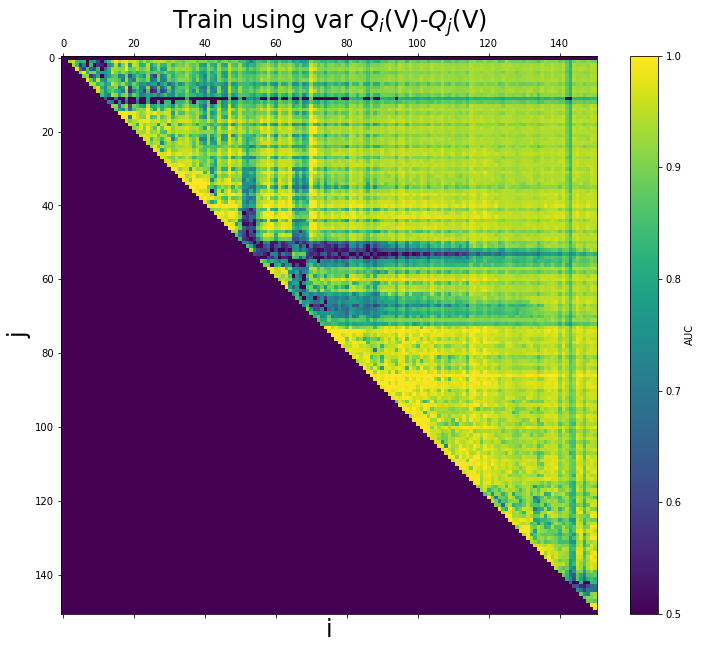

In [24]:
# 행렬에서 가장 높은 행을 찾기
plt.figure(figsize=(12,10))
plt.matshow(mx_train, cmap=plt.cm.viridis,fignum=1,aspect='auto')
plt.clim(0.5,1)
plt.colorbar(label='AUC')
plt.xlabel('i',fontsize=24)
plt.ylabel('j',fontsize=24)
plt.title('Train using var $Q_i$(V)-$Q_j$(V)',fontsize=24)
plt.show()

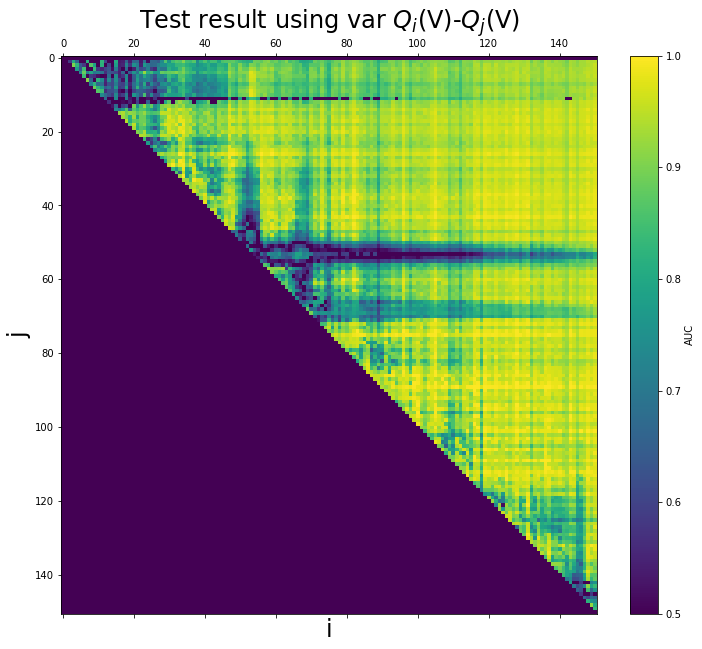

In [25]:
plt.figure(figsize=(12,10))
plt.matshow(mx_test, cmap=plt.cm.viridis,fignum=1,aspect='auto')
plt.clim(0.5,1)
plt.colorbar(label='AUC')
plt.xlabel('i',fontsize=24)
plt.ylabel('j',fontsize=24)
plt.title('Test result using var $Q_i$(V)-$Q_j$(V)',fontsize=24)
plt.show()

In [26]:
a=mx_train+mx_test
np.where(a==np.max(a))

(array([32, 74, 86, 86, 86, 88, 88], dtype=int64),
 array([ 34,  96,  99, 100, 105,  99, 105], dtype=int64))

In [27]:
a[np.where(a==np.max(a))]

array([2., 2., 2., 2., 2., 2., 2.])

In [28]:
a=mx_train[:10,:10]+mx_test[:10,:10]
np.where(a==np.max(a))

(array([6], dtype=int64), array([7], dtype=int64))

In [29]:
a[np.where(a==np.max(a))]

array([1.89995974])